### Concrete Compressive Strength Data Set 
https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength

#### Abstract: 
Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients.

#### Data Set Information:

1. Number of instances 1030 
2. Number of Attributes	9 
3. Attribute breakdown	8 quantitative input variables, and 1 quantitative output variable 
4. Missing Attribute Values	None 


#### Attribute Information:

Given are the variable name, variable type, the measurement unit and a brief description. The concrete compressive strength is the regression problem. The order of this listing corresponds to the order of numerals along the rows of the database. 

Name -- Data Type -- Measurement -- Description 

1. Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable 
2. Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable 
3. Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable 
4. Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable 
5. Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable 
6. Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable 
7. Fine Aggregate (component 7)	-- quantitative -- kg in a m3 mixture -- Input Variable 
8. Age -- quantitative -- Day (1~365) -- Input Variable 
9. Concrete compressive strength -- quantitative -- MPa -- Output Variable 





In [1]:
#importing the needed packages
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.manifold import TSNE
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
#Setting style for seaborn charts
sns.set_context("talk", font_scale=0.75, rc={"lines.linewidth": 2.5})

In [3]:
#Reading the dataset
train_df = pd.read_csv("concrete.csv")
train_df.head(10).T

0        1       2       3        4       5       6  \
cement        141.30   168.90  250.00  266.00   154.80  255.00  166.80   
slag          212.00    42.20    0.00  114.00   183.40    0.00  250.20   
ash             0.00   124.30   95.70    0.00     0.00    0.00    0.00   
water         203.50   158.30  187.40  228.00   193.30  192.00  203.50   
superplastic    0.00    10.80    5.50    0.00     9.10    0.00    0.00   
coarseagg     971.80  1080.80  956.90  932.00  1047.40  889.80  975.60   
fineagg       748.50   796.20  861.20  670.00   696.70  945.00  692.60   
age            28.00    14.00   28.00   28.00    28.00   90.00    7.00   
strength       29.89    23.51   29.22   45.85    18.29   21.86   15.75   

                    7        8       9  
cement         251.40   296.00  155.00  
slag             0.00     0.00  184.00  
ash            118.30     0.00  143.00  
water          188.50   192.00  194.00  
superplastic     6.40     0.00    9.00  
coarseagg     1028.40  1085.00  880.00  
fineagg        757.70   765.00  699.00  
age             56.00    28.00   28.00  
strength        36.64    21.65   28.99

#### Immediate Observation : 
Random inspection is not revealing obvious null values, however dataset seem to have lot of ZEROs at very first glance at few random records inspection.

In [4]:
###############################################################################
####### PROFLING REPORT FROM PANDAS - FIRST STEP BEFORE OTHER EDAs ############
######## One of the COOL FEATURES OF PANDAS ###################################
###############################################################################

import pandas_profiling
pandas_profiling.ProfileReport(train_df)

#### Profiling Report at glance :

1. Like suspected in random records inspection --> features 'ash', 'slag', 'superplastic' has lot of ZEROs. 
2. Another interesting observation is, dataset having duplicate rows which are not good for model implementation. We need to get rid off these duplicates before training our model
3. There seems to be pairwise strong correlation between features - which we would inspect in detail down the lane in feature engineering
4. NO missing values - That brings an interesting question, are those ZERO values in features missing values? or, are they ZERO on purpose? We would need to inspect the data further

This profiling option from pandas definitely gives us a kick start in identifying areas to do a deep dive. Definitely, one of the awesomeness from Pandas!

In [5]:
#let us see whether pandas has read the data types correctly like given in dataset description
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


##### Total of 8 features and 1 dependent continuous variable(strength) as mentioned in problem statement

In [6]:
###since NO MISSING VALUES(nan), inspecting the max, min, median, mean and count to inspect the data further
train_df.describe().T

count        mean         std     min      25%      50%  \
cement        1030.0  281.167864  104.506364  102.00  192.375  272.900   
slag          1030.0   73.895825   86.279342    0.00    0.000   22.000   
ash           1030.0   54.188350   63.997004    0.00    0.000    0.000   
water         1030.0  181.567282   21.354219  121.80  164.900  185.000   
superplastic  1030.0    6.204660    5.973841    0.00    0.000    6.400   
coarseagg     1030.0  972.918932   77.753954  801.00  932.000  968.000   
fineagg       1030.0  773.580485   80.175980  594.00  730.950  779.500   
age           1030.0   45.662136   63.169912    1.00    7.000   28.000   
strength      1030.0   35.817961   16.705742    2.33   23.710   34.445   

                   75%     max  
cement         350.000   540.0  
slag           142.950   359.4  
ash            118.300   200.1  
water          192.000   247.0  
superplastic    10.200    32.2  
coarseagg     1029.400  1145.0  
fineagg        824.000   992.6  
age             56.000   365.0  
strength        46.135    82.6

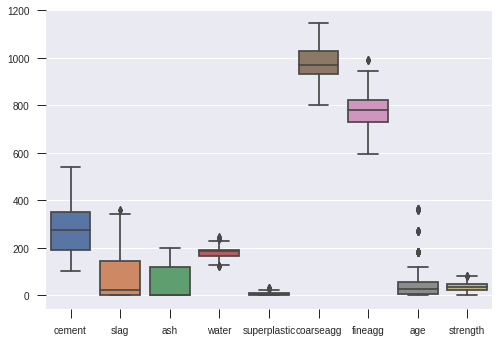

In [7]:
#### Continuing the Five Number Summary inspection, plotting box plots as well 
sns.boxplot(data = train_df)

#### Observation : 

1. Cement - Median is 273 and Mean is 281. Definitely distribution does not look perfect as mean is not equal to median, however from box plot, it is evident that there are no outliers
2. Slag - This needs to be inspected further. This is one of those features with LOT OF ZERO values(close to 46% of data in this feature is ZERO). MEAN IS WAY OFF FROM MEDIAN, and this could be the impact of zero values as well. Definite symptom of outliers being present, box plot also confirms the existence of outliers. Marking this as feature to be inspected further in details.
3. ash - This also needs to be inspected further. Another feature with LOT OF ZERO values (close to 55% of data in this feature is ZERO). MEAN IS WAY OFF FROM MEDIAN, this needs to be inspected further.
4. water, fineagg, age - Confirms the presence of outliers, distribution of these features need to be studied further and assess on how to treat those outliers
5. coarseagg - That is the only other feature along with cement which looks okay with mean 968 and median 972, box plot does not indicate any evident outliers.
6. superplastic - Another feature with LOT OF ZERO values(37% of data in this feature).Need to inspect this further.

##### Consolidating features that look okay : 
cement, coarseagg

##### Consolidating features that has evident outliers :
water, fineagg, age

##### Consolidating features that has to be inspected for having LOT OF ZEROs :
slag, ash, superplastic

In [8]:
###################################################################################
### This function takes input dataframe and returns separate list of ##############
#### Numerical features, Categorical features, target AND NULL VALUE features #####
###################################################################################

def extract_feature_types(train_df, itarget=None):
    
    categorical_features = []
    numerical_features = []
    target = []
    for column in train_df.columns:
        if (train_df[column].dtype == 'object' or train_df[column].dtype.name == 'category'):
            print ("**** Adding categorical feature **** ")
            print (column)
            train_df[column] = train_df[column].astype('category')
            if(column not in (itarget)):
                categorical_features = categorical_features + [column]
            else:
                target = column
        else :
            if(column not in (itarget)):
                numerical_features = numerical_features + [column]
            else:
                target = column
    null_features = train_df.columns[train_df.isnull().any()]
    return numerical_features, categorical_features, target, null_features

        

In [9]:
####################################################################################
############# Utility function to draw set of KDE plots for list of features #######
####################################################################################

def dist_plot_series(train_df, total_feature_list, number_of_graphs=2, category=None):

    number_of_graphs = number_of_graphs
    grid_x = int(len(total_feature_list)/number_of_graphs)
    
    f, axes = plt.subplots(grid_x, number_of_graphs, figsize=(16, 16), sharex=False)
    axis_y = 0
    axis_x = 0
    
    axis_list = []
    for i in range(grid_x):
        for j in range(number_of_graphs):
            if(i==0 and j==0):
                axis_list = [[i,j]]
            else:
                axis_list = axis_list + [[i,j]]
    
    for i,feature in enumerate(total_feature_list):
                
        grid = sns.FacetGrid(train_df, hue=category, size=5)
            
        grid.map(sns.kdeplot, feature, ax=axes[axis_list[i][0], axis_list[i][1]]) \
        .add_legend()
        
        axes[axis_list[i][0], axis_list[i][1]].set_title("KDE plot for " + feature)
      
        plt.close(2)
    return

In [10]:
####################################################################
#### Utility Function to plot the correlation matrix ###############
####################################################################

def correlation_matrix(train_df, width=11, height=9, mask_upper=True) :
    # Compute the correlation matrix
    corr = train_df.corr()
    
    if mask_upper == True:
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    else: 
        mask=None

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(width, height))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return corr;

In [11]:
##################################################################
#### Utility function for bivariate analysis - Scatter plot#######
##################################################################

def plot_scatter (graph_df, x_axis, y_axis, target=None):
    
    sns.FacetGrid(graph_df, hue=target, size=5) \
    .map(plt.scatter, x_axis, y_axis) \
    .add_legend()
    
    return;

In [12]:
##########################################
#### Utility function for KDE  plot#######
##########################################

def plot_kde (graph_df, axis, target=None):
    
    sns.FacetGrid(graph_df, hue=target, size=5) \
    .map(sns.kdeplot, axis) \
    .add_legend()
    
    return;

In [13]:
##########################################
#### Utility function for Box  plot#######
##########################################

def plot_boxen(graph_df, x_axis, y_axis):
    
    sns.catplot(x=x_axis, y=y_axis, kind="boxen", data=graph_df)
    return;

In [14]:
#########################################################################################################################
##### BOXEN PLOT -  It is similar to a BOX plot in plotting a nonparametric representation of a distribution ############
#########in which all features correspond to actual observations. By plotting more quantiles, it provides ###############
##################more information about the shape of the distribution, particularly in the tails. ######################
############################For a more extensive explanation : please refer official doc ################################
#################################  https://seaborn.pydata.org/generated/seaborn.boxenplot.html   ########################
#########################################################################################################################
def boxen_plot_series(train_df, total_feature_list, number_of_graphs=2, category=None):

    number_of_graphs = number_of_graphs
    grid_x = int(len(total_feature_list)/number_of_graphs)

    f, axes = plt.subplots(grid_x, number_of_graphs, figsize=(16, 16), sharex=False)
    axis_y = 0
    axis_x = 0
    
    for feature in total_feature_list:
        
        sns.catplot(x=category, y=feature, kind="boxen", data=train_df,
                    ax=axes[axis_x,axis_y])
        
        axes[axis_x,axis_y].set_title("BOX plot for " + feature)
        axis_x += 1
        axis_y += 1
        if(axis_y == number_of_graphs):
            axis_y = 0;
        if(axis_x == grid_x):
            axis_x = 0; 
        
        plt.close(2) 
        
    
        ## to hide the empty graphs, issue reference : https://github.com/mwaskom/seaborn/issues/1514

In [15]:
#### ##########################################################################
######## Small util function to return the list of outlier features ###########
###############################################################################

def get_feature_names(train_df, column_index):
    outlier_features = []
    index_list = np.unique(column_index).tolist()
    
    for i,element in enumerate(index_list):
        outlier_features = outlier_features +[train_df.iloc[:,element].name]
    return outlier_features      

In [16]:
from scipy import stats
#######################################################################
######### We are going to rely on Z Score to detect the outliers ######
################ Small utility function to take input feature #########
########################## & return the list of outliers ##############
#######################################################################
def detect_outliers(X, train_df):

    z_score = np.abs(stats.zscore(X))
    row_index,column_index = np.where(z_score > 3)
    outlier_features = get_feature_names(train_df, column_index)
    return row_index, column_index, outlier_features
    

In [17]:
######################################################################################
#### Utility plot to compare a feature before and after outlier treatement ###########
######################################################################################
def compare_outliers_plot(before_train_df, imputed_train_df, before_target, after_target, feature ):
    
    f, axes = plt.subplots(2, 2, figsize=(14, 6), sharex=False)

    sns.catplot(x=before_target, y=feature, kind="boxen", data=before_train_df,
                        ax=axes[0,0])

    sns.catplot(x=after_target, y=feature, kind="boxen", data=imputed_train_df,
                        ax=axes[0,1])
    
    sns.FacetGrid(train_df, hue=before_target, size=5) \
        .map(sns.kdeplot, feature, ax=axes[1,0]) \
        .add_legend()
    
    sns.FacetGrid(imputed_train_df, hue=after_target, size=5) \
        .map(sns.kdeplot, feature, ax=axes[1,1]) \
        .add_legend()

    axes[0,0].set_title("Box BEFORE Outlier treatement for " + feature)
    axes[0,1].set_title("Box AFTER Outlier treatement for " + feature)
    axes[1,0].set_title("KDE BEFORE Outlier treatement for " + feature)
    axes[1,1].set_title("KDE AFTER Outlier treatement for " + feature)

    plt.close(2)
    plt.close(3)
    plt.close(4)
    plt.close(5)
    plt.tight_layout()

In [18]:
numerical_features, categorical_features, target, null_features = extract_feature_types(train_df, 'strength')
print("\n############### Numerical features are ############### \n  %s \n"%(numerical_features))
print("############### Categorical features are ############### \n  %s \n"%(categorical_features))
print("############### Features having NULL values ############### \n \n %s \n"%(null_features))
print("############### Target/y############### \n  %s "%(target))



############### Numerical features are ############### 
  ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age'] 

############### Categorical features are ############### 
  [] 

############### Features having NULL values ############### 
 
 Index([], dtype='object') 

############### Target/y############### 
  strength 


##### There are NO NULL VALUES like we already knew from pandas profiling report. Now that, 8 features remaining are in numeric nature - we can go ahead and inspect collinearity straight away.

cement      slag       ash     water  superplastic  coarseagg  \
cement        1.000000 -0.275216 -0.397467 -0.081587      0.092386  -0.109349   
slag         -0.275216  1.000000 -0.323580  0.107252      0.043270  -0.283999   
ash          -0.397467 -0.323580  1.000000 -0.256984      0.377503  -0.009961   
water        -0.081587  0.107252 -0.256984  1.000000     -0.657533  -0.182294   
superplastic  0.092386  0.043270  0.377503 -0.657533      1.000000  -0.265999   

               fineagg       age  strength  
cement       -0.222718  0.081946  0.497832  
slag         -0.281603 -0.044246  0.134829  
ash           0.079108 -0.154371 -0.105755  
water        -0.450661  0.277618 -0.289633  
superplastic  0.222691 -0.192700  0.366079

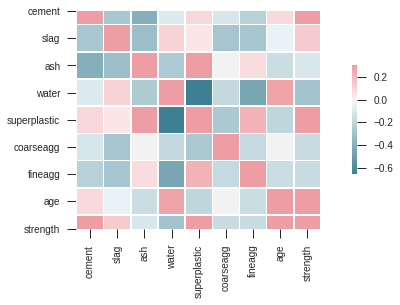

In [19]:
## Computing correlation matrix
corr = correlation_matrix(train_df[numerical_features+["strength"]], 11, 4, False)
#### Inspecting the correlation dataframe ####
corr.head()

#### NOTE : If you Observe FIRST and LAST Rows of heatmap, they are half the square size in plot. This is due to OPEN BUG IN MATPLOT LIB 3.1.1 (latest version as of 08/12/2019)
https://github.com/matplotlib/matplotlib/issues/14675

In [20]:
#####################################################################################
####### FETCHING THE FEATURE PAIRS THAT HAS STRONG CORRELATION ONLY #################
############ i.e. corr_value != 1 and corr_value > 0.1 or corr_value < -0.1 #########
##################### Let us study them further! ####################################
#####################################################################################
corr_val = corr.unstack().sort_values(kind='quicksort').to_dict()
temp_list = list(set([(tuple(sorted(key)), corr_val[key]) for key in corr_val]))

corr_df = pd.DataFrame(temp_list, columns=['corr_pair', 'corr_value'])
corr_df.set_index('corr_pair', inplace =True)
corr_df.query('corr_value != 1 and corr_value > 0.1 or corr_value < -0.1 ') \
.sort_values(by=['corr_value'], ascending=False)

corr_value
corr_pair                            
(cement, strength)           0.497832
(ash, superplastic)          0.377503
(strength, superplastic)     0.366079
(age, strength)              0.328873
(age, water)                 0.277618
(fineagg, superplastic)      0.222691
(slag, strength)             0.134829
(slag, water)                0.107252
(ash, strength)             -0.105755
(cement, coarseagg)         -0.109349
(age, ash)                  -0.154371
(age, fineagg)              -0.156095
(coarseagg, strength)       -0.164935
(fineagg, strength)         -0.167241
(coarseagg, fineagg)        -0.178481
(coarseagg, water)          -0.182294
(age, superplastic)         -0.192700
(cement, fineagg)           -0.222718
(ash, water)                -0.256984
(coarseagg, superplastic)   -0.265999
(cement, slag)              -0.275216
(fineagg, slag)             -0.281603
(coarseagg, slag)           -0.283999
(strength, water)           -0.289633
(ash, slag)                 -0.323580
(ash, cement)               -0.397467
(fineagg, water)            -0.450661
(superplastic, water)       -0.657533

#### Observation : 
1. Ash & superplastic, age & water, fineagg & superplastic has some kind of positive correlation with each other
2. superplastic & water, fineagg & water, ash & slag, coarseagg & slag, fineagg & slag, coarseagg & superplastic, ash & water seem to have some strong negative correlation with each other
3. Cement is having several negative correlation with different features - ash, slag, fineagg, coarseagg
4. Target variable 'Strength' seem to have strong correlation with cement, superplastic, age, coarseagg, fineagg features. At first glance, they could potentially evolve as good predictors of strength.

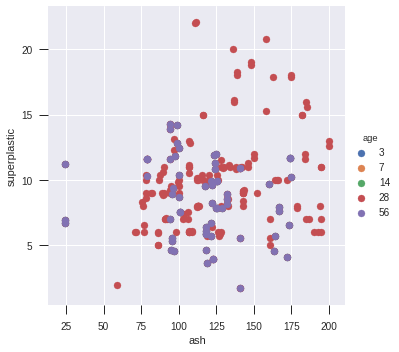

In [21]:
plot_scatter(train_df.query('age < 100 and ash > 0 and superplastic > 0'),"ash", "superplastic", "age")

###### Observation 1 : 

1. Among the population with age < 100, Majority of the age values is around 25-60 (28 and 56 to be more specific)
2. Ash and superplastic seem to have non-linear relation in positive direction i.e. with increase in ash, superplastic is increasing as well in non linear way

i.e.,
###### age AND superplastic - POSITIVE NON LINEARITY 

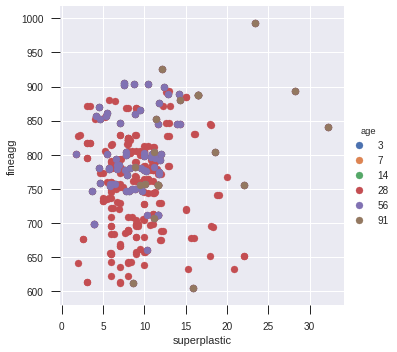

In [22]:
plot_scatter(train_df.query('age < 100 and superplastic > 0'),"superplastic", "fineagg", "age")

###### Observation 2: 

1. Increase in superplastic values seem to have increase in fineagg value as well among the population of age < 100.
2. With age close to 100 i.e. at 91 to be in specific - points are really scattered like cloud. 
3. This gives first symptoms - AGE < 100 MIGHT PLAY GOOD LINEAR/NON-LINEAR influencing of other features

###### From Observation 1 & 2 - fineagg, superplastic, ash  - POSITIVE NON LINEAR RELATIONSHIP


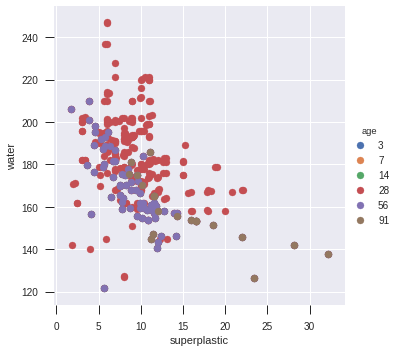

In [23]:
#### Plot Superplastic vs Water
plot_scatter(train_df.query('age < 100 and superplastic > 0'),"superplastic", "water", "age")

###### Observation 3: 

Lower values of superplastic seem to have higher value in feature 'water' and relation seems to be nonlinear as well. i.e., 

###### water AND superplastic - NEGATIVE NON LINEAR RELATION

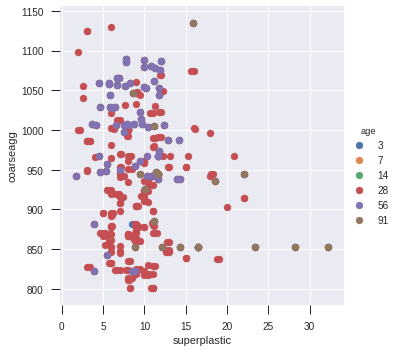

In [24]:
#### Plot Superplastic vs coarseagg
plot_scatter(train_df.query('age < 100 and superplastic > 0'),"superplastic", "coarseagg", "age")

###### Observation 4:

superplastic is having lower values for higher values of coarseagg in non linear way. i.e., 

###### superplastic AND coarseagg - NEGATIVE NON LINEAR RELATION plus water, superplastic and coarseagg seem to influence in negative direction from observation 3 and 4

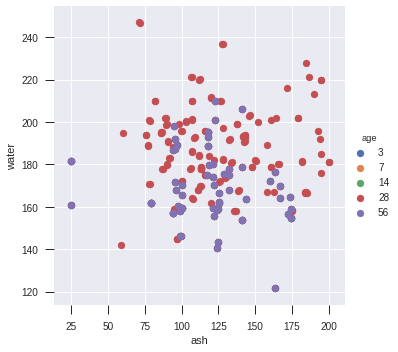

In [25]:
#### Plot ash vs Water
plot_scatter(train_df.query('age < 100 and ash > 0'),"ash", "water", "age")

This does not reveal very clear relation, but majority of points have higher value of water for lower value of ash. i.e., 

###### water AND ash - NEGATIVE NON LINEAR RELATION

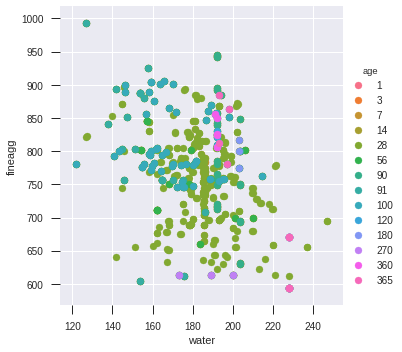

In [26]:
#### Plot fineagg vs Water
plot_scatter(train_df,"water", "fineagg", "age")

very evident like in some observations, i.e., 

###### water and fineagg - NEGATIVE NON LINEAR RELATION

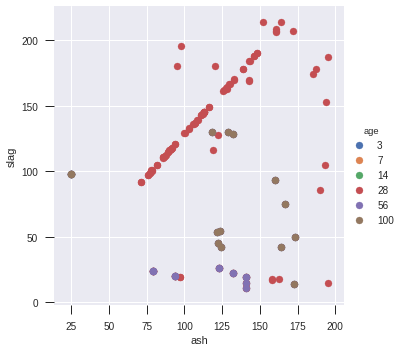

In [27]:
#### Plot Ash vs Slag
plot_scatter(train_df.query('ash > 0 and slag > 0'),"ash", "slag", "age")

###### Not very clear from datapoints except for the fact - AT AGE 28, feature is STRONGLY LINEAR IN POSITIVE WAY

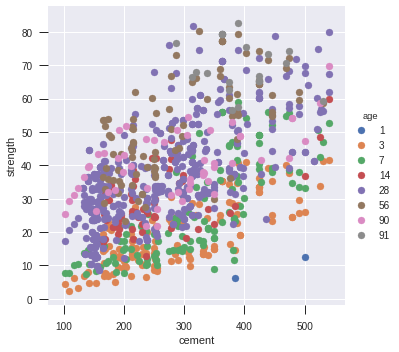

In [28]:
##### Plotting Cement Vs Strength for ALL AGE values
plot_scatter(train_df.query('age < 100'),"cement", "strength", "age")

This definitely seem to have positive non linear relationship between cement and strength. With strength being our predictor (continuous value), let us inspect bit more details for high level age categories below

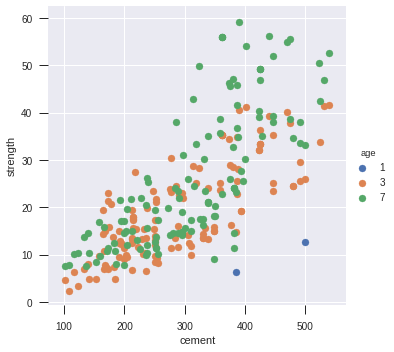

In [29]:
##### Plotting Cement Vs Strength for ONLY AGE LESS THAN 10
plot_scatter(train_df.query('age < 10'),"cement", "strength", "age")

###### For age less than 10, very clear STRONG NON LINEAR RELATION for feature CEMENT with STRENGTH

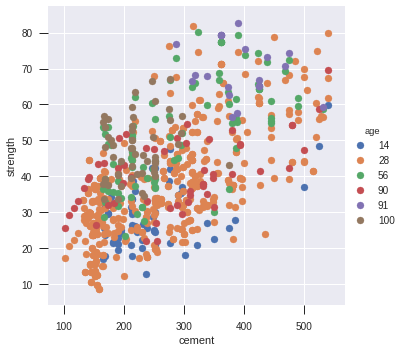

In [30]:
##### Plotting Cement Vs Strength for ONLY AGE BETWEEN 11 and 100
plot_scatter(train_df.query('age > 10 and age <= 100'),"cement", "strength", "age")

###### Age category between 11 and 100 seem to have majority of data points. Cement has STRONG POSITIVE NON LINEAR RELATION with Strength feature

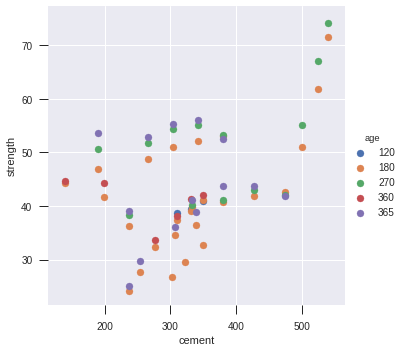

In [31]:
##### Plotting Cement Vs Strength for ONLY MORE THAN 100
plot_scatter(train_df.query('age > 100'),"cement", "strength", "age")

###### Very less points > 100 but cement is still playing POSITIVE NON LINEAR RELATION with strength feature

#### New Feature : Age Category, why not?

Very evident from above plots, that age is playing additional role in influencing other features to help predicting the target variable. So why not, creating a new feature 'Age Category'? 

In [32]:
age_range = [0, 11, 101, 251, np.inf]
label_category = ['age0_10', 'age11_100', 'age101_250', 'age>250']

train_df['age_category'] = pd.cut(train_df['age'], age_range, labels=label_category)
train_df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength age_category  
0     29.89    age11_100  
1     23.51    age11_100  
2     29.22    age11_100  
3     45.85    age11_100  
4     18.29    age11_100

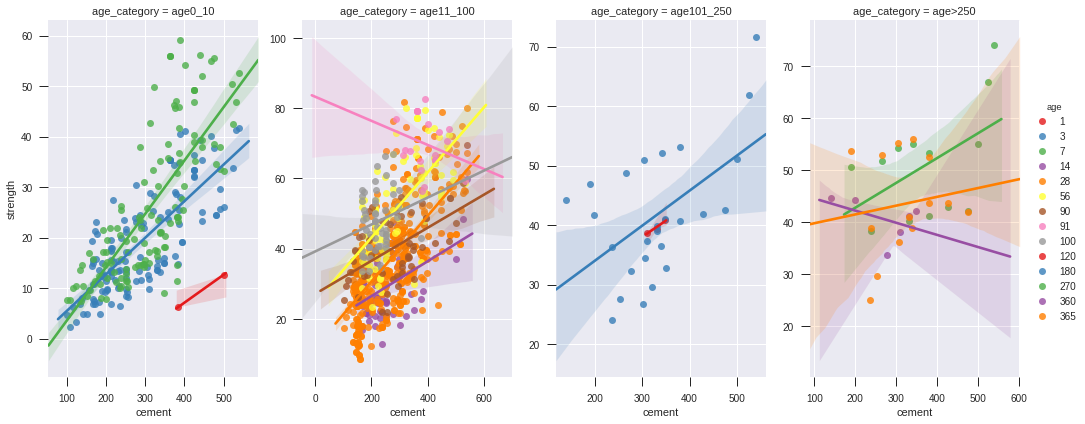

In [33]:
##################################################################################################
### Since strength is having strong correlation with cement, trying linear regression plots ######
############# First level of EDA to get idea of data points ######################################
##################################################################################################
sns.lmplot(x="cement", y="strength", hue="age", data=train_df, palette="Set1", col="age_category"
          , height=6, aspect=.6, sharey=False, sharex=False)

###### well, that DID NOT GO REALLY WELL! Since data points are very non linear in nature, A LINEAR LINE will NOT be a correct one. Let us go ahead and try higher order degree poly fits & look for the nature of the fit. At same time, let us be cautious of overfitting with higher order of polynomials

### Analysis of Cement Vs Strength for ALL Age Groups :

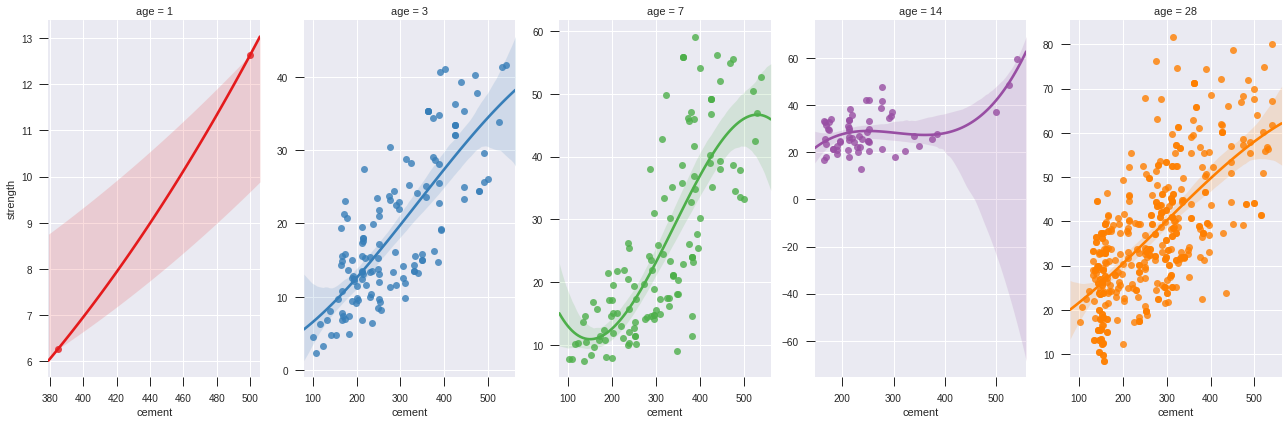

In [34]:
##################################################################################################
### Since strength is having strong correlation with cement, trying NON LINEAR regression plots ##
############# First level of EDA to get idea of data points ######################################
######################### Data for AGE between 0 & 50 ############################################
##################################################################################################
sns.lmplot(x="cement", y="strength", hue="age", data=train_df.query('age < 50'), palette="Set1", col="age"
          , height=6, aspect=.6, sharey=False, sharex=False, order=3)

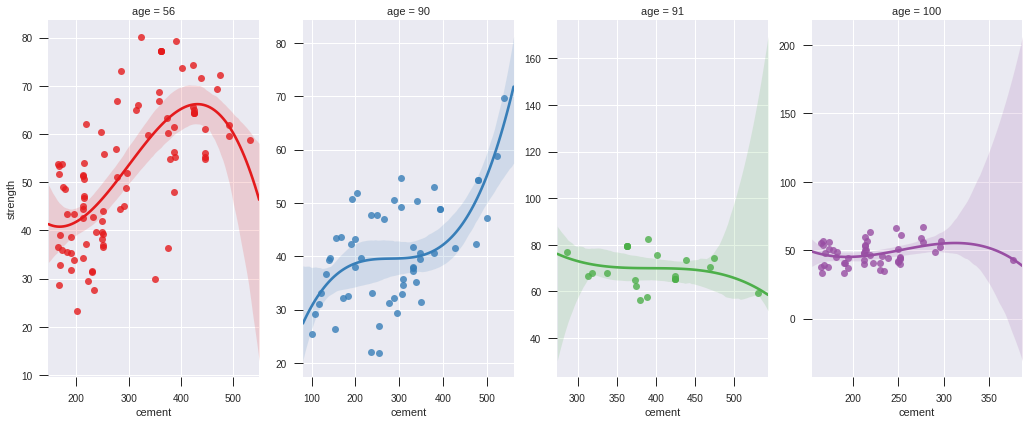

In [35]:
##################################################################################################
### Since strength is having strong correlation with cement, trying NON LINEAR regression plots ##
############# First level of EDA to get idea of data points ######################################
######################### Data for AGE between 50 & 100 ##########################################
##################################################################################################
sns.lmplot(x="cement", y="strength", hue="age", data=train_df.query('age >= 50 and age <= 100'), 
           palette="Set1", col="age"
          , height=6, aspect=.6, sharey=False, sharex=False, order=3)

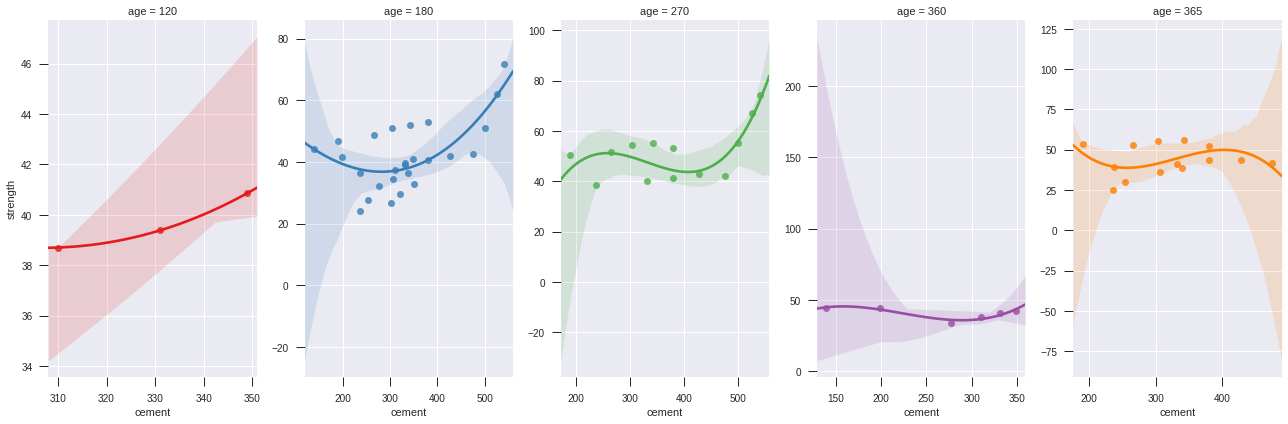

In [36]:
##################################################################################################
### Since strength is having strong correlation with cement, trying NON LINEAR regression plots ##
############# First level of EDA to get idea of data points ######################################
######################### Data for AGE Greater than 100 ##########################################
##################################################################################################
sns.lmplot(x="cement", y="strength", hue="age", data=train_df.query('age > 100'), palette="Set1", col="age"
          , height=6, aspect=.6, sharey=False, sharex=False, order=3)

#### Definitely cement is one of the strong predictors of strength - INTERESTING OBSERVATIONS :

1. For Age 1-25, strength seems to be around 10-35ish for cement values between 100-300
2. For Age > 25 and age < 90, strength SEEMS TO BETTER with strong values around 50-80 for higher values of cement.
3. For Age > 100, strength seem to be GETTING LOW for the same value of Cements that showed higher for age between 25-90.  

##### Definitely possible interaction feature between age and cement to give better combined predictions for strength(our continuous target variable)

### Analysis of WATER Vs STRENGTH for ALL Age Groups :

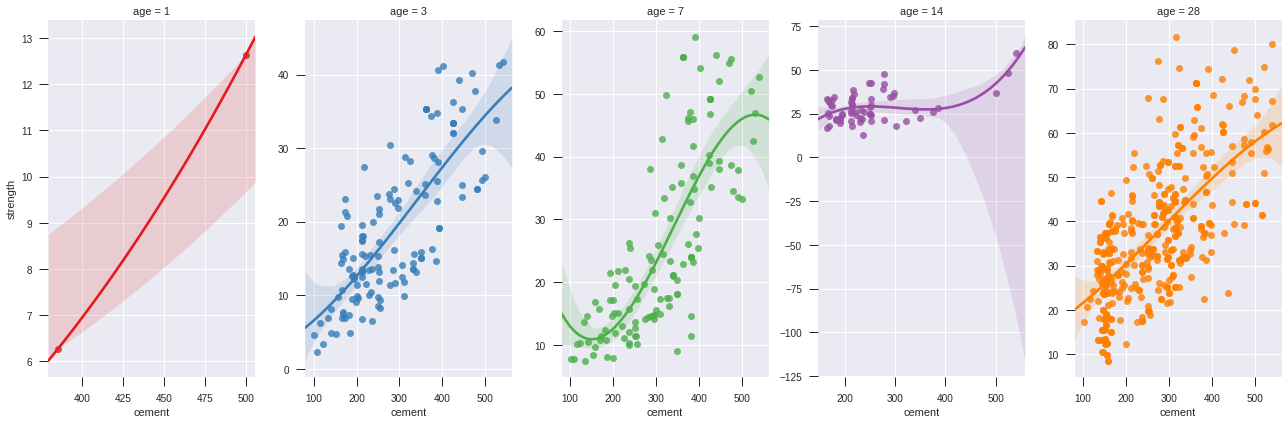

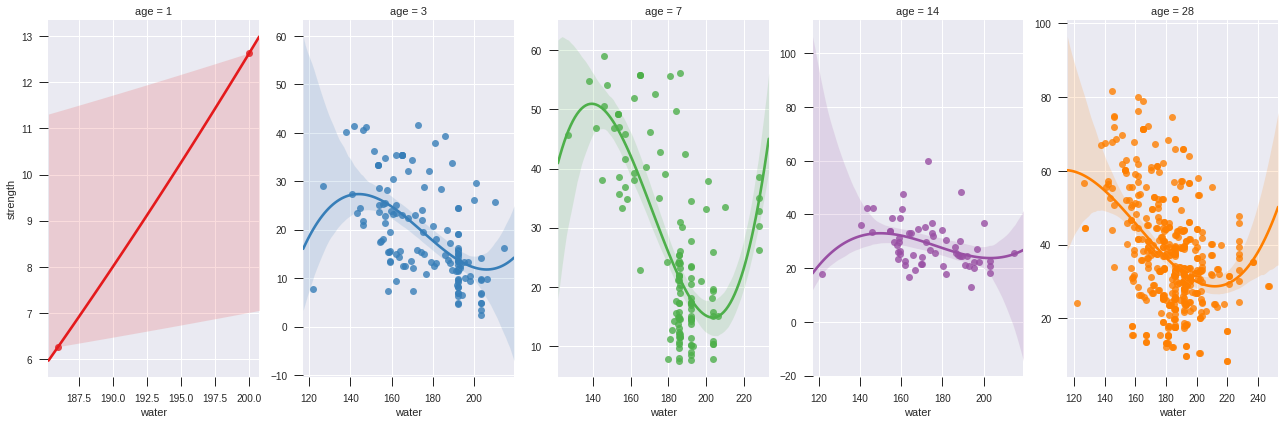

In [37]:
##################################################################################################
### Since strength is having strong correlation with WATER, trying NON LINEAR regression plots ###
############# First level of EDA to get idea of data points ######################################
######################### Data for AGE between 0 & 50 ############################################
##################################################################################################
sns.lmplot(x="cement", y="strength", hue="age", data=train_df.query('age < 50'), palette="Set1", col="age"
          , height=6, aspect=.6, sharey=False, sharex=False, order=3)
sns.lmplot(x="water", y="strength", hue="age", data=train_df.query('age < 50'), palette="Set1", col="age"
          , height=6, aspect=.6, sharey=False, sharex=False, order=3)

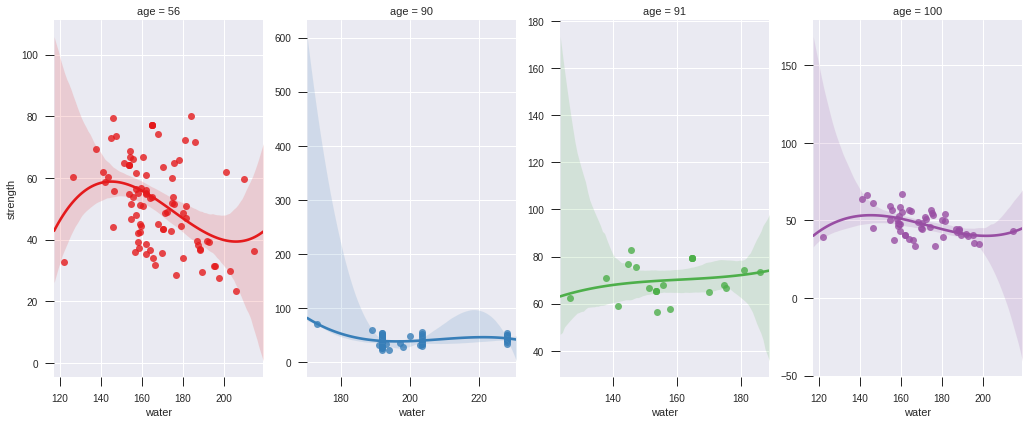

In [38]:
##################################################################################################
### Since strength is having strong correlation with WATER, trying NON LINEAR regression plots ###
############# First level of EDA to get idea of data points ######################################
######################### Data for AGE between 50 & 100 ##########################################
##################################################################################################
sns.lmplot(x="water", y="strength", hue="age", data=train_df.query('age > 50 and age <=100'), palette="Set1", col="age"
          , height=6, aspect=.6, sharey=False, sharex=False, order=3)

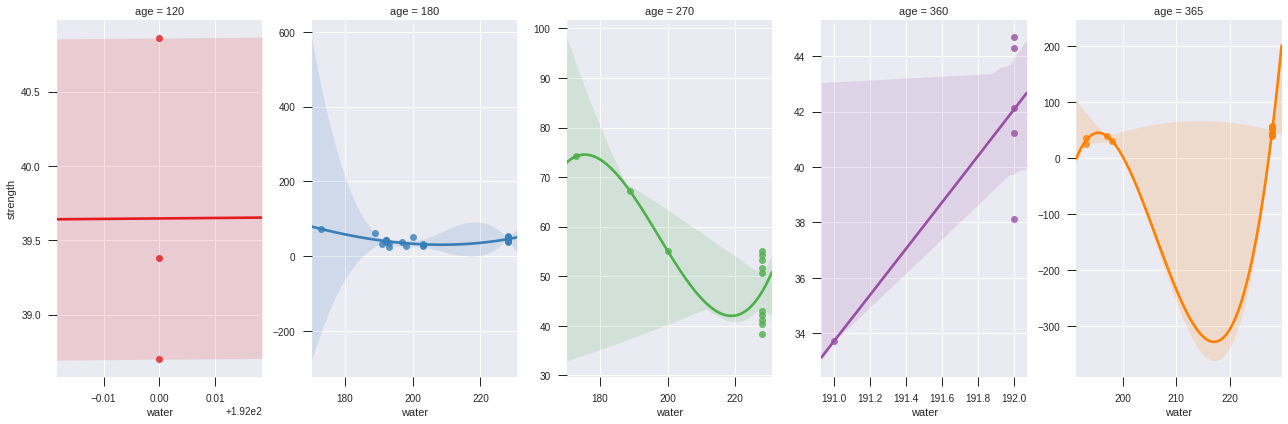

In [39]:
##################################################################################################
### Since strength is having strong correlation with WATER, trying NON LINEAR regression plots ###
############# First level of EDA to get idea of data points ######################################
######################### Data for AGE Greater than 100 ##########################################
##################################################################################################
sns.lmplot(x="water", y="strength", hue="age", data=train_df.query('age > 100'), palette="Set1", col="age"
          , height=6, aspect=.6, sharey=False, sharex=False, order=3)

#### Definitely WATER is one of the strong predictors of strength - INTERESTING OBSERVATIONS :

1. For Age 1-25, strength seems to be around 10-35ish like we observed for cement BUT WATER LEVELS are HIGHER > 200. This is interesting, may be weaker strength with more water levels? Could be.
2. For Age > 25 and age < 90, strength SEEMS TO BETTER with LOWER LEVELS of WATER around 100-120
3. For Age between 100-200, Lower levels of Water is still giving stronger strength values around 100.
4. For Age > 200, water level increases with reduction in strength

##### Definitely possible interaction feature between age, cement, water to give better combined predictions for strength(our continuous target variable)

#### Another creation of new Feature for EDA - Strength Category 
Adding this feature to visualize the strength predictor as categorical variable, which would be easy to categorize and inspect in visualization to get more insights

In [40]:
strength_range = [0, 21, 41, 61, 86, np.inf]
label_strength = ['strength0_20', 'strength21_40', 'strength41_60', 'strength61_85', 'strength>85']

train_df['strength_category'] = pd.cut(train_df['strength'], strength_range, labels=label_strength)
train_df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength age_category strength_category  
0     29.89    age11_100     strength21_40  
1     23.51    age11_100     strength21_40  
2     29.22    age11_100     strength21_40  
3     45.85    age11_100     strength41_60  
4     18.29    age11_100      strength0_20

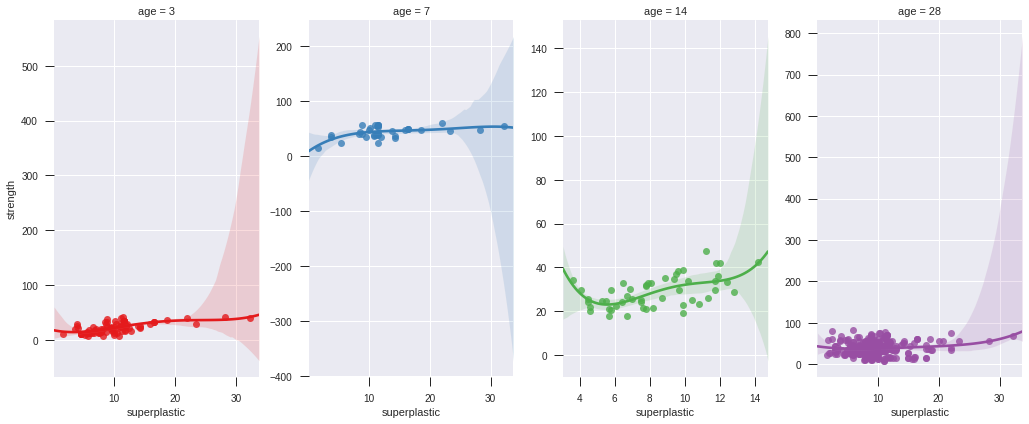

In [41]:
#######################################################################################################
# Since strength is having strong correlation with SUPERPLASTIC, trying NON LINEAR regression plots ###
############# First level of EDA to get idea of data points ###########################################
######################### Data for AGE between 0 & 50 #################################################
#######################################################################################################
sns.lmplot(x="superplastic", y="strength", hue="age", data=train_df.query('superplastic > 0 and age < 50'), palette="Set1", col="age"
          , height=6, aspect=.6, sharey=False, sharex=False, order=4)

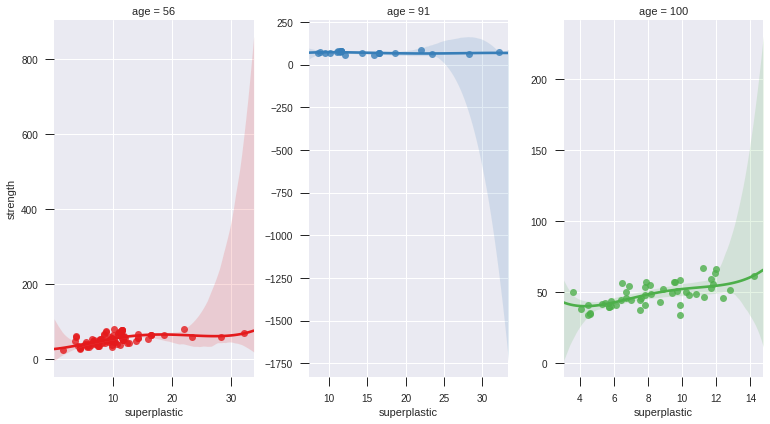

In [42]:
#######################################################################################################
# Since strength is having strong correlation with SUPERPLASTIC, trying NON LINEAR regression plots ###
############# First level of EDA to get idea of data points ###########################################
######################### Data for AGE between 50 & 100 ###############################################
#######################################################################################################
sns.lmplot(x="superplastic", y="strength", hue="age", data=train_df.query('superplastic > 0 and age > 50 and age <=100'), palette="Set1", col="age"
          , height=6, aspect=.6, sharey=False, sharex=False, order=4)

In [43]:
#######################################################################################################
# Since strength is having strong correlation with SUPERPLASTIC, trying NON LINEAR regression plots ###
############# First level of EDA to get idea of data points ###########################################
######################### Data for AGE greater than 100 ###############################################
#######################################################################################################


No data points for superplastic with age > 100 - Hence, NO PLOTS

#### Observation for superplastic feature : 
From observations of all the age levels - superplastic of higher values around 15-30 seems to have better strength and lower values of superplastic having lesser strength. Very evident positive non-linear relationship

##### Definitely possible interaction feature between age, cement, water, superplastic to give better combined predictions for strength(our continuous target variable)

### Inspecting Target Variable 'Strength' bit more ...

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

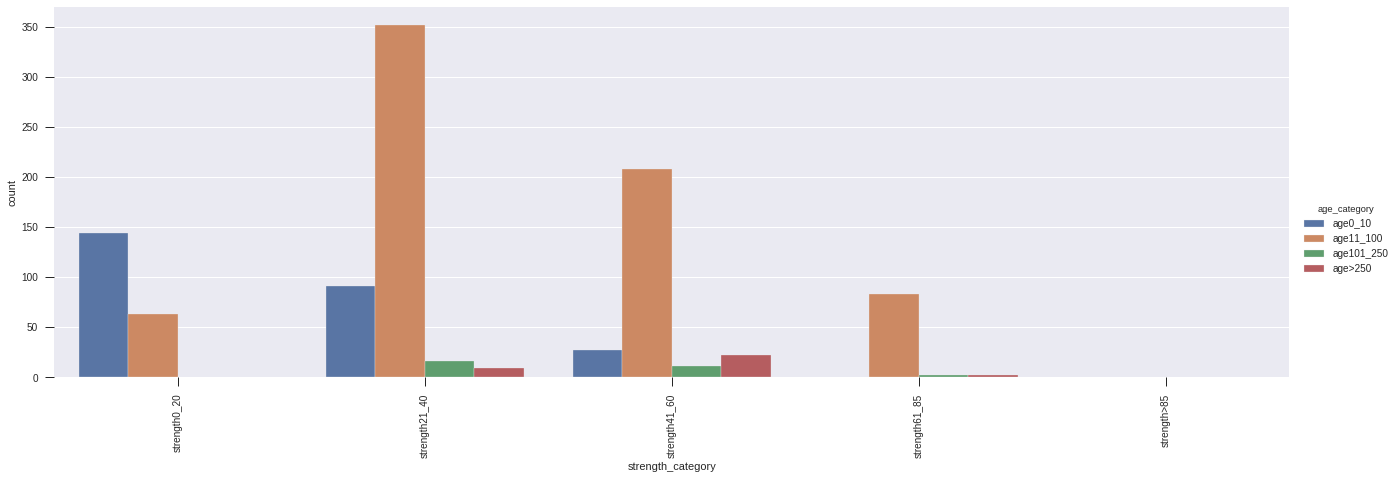

In [44]:
##############################################################
####### Inspecting the count of data by strength category ####
#### To get insights about distribution of strength across ###
##############################################################

sns.catplot(x="strength_category", hue="age_category", data=train_df,
            kind="count",height=6, aspect=3)
plt.xticks(rotation=90) ### to have clear X axis labels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

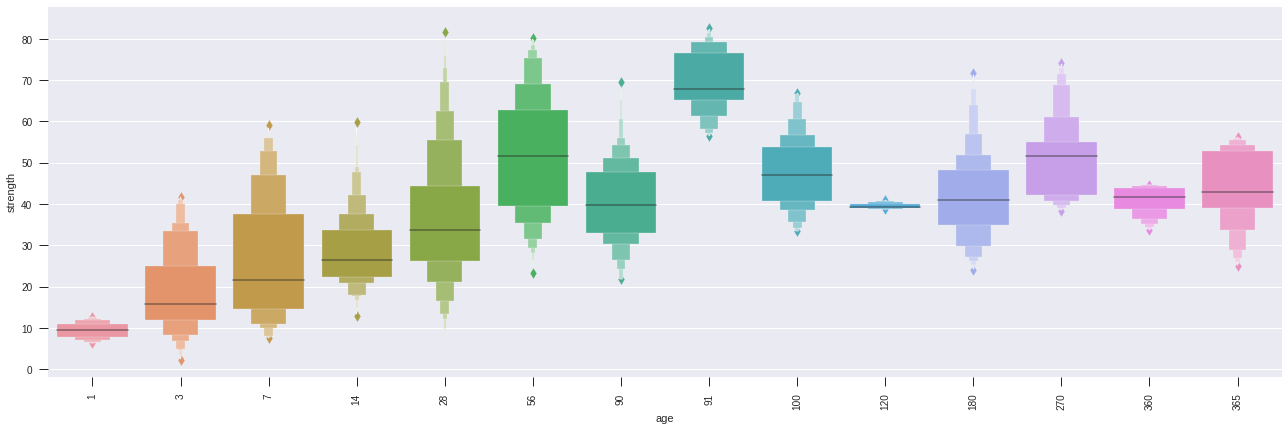

In [45]:
##############################################################
####### Inspecting Strength Vs Age - BOX PLOTs ###############
##############################################################

sns.catplot(x="age", y='strength',  data=train_df,
            kind="boxen",height=6, aspect=3)
plt.xticks(rotation=90) ### to have clear X axis labels

#### Beautiful implication from above isn't it?
As age goes up, strength keeps getting better, and get strong between 25 to 95, and then have slightest fall after 100 staying still strong (though NOT STRONGEST) consistently. 
What else is needed for us to convince that age's intreaction with other correlated features will definitely play better role in building stronger model. 

###### At this time - my exact thoughts, construct interaction features with age and convert age as categorical or mean encode the age.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

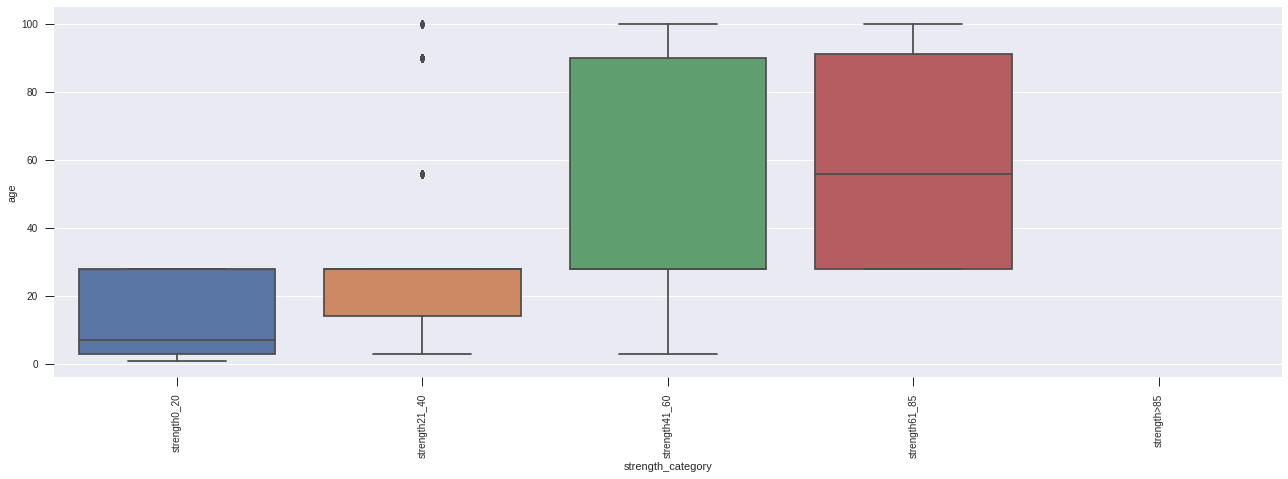

In [46]:
##############################################################
####### Inspecting Strength Vs Age - BOX PLOTs ###############
##############################################################

sns.catplot(x="strength_category", y='age',  data=train_df.query('age <= 100'),
            kind="box",height=6, aspect=3)
plt.xticks(rotation=90) ### to have clear X axis labels

#### Like already iterated above: 
Definitely, age <= 100 has more data points and even our first level of EDA suggest better strengths between age 25 and 90 with combined predictors of cement, water, superplastic and age

In [47]:
####################################################################################################
#### Like we saw in 'age' feature - let us inspect whether any numerical feature is discrete #######
################# i.e., though numerical in nature, limited number of unique values ################
######################### that could play vital role like age ######################################
####################################################################################################
discrete_variables = []
for feature in numerical_features:
    if (len(train_df[feature].unique()) <= 15) :
        discrete_variables = discrete_variables + [feature]

discrete_variables
    

['age']

In [48]:
numerical_features

['cement',
 'slag',
 'ash',
 'water',
 'superplastic',
 'coarseagg',
 'fineagg',
 'age']

Unfortunately, none!

In [49]:
################################################################################################
#### Small utility plot to visualize the box plot and distribution for outlier inspection ######
################################################################################################
def visualize_outliers(train_df, numerical_features, category=None):
    
    number_of_graphs = 2
    grid_x = int(len(numerical_features))
    f, axes = plt.subplots(grid_x, 2, figsize=(12, 24), sharex=False)
    axis_x = 0;
    
    for feature in numerical_features:
        
        g = sns.FacetGrid(train_df)
        g = g.map(sns.boxplot, feature, ax=axes[axis_x,0])
        
        _, bins = np.histogram(train_df[feature])
        g = sns.FacetGrid(train_df, hue=category)
        g.map(sns.distplot, feature, bins=bins, ax=axes[axis_x,1]) \
        .add_legend()
        
        axis_x = axis_x + 1
        plt.close(2)
        plt.close(3)
        plt.close(4)
        plt.tight_layout()

    

### Inspecting Ash Vs Strength

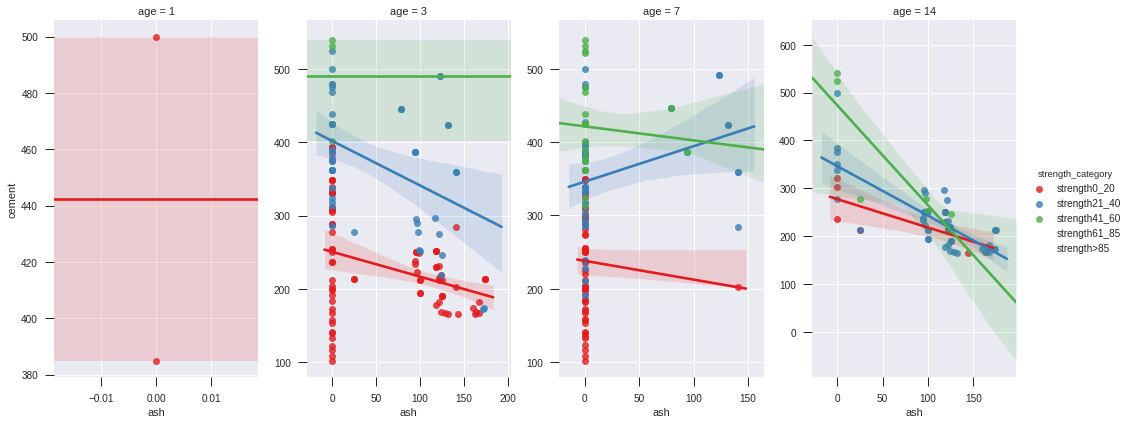

In [50]:
#######################################################################################################
##### Since we have already explored cement, water, superplastic and age, let us inspect 'ash' ########
########## Inspecting feature 'ash' for age groups less than 25 - lower strength category #############
#######################################################################################################

sns.lmplot(x="ash", y="cement", hue="strength_category", data=train_df.query('age<=25'), col="age",
           palette="Set1", height=6, aspect=.6, sharey=False, sharex=False, order=1)

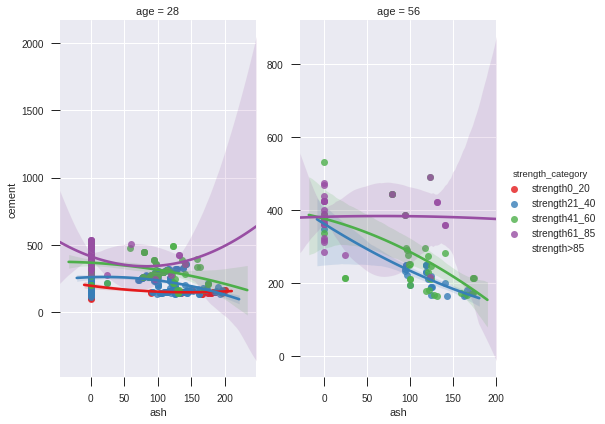

In [51]:
#######################################################################################################
##### Since we have already explored cement, water, superplastic and age, let us inspect 'ash' ########
########## Inspecting feature 'ash' for age groups between 25 and 90 - Higher strength category #######
#######################################################################################################

sns.lmplot(x="ash", y="cement", hue="strength_category", data=train_df.query('age>25 and age<90'), col="age",
           palette="Set1", height=6, aspect=.6, sharey=False, sharex=False, order=2)

##### ash is kind of having both positive and negative impact to strength for different age groups - Nothing much could be confirmed, need to study the interaction of this feature during model and evaluate with & without ash to see for performance difference

### Inspecting slag, coarseagg, fineagg Vs strength:

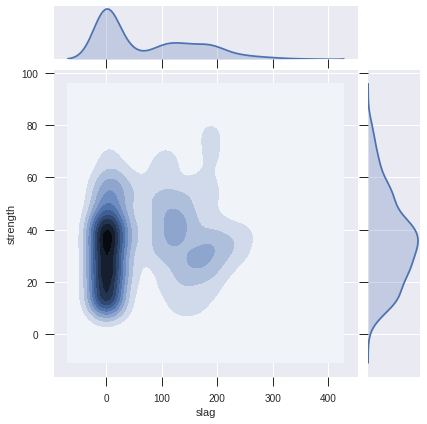

In [52]:
##### Inspecting slag vs strength #######
sns.jointplot(x="slag", y="strength", kind='kde', data=train_df)

###### Very stronger values of strength around lower values of slag, what is more interesting is - there seem to be multiple sub-classess/categories within slag found in small groups - one between 0 and 80, one between 100-150 and another between 150-250. Symptoms of distribution having definite multimodal peaks

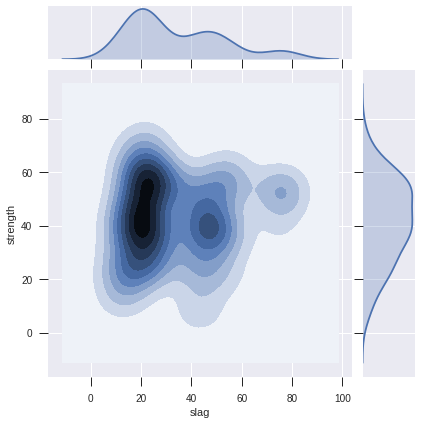

In [53]:
##### Inspecting slag (between 0 and 80) vs strength #######
sns.jointplot(x="slag", y="strength", kind='kde', data=train_df.query('slag > 0 and slag < 80'))

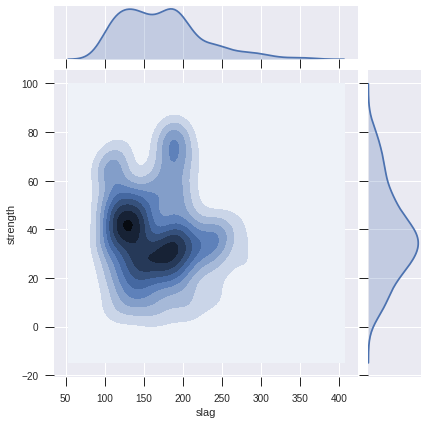

In [54]:
##### Inspecting slag (greater than 100) vs strength #######
sns.jointplot(x="slag", y="strength", kind='kde', data=train_df.query('slag >= 100'))

##### Like suspected, strength is found higher in 2 categories - one around 0 and 20ish and other around 150-200ish

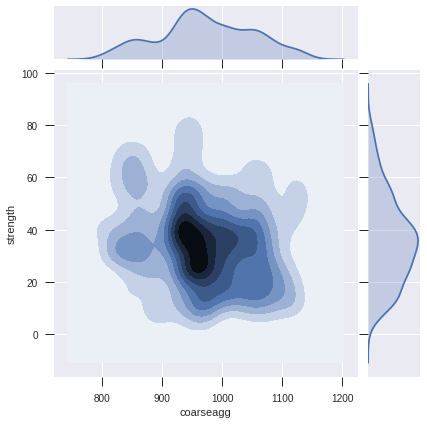

In [55]:
#### Inspecting coarseagg Vs strength
sns.jointplot(x="coarseagg", y="strength", kind='kde', data=train_df)

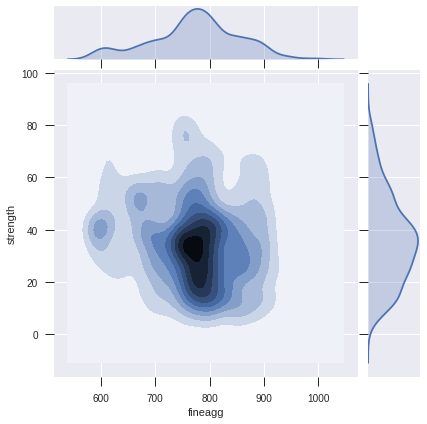

In [56]:
#### Inspecting coarseagg Vs strength
sns.jointplot(x="fineagg", y="strength", kind='kde', data=train_df)

##### My guess at this point - fineagg and coarseagg may not be strong predictors of strength. We will see during evaluation of the model

### Outliers Inspection and Treatment:

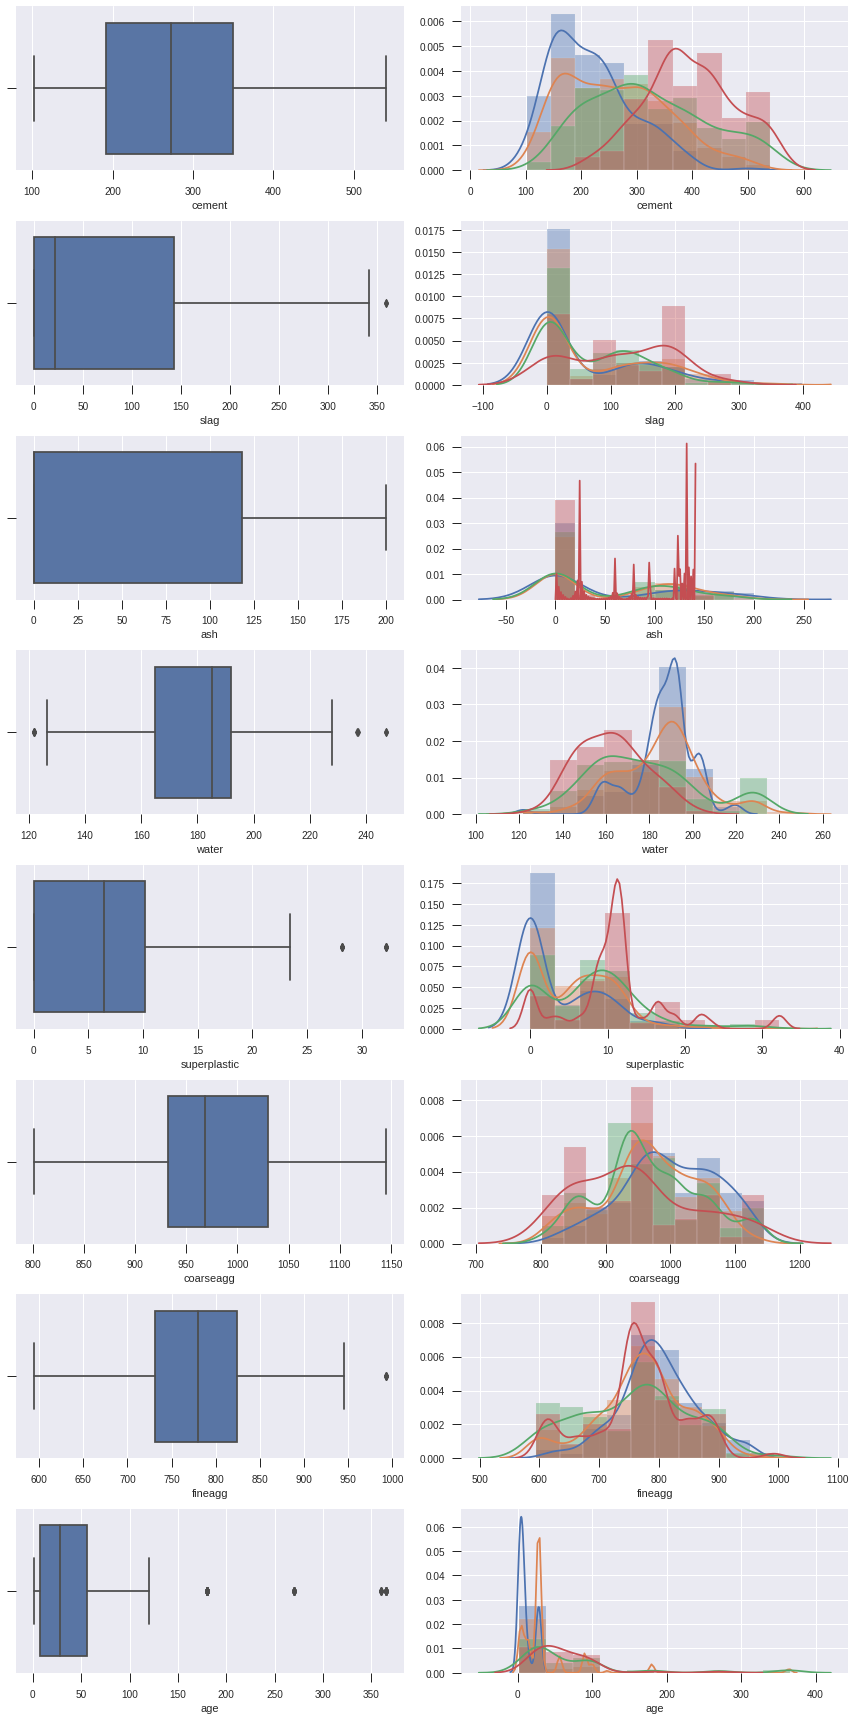

In [57]:
##### Let us have a look at outliers
visualize_outliers(train_df, numerical_features, "strength_category")

#### Observations on Outliers :

1. Age: Like we already know, age seems to be a discrete value. Values > 150 does not seem like outliers, they seem to be observations of rare values & no wonder that we have less datapoints among the population for age > 150
2. Cement, ash, coarseagg seem to be okay, there are no values outside +-1.5*IQR range
3. water, superplastic, fineagg and slag does have one or two points outide +-1.5*IQR range, but very hard to tell whether they are outliers or, rare values that cannot be outliers

In [58]:
### Splitting training dataset into X and Y
X = train_df.loc[:, numerical_features+categorical_features]
y = np.array(train_df.loc[:, target])
y_df = pd.DataFrame(y, columns=['target'])
extra_df = pd.DataFrame(data=train_df[['age_category', 'strength_category']], columns=['age_category', 'strength_category'])
X.shape, y.shape

((1030, 8), (1030,))

In [59]:
#############################################################
##### Determining outliers through Z score technique ########
#############################################################
row_index, column_index, outlier_features = detect_outliers(X, train_df)
print("****** Outliers are detected in ******\n")
print(outlier_features)
print("\n****** ************************ ******\n")
row_index, column_index

****** Outliers are detected in ******

['slag', 'water', 'superplastic', 'age']

****** ************************ ******



(array([  21,   44,   64,   66,  133,  149,  156,  157,  159,  198,  232,
         256,  262,  263,  270,  292,  297,  313,  323,  361,  393,  448,
         465,  484,  538,  564,  570,  601,  623,  632,  713,  720,  744,
         754,  755,  816,  838,  850,  878,  901,  918,  919,  951,  955,
         957,  990,  995, 1026, 1028]),
 array([1, 4, 7, 3, 7, 7, 4, 7, 7, 7, 4, 7, 7, 3, 7, 4, 7, 7, 7, 7, 7, 7,
        7, 7, 4, 1, 7, 7, 7, 7, 7, 7, 4, 7, 7, 4, 4, 7, 7, 7, 1, 7, 7, 4,
        7, 1, 7, 4, 7]))

##### Whichever we suspected as rare value, even through Zscore technique - they lie outside range of 3, meaning statistically they are in outlier range. I am going to try substituting outlier values to NaN and attempt imputation to see how it goes

In [60]:
######################################################################
##### Outliers IMPUTATION - USING MODEL BASED IMPUTATION ###########
######################################################################


#Let us take reliable regressor like random forest with default parameters
# to evaluate the imputation score
base_evaluator = RandomForestRegressor(random_state=42)

outliers_imputers_dict =  {
    "Bayesian Ridge": BayesianRidge(),    
    "Decision Tree Regressor": DecisionTreeRegressor(max_features='sqrt', random_state=0),
    "Extra Tree Regressor_10": ExtraTreesRegressor(n_estimators=10, random_state=0),       
    "Extra Tree Regressor_6": ExtraTreesRegressor(n_estimators=6, random_state=0),
    "Extra Tree Regressor_12": ExtraTreesRegressor(n_estimators=12, random_state=0),
    "Extra Tree Regressor_15": ExtraTreesRegressor(n_estimators=15, random_state=0),
    "KNeighborsRegressor_3": KNeighborsRegressor(n_neighbors=3),
    "KNeighborsRegressor_2": KNeighborsRegressor(n_neighbors=2),
    "KNeighborsRegressor_4": KNeighborsRegressor(n_neighbors=4),
    "KNeighborsRegressor_5": KNeighborsRegressor(n_neighbors=5),
    "KNeighborsRegressor_6": KNeighborsRegressor(n_neighbors=6) 
    }


In [61]:
def impute_outliers(X, y, missing_imputers_dict=None, verbose=False):
    imputer_eval_df = pd.DataFrame()
    cross_val_list = []
    scoring_parameters = ['explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

    for imputer_name, imputer in list(missing_imputers_dict.items()):

        if (verbose == True):
            print("***** BEGIN Imputation of [%s] *****"%(imputer_name))
        impute_itr = make_pipeline(IterativeImputer(random_state=42, estimator=imputer),
                                  base_evaluator)
        cross_val_clf = cross_validate(impute_itr, X, y,scoring=scoring_parameters,cv=5)
        metric_list = []
        for key in cross_val_clf.keys():
            metric_list =  metric_list + [cross_val_clf[key].mean()]

        imputer_eval_df = pd.concat([imputer_eval_df, 
                                     pd.DataFrame(metric_list, columns=[imputer_name], index=cross_val_clf.keys())], axis=1)
        cross_val_list = cross_val_list + [cross_val_clf]
        if (verbose == True):
            print("***** END Imputation of [%s] *****"%(imputer_name))

    imputer_eval_df = imputer_eval_df.T
    if (verbose == True):
        print("List of models imputed <%s>" %(cross_val_list))
    return imputer_eval_df, cross_val_list 
    

In [62]:
##### Small utility function to make outlier values as NAN #####

def make_outliers_null(X, row_index, column_index):
    for index, val in enumerate(row_index):        
       
        X[row_index[index]][column_index[index]] = np.nan
        
    return X;

In [63]:
#### Substituting Outliers with Null Values #####
X_outliers = make_outliers_null(X.values, row_index, column_index)

In [64]:
########################################################################################################
##### Invoke Impute outlier utility method which will evaluate multiple regressor models & #############
################ choose best model for imputing the outliers ###########################################
########################################################################################################
outliers_imputed_df, imputed_list = impute_outliers(X_outliers, y, outliers_imputers_dict, False)

In [65]:
############# Sorting by Mean Squared Error, Ascending is false, as it is negative values from scikit implementation ######

outliers_imputed_df.sort_values('test_neg_mean_squared_error', ascending=False).head(5)

fit_time  score_time  test_explained_variance  \
KNeighborsRegressor_4    0.025113    0.012330                 0.896794   
Extra Tree Regressor_6   0.094910    0.017781                 0.896445   
Extra Tree Regressor_12  0.184100    0.027770                 0.895843   
Extra Tree Regressor_10  0.227922    0.029966                 0.895210   
Extra Tree Regressor_15  0.162547    0.025049                 0.895177   

                         test_neg_mean_absolute_error  \
KNeighborsRegressor_4                       -3.751721   
Extra Tree Regressor_6                      -3.759585   
Extra Tree Regressor_12                     -3.763539   
Extra Tree Regressor_10                     -3.779003   
Extra Tree Regressor_15                     -3.772152   

                         test_neg_mean_squared_error   test_r2  
KNeighborsRegressor_4                     -28.809060  0.896077  
Extra Tree Regressor_6                    -28.968815  0.895558  
Extra Tree Regressor_12                   -29.156203  0.894956  
Extra Tree Regressor_10                   -29.292188  0.894328  
Extra Tree Regressor_15                   -29.333420  0.894261

In [66]:
########## Sorting based on Explained Variance ##################
outliers_imputed_df.sort_values('test_explained_variance', ascending=False).head(5)

fit_time  score_time  test_explained_variance  \
KNeighborsRegressor_4    0.025113    0.012330                 0.896794   
Extra Tree Regressor_6   0.094910    0.017781                 0.896445   
Extra Tree Regressor_12  0.184100    0.027770                 0.895843   
Extra Tree Regressor_10  0.227922    0.029966                 0.895210   
Extra Tree Regressor_15  0.162547    0.025049                 0.895177   

                         test_neg_mean_absolute_error  \
KNeighborsRegressor_4                       -3.751721   
Extra Tree Regressor_6                      -3.759585   
Extra Tree Regressor_12                     -3.763539   
Extra Tree Regressor_10                     -3.779003   
Extra Tree Regressor_15                     -3.772152   

                         test_neg_mean_squared_error   test_r2  
KNeighborsRegressor_4                     -28.809060  0.896077  
Extra Tree Regressor_6                    -28.968815  0.895558  
Extra Tree Regressor_12                   -29.156203  0.894956  
Extra Tree Regressor_10                   -29.292188  0.894328  
Extra Tree Regressor_15                   -29.333420  0.894261

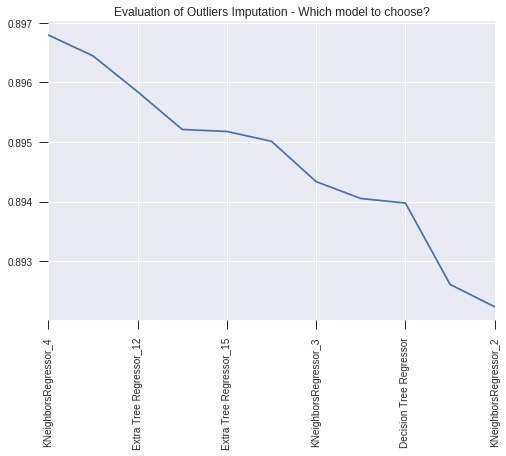

In [67]:
### Plotting the explained variance score #######
#################################################
outliers_imputed_df['test_explained_variance'].nlargest(20).plot(kind='line')
plt.xticks(rotation=90)
plt.title("Evaluation of Outliers Imputation - Which model to choose?")

plt.show()

##### which model to choose for outliers imputation?
1. Based on both explained variance and Mean Squred Error, we are choosing KNN with value 4 for Outlier imputation.
2. Other thing which we could also do, we can try top 3 outliers imputation models and could create feature ensembles like stacking as well

###### We are going to keep it simple to go by KNN = 4 for outliers imputation

In [68]:
###### OUTLIER IMPUTER ########################
###############################################
def treat_outliers(X, row_index, column_index) :
    X = make_outliers_null(X, row_index, column_index)
    
    #### Substituting the best estimator model which we got from above step #####
    outliers_imputer = IterativeImputer(random_state=0, estimator= KNeighborsRegressor(n_neighbors=4))
    X = outliers_imputer.fit_transform(X)
    imputed_df = pd.DataFrame(data=X, columns=numerical_features)
    return imputed_df, X;

In [69]:
########## Replacing the NAN of outliers with value imputed from nearest neighbor ##########
imputed_df, X = treat_outliers(X.values, row_index, column_index) 
imputed_df = pd.concat([imputed_df, y_df, extra_df], axis=1)
imputed_df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg   age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5  28.0   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2  14.0   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2  28.0   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0  28.0   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7  28.0   

   target age_category strength_category  
0   29.89    age11_100     strength21_40  
1   23.51    age11_100     strength21_40  
2   29.22    age11_100     strength21_40  
3   45.85    age11_100     strength41_60  
4   18.29    age11_100      strength0_20

In [70]:
##### Post imputation - it does not shows ANY NULL, meaning outliers are treated ########
imputed_df[imputed_df.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, target, age_category, strength_category]
Index: []

In [71]:
row_index_new, column_index_new, outlier_features_new = detect_outliers(X, imputed_df)
print("############### BEGIN ITERATION 2 - Outliers Imputation #############")
outlier_features_new

############### BEGIN ITERATION 2 - Outliers Imputation #############


['superplastic', 'age']

#### Slag and water are not showing in outliers, however superplastic and age are still showing in outlier list. Let us repeat the same steps for outlier treatment

In [72]:
############### ITERATION 2 - OUTLIERS ##########
#### Substituting Outliers with Null Values #####
X_outliers = make_outliers_null(X, row_index, column_index)
########################################################################################################
##### Invoke Impute outlier utility method which will evaluate multiple regressor models & #############
################ choose best model for imputing the outliers ###########################################
########################################################################################################
outliers_imputed_df, imputed_list = impute_outliers(X_outliers, y, outliers_imputers_dict, False)
########## Sorting based on Explained Variance ##################
outliers_imputed_df.sort_values('test_explained_variance', ascending=False).head(5)

fit_time  score_time  test_explained_variance  \
KNeighborsRegressor_4    0.025093    0.012235                 0.896794   
Extra Tree Regressor_6   0.095740    0.017699                 0.896445   
Extra Tree Regressor_12  0.185782    0.025830                 0.895843   
Extra Tree Regressor_10  0.212879    0.030494                 0.895210   
Extra Tree Regressor_15  0.170689    0.024684                 0.895177   

                         test_neg_mean_absolute_error  \
KNeighborsRegressor_4                       -3.751721   
Extra Tree Regressor_6                      -3.759585   
Extra Tree Regressor_12                     -3.763539   
Extra Tree Regressor_10                     -3.779003   
Extra Tree Regressor_15                     -3.772152   

                         test_neg_mean_squared_error   test_r2  
KNeighborsRegressor_4                     -28.809060  0.896077  
Extra Tree Regressor_6                    -28.968815  0.895558  
Extra Tree Regressor_12                   -29.156203  0.894956  
Extra Tree Regressor_10                   -29.292188  0.894328  
Extra Tree Regressor_15                   -29.333420  0.894261

#### Still KNN=4 holds good, so lets repeat the same step for transformation

In [73]:
########################### Iteration 2 ####################################################
########## Replacing the NAN of outliers with value imputed from nearest neighbor ##########
############################################################################################
imputed_df, X = treat_outliers(X, row_index, column_index) 
imputed_df = pd.concat([imputed_df, y_df, extra_df], axis=1)
imputed_df.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg   age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5  28.0   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2  14.0   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2  28.0   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0  28.0   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7  28.0   

   target age_category strength_category  
0   29.89    age11_100     strength21_40  
1   23.51    age11_100     strength21_40  
2   29.22    age11_100     strength21_40  
3   45.85    age11_100     strength41_60  
4   18.29    age11_100      strength0_20

In [74]:
############# Let us check again after Iteration 2 ##########################
row_index_new, column_index_new, outlier_features_new = detect_outliers(X, imputed_df)
print("############### Outliers check post Iteration 2 #############")
outlier_features_new

############### Outliers check post Iteration 2 #############


['superplastic', 'age']

In [75]:
######################################################################################
#### Utility plot to compare a feature before and after outlier treatement ###########
######################################################################################
def compare_outliers_plot(before_train_df, imputed_train_df, before_target, after_target, feature ):
    
    f, axes = plt.subplots(2, 2, figsize=(14, 6), sharex=False)

    sns.catplot(x=before_target, y=feature, kind="box", data=before_train_df,
                        ax=axes[0,0])

    sns.catplot(x=after_target, y=feature, kind="box", data=imputed_train_df,
                        ax=axes[0,1])
    
    sns.FacetGrid(train_df, hue=before_target, size=5) \
        .map(sns.kdeplot, feature, ax=axes[1,0]) \
        .add_legend()
    
    sns.FacetGrid(imputed_train_df, hue=after_target, size=5) \
        .map(sns.kdeplot, feature, ax=axes[1,1]) \
        .add_legend()

    axes[0,0].set_title("Box BEFORE Outlier treatement for " + feature)
    axes[0,1].set_title("Box AFTER Outlier treatement for " + feature)
    axes[1,0].set_title("KDE BEFORE Outlier treatement for " + feature)
    axes[1,1].set_title("KDE AFTER Outlier treatement for " + feature)

    plt.close(2)
    plt.close(3)
    plt.close(4)
    plt.close(5)
    plt.tight_layout()
    plt.show()

##################################################################################################
############### COMPARISON BEFORE AND AFTER OUTLIER TREATEMENT for superplastic ###################
##################################################################################################


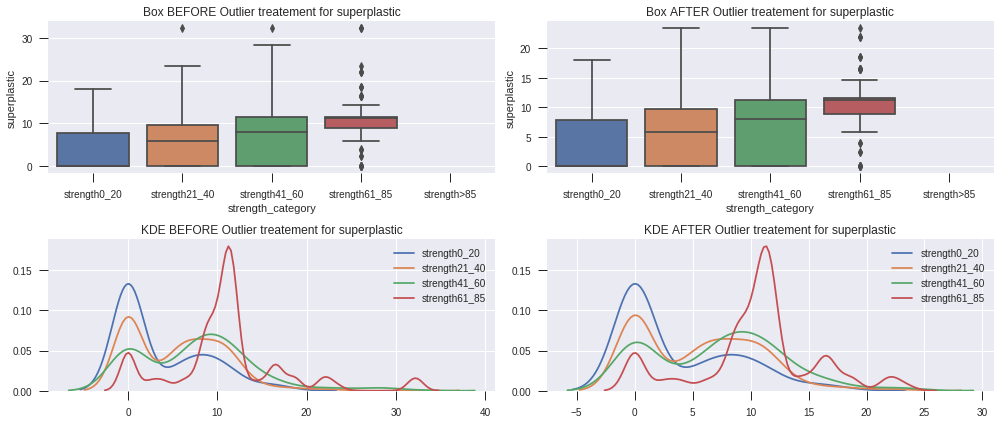

##################################################################################################
############### COMPARISON BEFORE AND AFTER OUTLIER TREATEMENT for age ###################
##################################################################################################


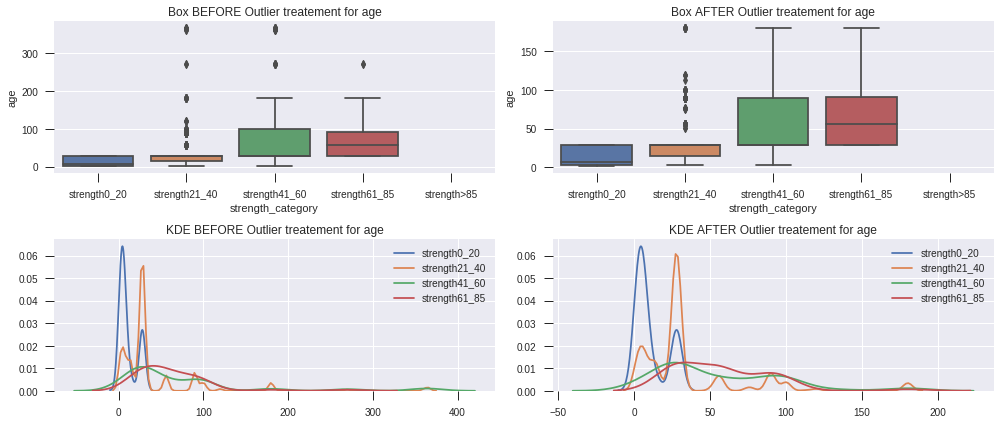

In [76]:
for feature in outlier_features_new:
    print("##################################################################################################")
    print("############### COMPARISON BEFORE AND AFTER OUTLIER TREATEMENT for %s ###################"%(feature))
    print("##################################################################################################")
    compare_outliers_plot(train_df, imputed_df, "strength_category", "strength_category", feature)
    

#### BEFORE & AFTER Outliers Imputation - Age and Superplastic :

###### AGE:-
1. Very clear outline reduction for the strength range between 40 and 85, which are the best values of strength. Outlier reduction in that range is indeed, a good sign.
2. Both Box plot and distribution plot suggests that, outlier do exist for strength ranging between 20-40 though reduced significantly. 

###### Superplastic:-
1. Outliers are completely gone for strength range between 40 and 85 in superplastic as well. Very evident from box and KDE plots.
2. Outliers are reduced for strength ranging 60-85, but still some values exist outside +1.5*IQR range though it looks improved from both box and KDE plots. 

###### what is more good sign is, BOTH Age and Superplastic features have good correlation with strength target variable and hence these significant reduction/improvement in outliers definitely going to contribute for better model generalization.

##################################################################################################
############### COMPARISON BEFORE AND AFTER OUTLIER TREATEMENT for slag ###################
##################################################################################################


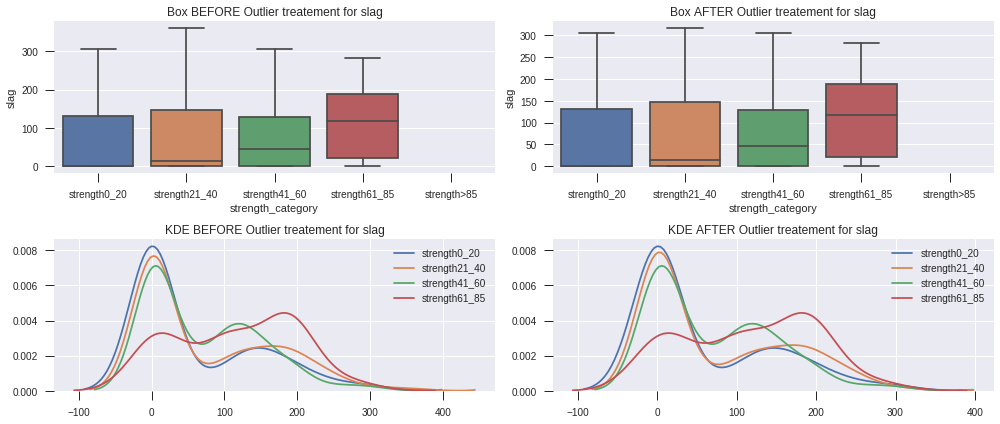

##################################################################################################
############### COMPARISON BEFORE AND AFTER OUTLIER TREATEMENT for water ###################
##################################################################################################


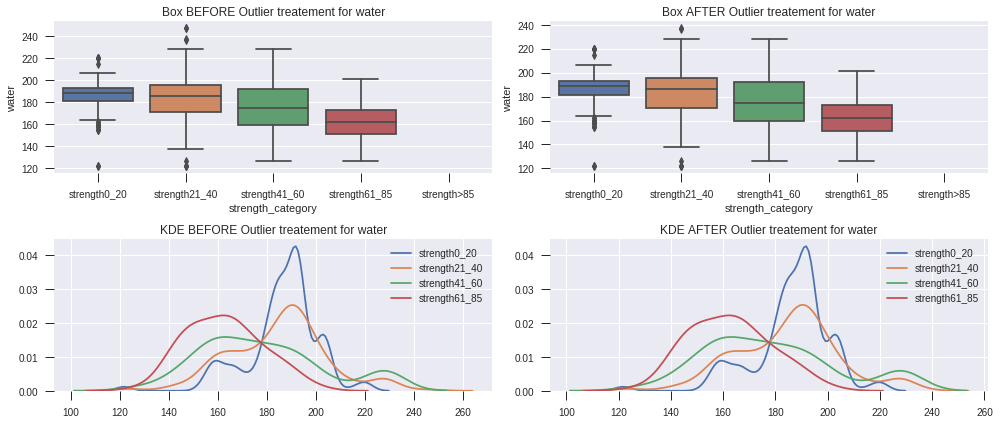

In [77]:
for feature in ['slag', 'water']:
    print("##################################################################################################")
    print("############### COMPARISON BEFORE AND AFTER OUTLIER TREATEMENT for %s ###################"%(feature))
    print("##################################################################################################")
    compare_outliers_plot(train_df, imputed_df, "strength_category", "strength_category", feature)

##### Like we saw for age and superplastic - Water and Slag also have significant reduction in outliers, and distribution looks better with tail reduced towards right. Any outlier reduction is a positive sign for us to retain the transformation before model development 

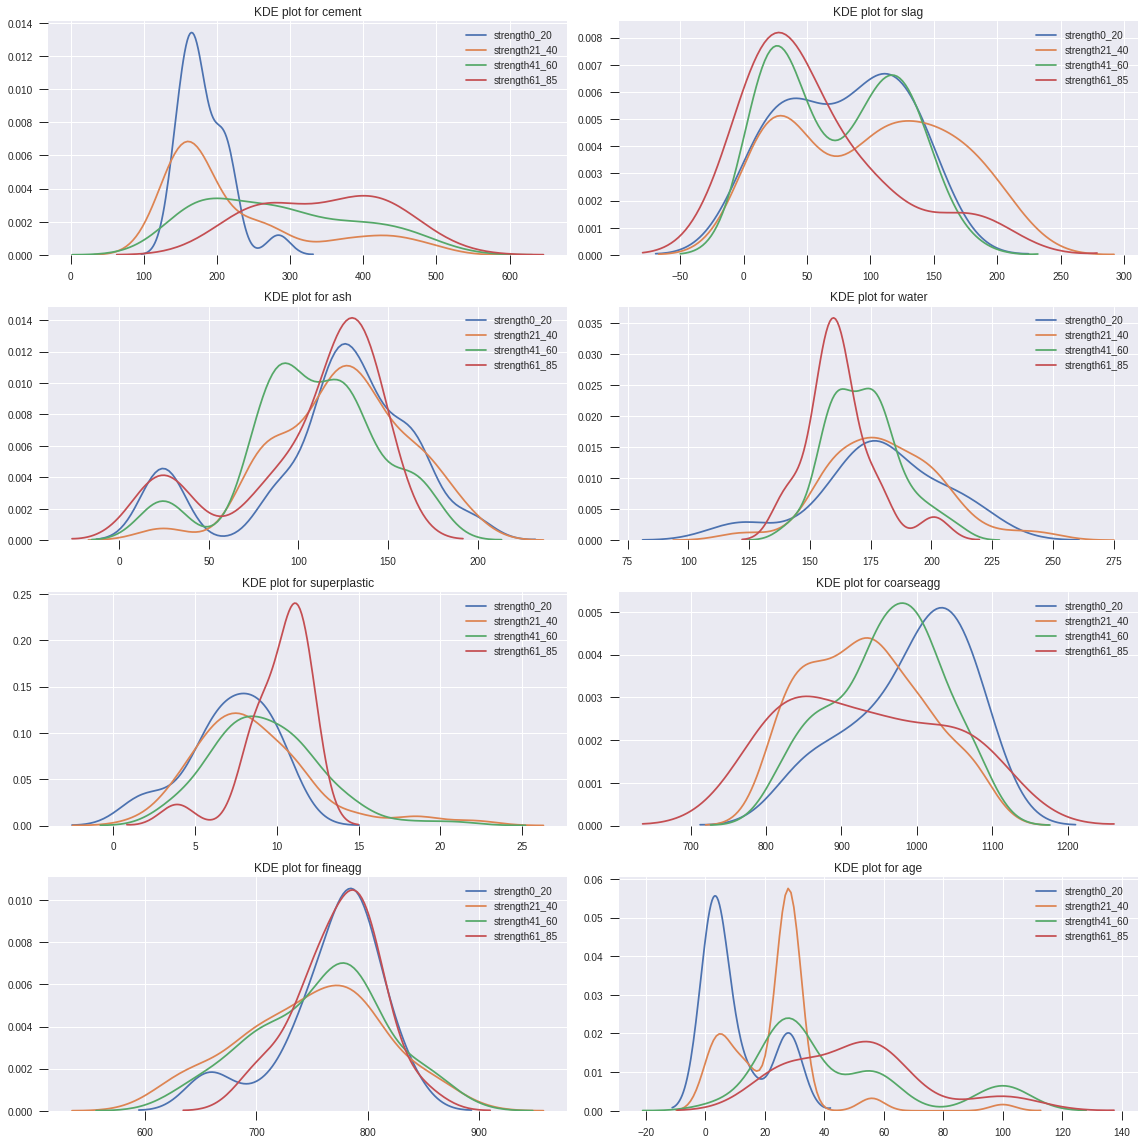

In [78]:
#######################################################################
#### REMEMBER FROM EDA ABOVE - DOMINANT PRESENCE OF ZEROs??? ##########
######### ASH - 55%, SLAG - 46%, SUPERPLASTIC - 37% of ZEROS  #########
######## Checking Distribution removing those ZERO value ROWS##########
#######################################################################
dist_plot_series(train_df.query('ash > 0 and superplastic > 0 and slag > 0')
                 ,numerical_features, 2, "strength_category")
plt.tight_layout()
plt.show()

#### Surprise - isn't it? 

When we remove the zero row values i.e. EXCLUDING ROWS WITH FEATURES ASH - 55%, SLAG - 46%, SUPERPLASTIC - 37% of ZEROS, we get a better distribution that indicates FOUR DISTINCT CLASSES OF STRENGTH. i.e., 
1. class 1 - Strength 0 to 20
2. class 2 - Strength 21 to 40
3. class 3 - Strength 41 to 60
4. class 4 - Strength 61 to 85

### Does it ring bells to convert this to MULTI CLASS CLASSIFICATION problem?
sure, why not? 

In [79]:
### before we do deep dive to model development, let us inspect zero value rows ####

grouped = train_df.query('ash == 0 and superplastic == 0 and slag == 0').groupby('strength_category')

########### Inspecting the group by results against STRENGTH feature #######
grouped['strength'].describe()

count       mean       std    min      25%    50%      75%  \
strength_category                                                               
strength0_20        66.0  14.626667  3.695097   6.27  11.9000  14.65  17.5400   
strength21_40      102.0  30.565980  5.785615  21.16  25.2775  31.30  35.6125   
strength41_60       33.0  48.107273  5.779640  41.05  42.4200  48.40  52.9100   
strength61_85        8.0  69.846250  4.304061  61.92  67.2600  70.64  72.5350   
strength>85          0.0        NaN       NaN    NaN      NaN    NaN      NaN   

                     max  
strength_category         
strength0_20       20.97  
strength21_40      40.86  
strength41_60      59.76  
strength61_85      74.99  
strength>85          NaN

In [80]:
########### Inspecting the group by results against AGE feature #######
grouped['age'].describe()

count        mean         std   min   25%    50%    75%  \
strength_category                                                            
strength0_20        66.0    9.424242    8.772440   1.0   3.0    7.0    7.0   
strength21_40      102.0   70.107843   90.094659   3.0  28.0   28.0   90.0   
strength41_60       33.0  124.545455  118.614420   3.0  28.0   90.0  180.0   
strength61_85        8.0  134.250000  104.790608  28.0  28.0  135.0  202.5   
strength>85          0.0         NaN         NaN   NaN   NaN    NaN    NaN   

                     max  
strength_category         
strength0_20        28.0  
strength21_40      365.0  
strength41_60      365.0  
strength61_85      270.0  
strength>85          NaN

#### Interesting to note - there are 209 rows with ALL ASH, SUPERPLASTIC, SLAG as ZERO. Out of 209, we have around 168 datapoints representing strength < 40. These rows cannot be simply ignored, we would need domain expertise around these 209 rows to know in details, why all of ash, superplastic and slag remain zero. We cannot take firm decision to treat like null values or outliers & impute on our assumptions without domain expertise - HIGHLY NOT RECOMMENDED. 

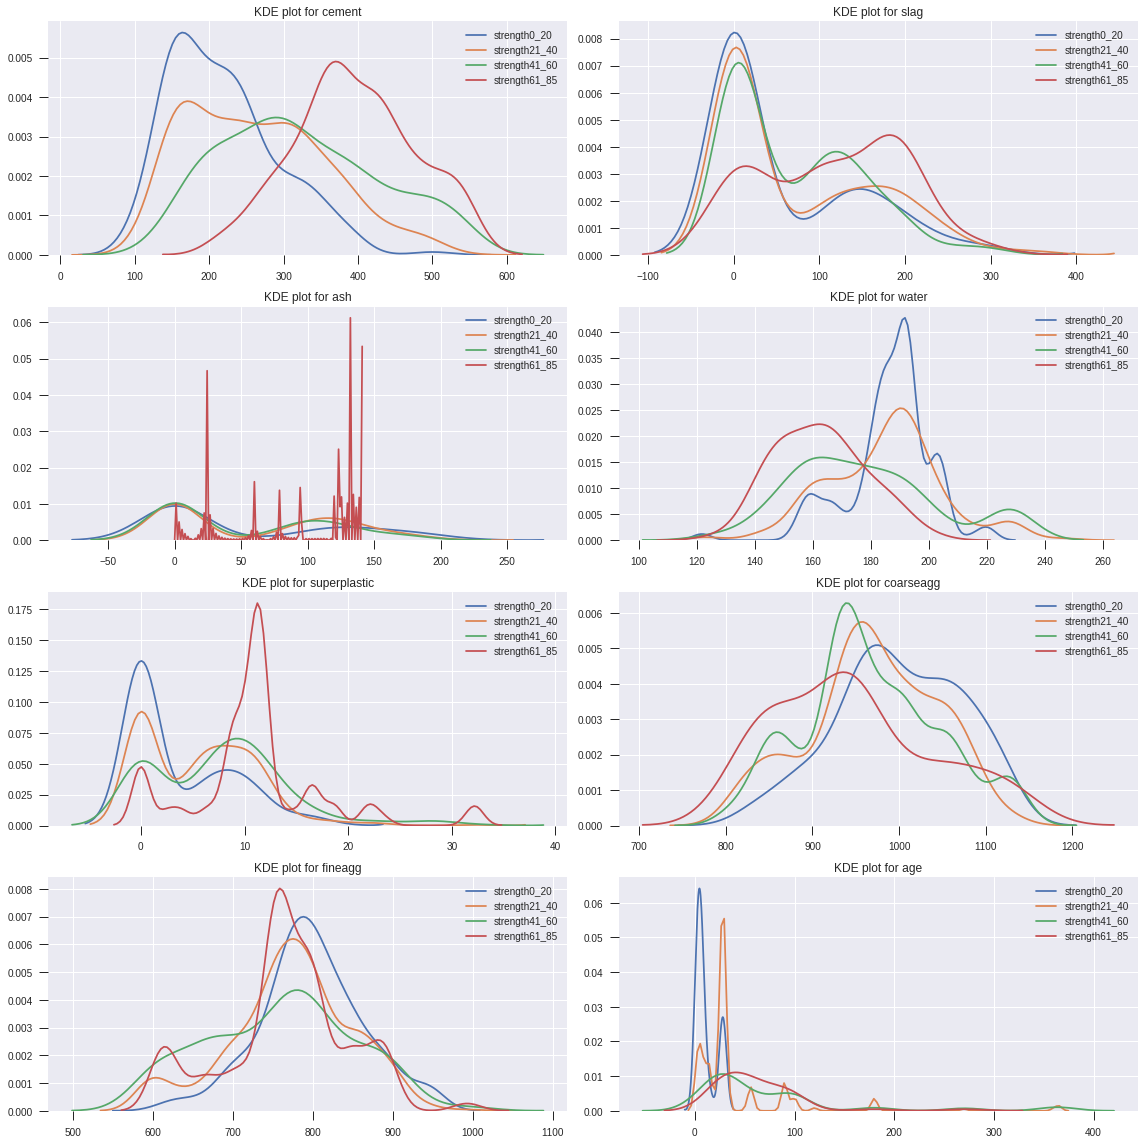

In [81]:
########################################################################
######## Checking Distribution INCLUDING those ZERO value ROWS##########
########################################################################
dist_plot_series(train_df,numerical_features, 2, "strength_category")
plt.tight_layout()
plt.show()

#### Still, this looks to be a potential candidate for MULTI CLASS CLASSIFICATION based on above distribution with class having its own almost nice looking distribution. For 'ash' alone, there seems to be somthing going on with the distribution - let us inspect 'ash' feature

Recollecting ash's correlation with other features :
1. (ash, cement)	-0.397467
2. (ash, superplastic)	0.377503
3. (ash, strength)	-0.105755
4. (ash, age)	-0.154371
5. (ash, slag)	-0.323580

Not a strong predictor for the target, however this feature seem to inject some collinearity to other features.

In [82]:
########### Inspecting ASH feature further #######

grouped_ash = train_df.groupby('strength_category')
grouped_ash['ash'].describe()

count       mean        std  min  25%    50%      75%  \
strength_category                                                          
strength0_20       207.0  53.747343  70.555532  0.0  0.0   0.00  121.750   
strength21_40      468.0  61.162179  63.964266  0.0  0.0  47.75  119.200   
strength41_60      268.0  52.597761  60.518891  0.0  0.0   0.00  100.425   
strength61_85       87.0  22.622989  47.021405  0.0  0.0   0.00    0.000   
strength>85          0.0        NaN        NaN  NaN  NaN    NaN      NaN   

                     max  
strength_category         
strength0_20       200.1  
strength21_40      195.0  
strength41_60      174.7  
strength61_85      141.0  
strength>85          NaN

#### there lies the problem, median is ZERO in strength between 0 and 20, for all values ABOVE 40. No wonder, distribution of ash looked weird. Based on what I am seeing, my guess would be, if we run any feature importance/selection technique - this might turn out as the LEAST importance feature.

In [83]:
##### Inspecting the datapoints if this can be converted to classification problem #####
grouped_ash['strength'].describe()

count       mean       std    min      25%     50%     75%  \
strength_category                                                               
strength0_20       207.0  13.901691  4.137224   2.33  10.9800  14.200  17.355   
strength21_40      468.0  31.478547  5.805653  21.02  26.0600  32.025  36.800   
strength41_60      268.0  49.394664  5.695855  41.05  44.2625  49.090  54.145   
strength61_85       87.0  69.484138  5.906744  61.07  64.9000  67.870  74.180   
strength>85          0.0        NaN       NaN    NaN      NaN     NaN     NaN   

                     max  
strength_category         
strength0_20       20.97  
strength21_40      40.93  
strength41_60      60.95  
strength61_85      82.60  
strength>85          NaN

### Symptoms of Multi-class classification & APPROACH to proceed?

##### Answer would be YES. We can club the class for strength > 40 as ONE, strength between 20-40 as TWO and strength < 20 as THREE, creating multi-class classification with THREE TARGETS to predict first & then train regression for each of the classification to predict the strength. That would be very ideal approach to make this model generalized instead of we creating regression directly

In [117]:
#### Grouping by Static binning of age category #####
imputed_df.groupby('age_category').count()

cement  slag  ash  water  superplastic  coarseagg  fineagg  age  \
age_category                                                                    
age0_10          262   262  262    262           262        262      262  262   
age11_100        706   706  706    706           706        706      706  706   
age101_250        29    29   29     29            29         29       29   29   
age>250           33    33   33     33            33         33       33   33   

              target  strength_category  
age_category                             
age0_10          262                262  
age11_100        706                706  
age101_250        29                 29  
age>250           33                 33

In [130]:
from sklearn.preprocessing import KBinsDiscretizer

###############################################################
##### Grouping by K-means binning of Age feature ##############
###### this bins based on nearest data point ##################
###############################################################
discrete_bins_age = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
imputed_df['age_kbins'] = discrete_bins_age.fit_transform((imputed_df['age'].values).reshape(-1,1))
imputed_df.groupby('age_kbins').count()

cement  slag  ash  water  superplastic  coarseagg  fineagg  age  \
age_kbins                                                                    
0.0           750   750  750    750           750        750      750  750   
1.0           114   114  114    114           114        114      114  114   
2.0           140   140  140    140           140        140      140  140   
3.0            26    26   26     26            26         26       26   26   

           target  age_category  strength_category  
age_kbins                                           
0.0           750           750                750  
1.0           114           114                114  
2.0           140           140                140  
3.0            26            26                 26

##### NOTE :
we will retain age_kbins as transformed 'Age' feature. We will remove age and static 'age_category' feature while model development

### Adding NEW INTERACTION FEATURES - POLYNOMIAL FEATURES
we will evaluate which degree is best suited by fitting against linear regression model and choosing the degree that has lower RMSE score

In [161]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

######################################################################################
############## Evaluation of Polynomial features - choose the best degree ############
######################################################################################

degrees = [2,3,4,5,6,7,8]
linear_reg = LinearRegression(normalize=True)
poly_eval_rmse = []

for degree in degrees :
    poly_features = PolynomialFeatures(degree=degree, interaction_only=False,include_bias=False)
    interaction_feat_df = imputed_df[numerical_features]

    ##### CHOOSING DEGREE AS 3, BASED ON EDA ABOVE - degree 3 looked more generalized and NOT OVERFITTING #######
    #print((interaction_feat_df[numerical_features].values).shape)
    X_interaction = poly_features.fit_transform((interaction_feat_df.values))
    #print(X_interaction.shape)
    poly_df = pd.DataFrame(X_interaction)
    poly_df = poly_df.add_prefix('interaction_')
    #print((poly_df.values).shape)
    interaction_feat_df = pd.concat([interaction_feat_df, poly_df], axis = 1)
    X_poly = interaction_feat_df.values
    #print(X_poly.shape, X.shape, y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)
    linear_reg.fit(X_train, y_train)
    
    y_poly_predict = linear_reg.predict(X_test)
    poly_rmse = np.sqrt(mean_squared_error(y_test, y_poly_predict))
    poly_eval_rmse = poly_eval_rmse + [poly_rmse]
    
    

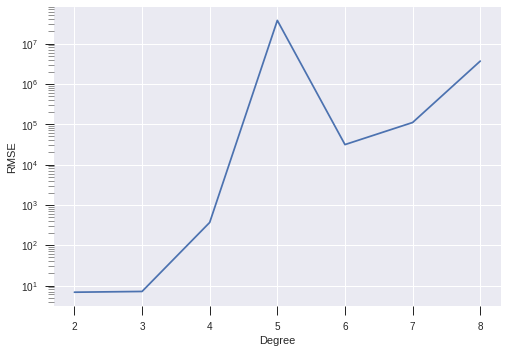

In [171]:
###################################################################
#### Let us plot the RMSE and see which degree has lower RMSE #####
###################################################################
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(degrees, poly_eval_rmse)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')
plt.show()

#### Very evident from above plot that degree 3 has lower RMSE score. Also to be noted, even from our EDAs above - Order 3 looked more generalized compared to higher degrees of polynomial which would cause overfitting

In [183]:
#########################################################################################################
#### Let us transform numerical features of our dataframe to degree 3 - based on above optimization #####
#########################################################################################################
poly_features = PolynomialFeatures(degree=3, interaction_only=True,include_bias=False)

#########################################################################
#### NOTE : WE WILL INCLUDE ONLY INTERACTION FEATURES ###################
################# i.e. EXCLUDE X2, X3 etc. ##############################
########### AND INCLUDE ONLY X1X2, X1X3 etc. ############################
#########################################################################
#Reason: That would add unnecessary collinearity with original feature ##
#########################################################################

interaction_feat_df = imputed_df[numerical_features]

X_interaction = poly_features.fit_transform((interaction_feat_df.values))

poly_df = pd.DataFrame(X_interaction)
poly_df = poly_df.add_prefix('interaction_')

interaction_feat_df = pd.concat([y_df, extra_df,interaction_feat_df, poly_df], axis = 1)
interaction_feat_df.head()

target age_category strength_category  cement   slag    ash  water  \
0   29.89    age11_100     strength21_40   141.3  212.0    0.0  203.5   
1   23.51    age11_100     strength21_40   168.9   42.2  124.3  158.3   
2   29.22    age11_100     strength21_40   250.0    0.0   95.7  187.4   
3   45.85    age11_100     strength41_60   266.0  114.0    0.0  228.0   
4   18.29    age11_100      strength0_20   154.8  183.4    0.0  193.3   

   superplastic  coarseagg  fineagg  ...  interaction_82  interaction_83  \
0           0.0      971.8    748.5  ...           0.000           0.000   
1          10.8     1080.8    796.2  ...     1847778.912     1361215.368   
2           5.5      956.9    861.2  ...      986276.830      887638.840   
3           0.0      932.0    670.0  ...           0.000           0.000   
4           9.1     1047.4    696.7  ...     1842408.022     1225516.201   

   interaction_84  interaction_85  interaction_86  interaction_87  \
0            0.00    1.480243e+08      5537316.40      4264953.00   
1        23934.96    1.362224e+08      2395268.96      1764538.44   
2        28859.60    1.544330e+08      5021045.68      4518888.64   
3            0.00    1.423723e+08      5949888.00      4277280.00   
4        49252.84    1.410556e+08      5668947.76      3770819.08   

   interaction_88  interaction_89  interaction_90  interaction_91  
0           0.000            0.00            0.00     20366984.40  
1     9293755.968       163416.96       120385.44     12047461.44  
2     4532452.540       147362.60       132624.80     23074303.84  
3           0.000            0.00            0.00     17484320.00  
4     6640484.578       266877.52       177519.16     20432260.24  

[5 rows x 103 columns]

In [187]:
interaction_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Columns: 103 entries, target to interaction_91
dtypes: category(2), float64(101)
memory usage: 815.3 KB


##### From 8 features --> We NOW HAVE 103 FEATURES, 101 numerical features and 2 categorical features. What are the next steps?
### FEATURE EXTRACTION - Complete, FEATURE SELECTION Next!

1. Let us calculate the VIF score to verify the multicollinearity
2. Now that, dimensions getting increased - we could very well leverage PCA, LDA, TSNE techniques to get rid of collinear redundant features
3. Apply some feature selection techniques to calculate feature importance
4. Hyperparameter tunings of different modes
5. Evaluate each of the best models

In [188]:
#### checkpoint - what are the features that we have? ############
##################################################################

numerical_features_interaction, categorical_features_interaction,target_interaction, null_features = extract_feature_types(interaction_feat_df, 'target')
print("\n############### Numerical features are ############### \n  %s \n"%(numerical_features_interaction))
print("############### Categorical features are ############### \n  %s \n"%(categorical_features_interaction))
print("############### Features having NULL values ############### \n \n %s \n"%(null_features))
print("############### Target/y############### \n  %s "%(target_interaction))

**** Adding categorical feature **** 
age_category
**** Adding categorical feature **** 
strength_category

############### Numerical features are ############### 
  ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age', 'interaction_0', 'interaction_1', 'interaction_2', 'interaction_3', 'interaction_4', 'interaction_5', 'interaction_6', 'interaction_7', 'interaction_8', 'interaction_9', 'interaction_10', 'interaction_11', 'interaction_12', 'interaction_13', 'interaction_14', 'interaction_15', 'interaction_16', 'interaction_17', 'interaction_18', 'interaction_19', 'interaction_20', 'interaction_21', 'interaction_22', 'interaction_23', 'interaction_24', 'interaction_25', 'interaction_26', 'interaction_27', 'interaction_28', 'interaction_29', 'interaction_30', 'interaction_31', 'interaction_32', 'interaction_33', 'interaction_34', 'interaction_35', 'interaction_36', 'interaction_37', 'interaction_38', 'interaction_39', 'interaction_40', 'interaction_41', 'inter

### Variance Inflation Factor(VIF) Technique for Inspecting Multi Collinearity 

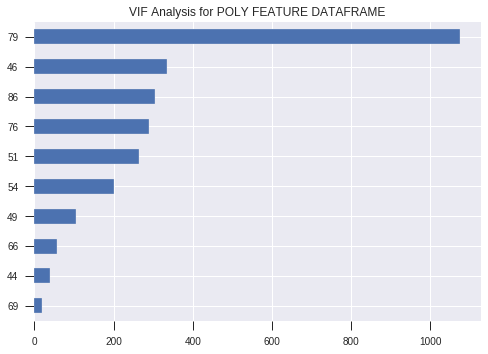

In [216]:
#########################################################################################################
#### Let us calculate VIF score for new dataframe that we got from polynomial interaction features ######
#########################################################################################################

from statsmodels.stats.outliers_influence import variance_inflation_factor

### variance inflation factor expects a constant towards end ######
X_dummy = interaction_feat_df[numerical_features_interaction].assign(const=1)

#### for a new dataframe ######
vif_df_poly = pd.DataFrame()
vif_df_poly["vif_score"] = [variance_inflation_factor(X_dummy.values, i) for i in range(X_dummy.shape[1])]
vif_df_poly["feature_name"] = X_dummy.columns

vif_df_poly['vif_score'].nsmallest(10).plot(kind='barh')
plt.title("VIF Analysis for POLY FEATURE DATAFRAME")
plt.show()

#### Surprised of such a high values? Don't be. Since we did polynomial interaction transformation to dataset, this is expected and does not reveal the real multi collinearity. Let us try standard scaler() on this input data and retry

(1030, 101)


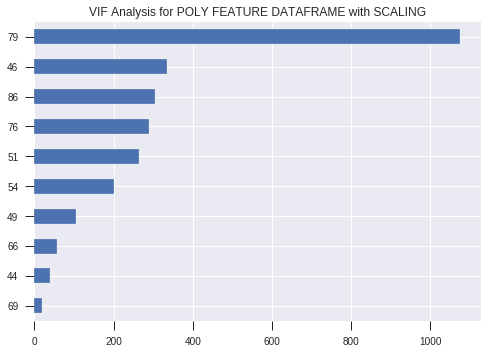

In [235]:
#########################################################################################################
#### Let us calculate VIF score for new dataframe that we got from polynomial interaction features ######
####################### WITH STANDARD SCALER THIS TIME ##################################################
#########################################################################################################

from statsmodels.stats.outliers_influence import variance_inflation_factor

### variance inflation factor expects a constant towards end ######

X_dummy = interaction_feat_df[numerical_features_interaction].assign(const=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummy)
print(X_scaled.shape)
#### for a new dataframe ######
vif_df_poly_scaled = pd.DataFrame()
vif_df_poly_scaled["vif_score"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
vif_df_poly_scaled["feature_name"] = X_dummy.columns

vif_df_poly_scaled['vif_score'].nsmallest(10).plot(kind='barh')
plt.title("VIF Analysis for POLY FEATURE DATAFRAME with SCALING")
plt.show()

#### SAME RESULT for poly fit data. NOT SURE whether VIF score would stay high due to interaction features constructed using polynomial features, which is intended. We would need to run this dataset separately against regression algorithms and evaluate the performance

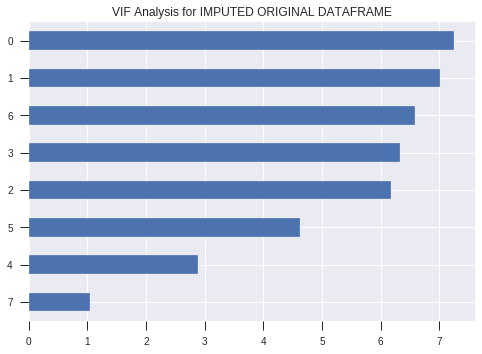

In [217]:
#########################################################################################################
#### Let us calculate VIF score for actual dataframe which had original features ########################
#########################################################################################################
from statsmodels.stats.outliers_influence import variance_inflation_factor

### variance inflation factor expects a constant towards end ######
X_dummy = imputed_df[numerical_features].assign(const=1)

#### for a new dataframe ######
vif_df = pd.DataFrame()
vif_df["vif_score"] = [variance_inflation_factor(X_dummy.values, i) for i in range(X_dummy.shape[1])]
vif_df["feature_name"] = X_dummy.columns

vif_df['vif_score'].nsmallest(8).plot(kind='barh')
plt.title("VIF Analysis for IMPUTED ORIGINAL DATAFRAME")
plt.show()

In [231]:
######################################################################################
#### ONLY AGE , SUPERPLASTIC, COARSEAGG are below usual treshold of 5 VIF score ######
################ This is surprising indeed ###########################################
######################################################################################
vif_df.query('vif_score < 8')[['feature_name', 'vif_score']].sort_values(by='vif_score')

feature_name  vif_score
7           age   1.044482
4  superplastic   2.880385
5     coarseagg   4.620783
2           ash   6.166805
3         water   6.333077
6       fineagg   6.587171
1          slag   7.015018
0        cement   7.247892

#### To be noted, 5 of the features - ash, water, fineagg, slag, cement are staying close to the upper limit of VIF score (around 5 or 6), hence we would need to evaluate this dataset with combination of :
1. Only age, superplastic and coarseagg - Statistically, these 3 qualify for perfect independent variables
2. First combination plus, ash,water and fineagg 
3. All 8 features

(1030, 9)


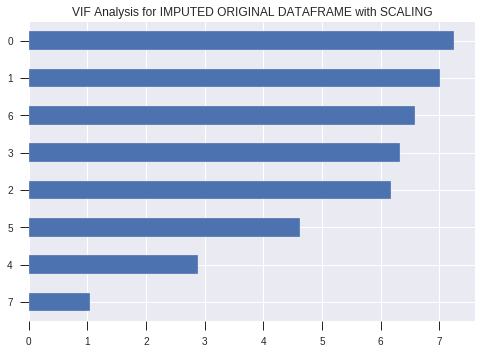

feature_name  vif_score
7           age   1.044482
4  superplastic   2.880385
5     coarseagg   4.620783
2           ash   6.166805
3         water   6.333077
6       fineagg   6.587171
1          slag   7.015018
0        cement   7.247892

In [241]:
#########################################################################################################
#### Let us calculate VIF score for actual dataframe which had original features ########################
#########################################################################################################
from statsmodels.stats.outliers_influence import variance_inflation_factor

### variance inflation factor expects a constant towards end ######
X_dummy = imputed_df[numerical_features].assign(const=1)
scaler = StandardScaler()
X_scaled_actual = scaler.fit_transform(X_dummy)
print(X_scaled_actual.shape)

#### for a new dataframe ######
vif_df_scaled = pd.DataFrame()
vif_df_scaled["vif_score"] = [variance_inflation_factor(X_scaled_actual, i) for i in range(X_scaled_actual.shape[1])]
vif_df_scaled["feature_name"] = X_dummy.columns

vif_df_scaled['vif_score'].nsmallest(10).plot(kind='barh')
plt.title("VIF Analysis for IMPUTED ORIGINAL DATAFRAME with SCALING")
plt.show()
vif_df_scaled.query('vif_score < 8')[['feature_name', 'vif_score']].sort_values(by='vif_score')

#### NOTE: Scaling or NO scaling of input data DID NOT HAVE ANY DIFFERENCE in VIF score. I am going to retain all the features as it is just around the border value of 7.

In [283]:
############################################################################################################
########################### Defining Utility function for evaluation regression model ######################
############################################################################################################
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

def evaluate_regression_model (coefficient_list, y_test, y_pred):
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    ev_score=explained_variance_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - float(len(y_test)-1)/(len(y_test)-len(coefficient_list)-1)*(1 - r2)
    
    
    return mae, mse, rmse,ev_score, r2, adj_r2

### Feature Selection, Model Implementation, Optimization and Evaulation 

#### Ridge Regression : Original Dataset

In [341]:
#### Importing needed packages for Ridge and Grid Search ########

from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV

X_ridge = imputed_df[numerical_features]
X_train, X_test, y_train, y_test = train_test_split(X_ridge, y, test_size=0.3)


############################################################################
#### Hyper Parameter Tuning of RIDGE - Original/Imputed Dataset ############
############################################################################

n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , Ridge(random_state=42))
])

param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [Ridge(random_state=42)],
     'model_gs__alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1],   
     'model_gs__random_state': [42]
    }
]

#choosing njobs as -1 to have parallel processing
grid1 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)


In [342]:
#### Fitting ridge #########################
ridge_regression = grid1.fit(X_train, y_train)
y_pred_ridge = ridge_regression.predict(X_test)
ridge_regression.best_estimator_, ridge_regression.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.2s finished


(Pipeline(memory=None,
          steps=[('scaler',
                  QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                      n_quantiles=1000,
                                      output_distribution='uniform',
                                      random_state=None, subsample=100000)),
                 ('model_gs',
                  Ridge(alpha=0.1, copy_X=True, fit_intercept=True,
                        max_iter=None, normalize=False, random_state=42,
                        solver='auto', tol=0.001))],
          verbose=False), 0.8000944670062017)

In [343]:
######## Evaluating Ridge Model #############
mae, mse, rmse,ev_score, r2, adj_r2 = evaluate_regression_model (ridge_regression.best_estimator_[1].coef_, y_test, y_pred_ridge)
evaluation_regression_df = pd.DataFrame(np.array([["Ridge_Basic",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

name               mae                mse               rmse  \
0  Ridge_Basic  5.50514478580613  51.69750719118065  7.190097856857071   

   explained_variance                  r2              adj_r2  
0  0.8204203590964072  0.8183853951262887  0.8135423389963231

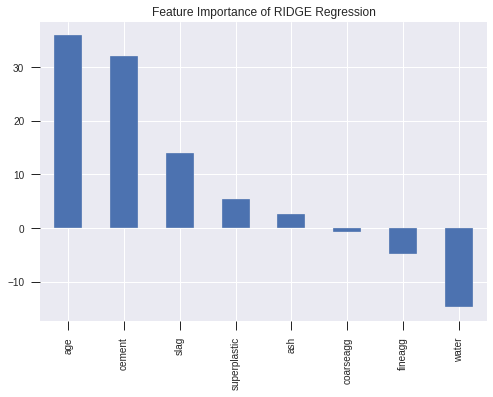

In [344]:
#####################################################################
#### Plotting the Feature importance - RIDGE REGRESSION #############
#####################################################################
coef_df = pd.DataFrame(ridge_regression.best_estimator_[1].coef_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(10).plot(kind='bar')
plt.title("Feature Importance of RIDGE Regression")
plt.show()

In [482]:
def consolidate_models_features(best_fit_model, coefficients, model_list, feature_coef_df, columns, key):
        
    model_list = model_list + [best_fit_model]
    temp_df = pd.DataFrame([coefficients], columns=columns, index=[key])
    feature_coef_df = pd.concat([feature_coef_df, temp_df])
    
    return model_list, feature_coef_df

In [510]:
model_list = []
feature_stack_df = pd.DataFrame()
model_list, feature_stack_df = consolidate_models_features(ridge_regression.best_estimator_[1],
                                                           ridge_regression.best_estimator_[1].coef_,
                                                           model_list, feature_stack_df, 
                                                           X_train.columns.values, "ridge_basic")
print("##############################################################################")
print("###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############")
print("##############################################################################")
feature_stack_df

##############################################################################
###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############
##############################################################################


cement       slag       ash      water  superplastic  \
ridge_basic  32.143301  13.961789  2.632147 -14.712805      5.408448   

             coarseagg   fineagg        age  
ridge_basic  -0.682517 -4.773558  35.964174

#### Ridge Regression Evaluation in Hyperparameter Tuning - 82% of Explained Variance, Adjusted R2 Score of 0.82, AND rmse of 7.1 Definite room of improvements for the model. Let us proceed to next model tuning.

#### Ridge Regression : POLYFIT Dataset

In [345]:
############################################################################
#### Hyper Parameter Tuning of RIDGE - POLYFIT Dataset #####################
############################################################################

X_ridge = interaction_feat_df[numerical_features_interaction]

X_train, X_test, y_train, y_test = train_test_split(X_ridge, y, test_size=0.3)
print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , Ridge(random_state=42))
])

param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [Ridge(random_state=42)],
     'model_gs__alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1],   
     'model_gs__random_state': [42]
    }
]

#choosing njobs as -1 to have parallel processing
grid2 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
ridge_regression_poly = grid2.fit(X_train, y_train)
y_pred_ridge = ridge_regression_poly.predict(X_test)
ridge_regression_poly.best_estimator_, ridge_regression_poly.best_score_

(721, 100)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.1s finished


(Pipeline(memory=None,
          steps=[('scaler',
                  QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                      n_quantiles=1000,
                                      output_distribution='uniform',
                                      random_state=None, subsample=100000)),
                 ('model_gs',
                  Ridge(alpha=0.05, copy_X=True, fit_intercept=True,
                        max_iter=None, normalize=False, random_state=42,
                        solver='auto', tol=0.001))],
          verbose=False), 0.856700486411378)

In [346]:
######## Evaluating Ridge Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (ridge_regression_poly.best_estimator_[1].coef_, y_test, y_pred_ridge)
evaluation_regression_df_temp = pd.DataFrame(np.array([["Ridge_Poly",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

name                mae                mse                rmse  \
0  Ridge_Basic   5.50514478580613  51.69750719118065   7.190097856857071   
0   Ridge_Poly  4.646336817085489  37.01093654956937  6.0836614427143605   

   explained_variance                  r2              adj_r2  
0  0.8204203590964072  0.8183853951262887  0.8135423389963231  
0  0.8708775443303565  0.8697635488179183  0.8071498703649944

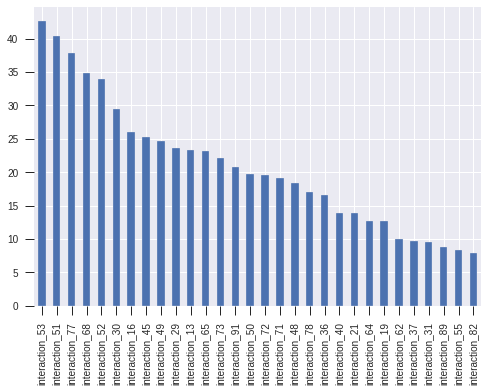

In [347]:
#########################################################################
#### Plotting the Feature importance - RIDGE REGRESSION for POLY FIT ####
#########################################################################
coef_df = pd.DataFrame(ridge_regression_poly.best_estimator_[1].coef_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of RIDGE Regression WITH POLY")
plt.show()

#### Ridge Regression WITH POLYNOMIAL Features Evaluation in Hyperparameter Tuning :

It did look like, model performed better with 87% of Explained Variance. However, there is huge gap between R2(0.87) and adjusted R2(0.80) which indicates that model is suffering from collinearity problem. RMSE is still around 6, which indicates that there is definite room for improvement

#### Lasso Regression : Original Dataset

In [348]:
from sklearn.linear_model import Lasso

############################################################################
#### Hyper Parameter Tuning of LASSO - Imputed Dataset #####################
############################################################################

X_lasso = imputed_df[numerical_features]

X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.3)
print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , Lasso(random_state=42))
])

param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [Lasso(random_state=42)],
     'model_gs__alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1],   
     'model_gs__random_state': [42]
    }
]

#choosing njobs as -1 to have parallel processing
grid3 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
lasso_regression = grid3.fit(X_train, y_train)
y_pred_ridge = lasso_regression.predict(X_test)
lasso_regression.best_estimator_, lasso_regression.best_score_

(721, 8)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.2s finished


(Pipeline(memory=None,
          steps=[('scaler',
                  QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                      n_quantiles=1000,
                                      output_distribution='uniform',
                                      random_state=None, subsample=100000)),
                 ('model_gs',
                  Lasso(alpha=0.01, copy_X=True, fit_intercept=True,
                        max_iter=1000, normalize=False, positive=False,
                        precompute=False, random_state=42, selection='cyclic',
                        tol=0.0001, warm_start=False))],
          verbose=False), 0.7999407618771783)

In [349]:
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (lasso_regression.best_estimator_[1].coef_, y_test, y_pred_ridge)
evaluation_regression_df_temp = pd.DataFrame(np.array([["Lasso_Basic",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

name                mae                mse                rmse  \
0  Ridge_Basic   5.50514478580613  51.69750719118065   7.190097856857071   
0  Lasso_Basic   5.40141669099927  49.99351155312617   7.070608994501546   
0   Ridge_Poly  4.646336817085489  37.01093654956937  6.0836614427143605   

   explained_variance                  r2              adj_r2  
0  0.8204203590964072  0.8183853951262887  0.8135423389963231  
0  0.8153982728302221  0.8153059849873698  0.8103808112536997  
0  0.8708775443303565  0.8697635488179183  0.8071498703649944

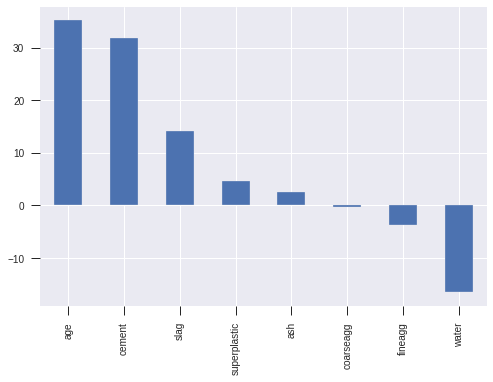

In [350]:
#########################################################################
#### Plotting the Feature importance - LASSO REGRESSION IMPUTED DATA ####
#########################################################################
coef_df = pd.DataFrame(lasso_regression.best_estimator_[1].coef_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of LASSO Regression")
plt.show()

In [511]:
model_list, feature_stack_df = consolidate_models_features(lasso_regression.best_estimator_[1],
                                                           lasso_regression.best_estimator_[1].coef_,
                                                           model_list, feature_stack_df, 
                                                           X_train.columns.values, "lasso_basic")
print("##############################################################################")
print("###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############")
print("##############################################################################")
feature_stack_df

##############################################################################
###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############
##############################################################################


cement       slag       ash      water  superplastic  \
ridge_basic  32.143301  13.961789  2.632147 -14.712805      5.408448   
lasso_basic  31.782499  14.239748  2.538990 -16.471462      4.693180   

             coarseagg   fineagg        age  
ridge_basic  -0.682517 -4.773558  35.964174  
lasso_basic  -0.301277 -3.722536  35.245700

#### Lasso Regression Features Evaluation in Hyperparameter Tuning :

RMSE is around 6, Explained variance and adjusted R2 are around 82% which is still not good enough. However, we are storing all these trained models in one group, so that we can use for stacking in end.

In [353]:
############################################################################
#### Hyper Parameter Tuning of LASSO - POLYFIT Dataset #####################
############################################################################

X_lasso_poly = interaction_feat_df[numerical_features_interaction]

X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.3)
print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , Lasso(random_state=42))
])

param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [Lasso(random_state=42)],
     'model_gs__alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1],   
     'model_gs__random_state': [42]
    }
]

#choosing njobs as -1 to have parallel processing
grid4 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
lasso_regression_poly = grid4.fit(X_train, y_train)
y_pred_ridge = lasso_regression_poly.predict(X_test)
lasso_regression_poly.best_estimator_, lasso_regression_poly.best_score_

(721, 8)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.2s finished


(Pipeline(memory=None,
          steps=[('scaler',
                  QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                      n_quantiles=1000,
                                      output_distribution='uniform',
                                      random_state=None, subsample=100000)),
                 ('model_gs',
                  Lasso(alpha=0.01, copy_X=True, fit_intercept=True,
                        max_iter=1000, normalize=False, positive=False,
                        precompute=False, random_state=42, selection='cyclic',
                        tol=0.0001, warm_start=False))],
          verbose=False), 0.8057148458802686)

#### Lasso Regression : Polyfit Dataset

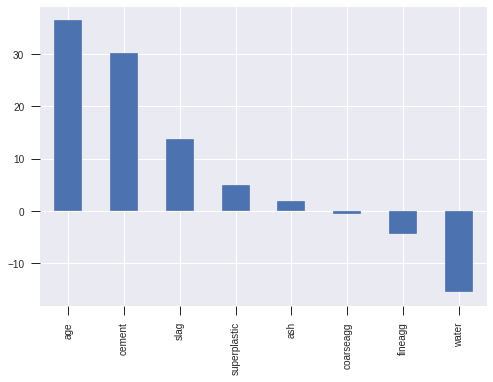

name                mae                 mse                rmse  \
0  Ridge_Basic   5.50514478580613   51.69750719118065   7.190097856857071   
0  Lasso_Basic   5.40141669099927   49.99351155312617   7.070608994501546   
0   Ridge_Poly  4.646336817085489   37.01093654956937  6.0836614427143605   
0   Lasso_Poly  5.659036389184505  52.807299808916426   7.266863134043218   

   explained_variance                  r2              adj_r2  
0  0.8204203590964072  0.8183853951262887  0.8135423389963231  
0  0.8153982728302221  0.8153059849873698  0.8103808112536997  
0  0.8708775443303565  0.8697635488179183  0.8071498703649944  
0  0.8159030804481799   0.808518954577864  0.8034127933666071

In [354]:
#########################################################################
#### Plotting the Feature importance - LASSO REGRESSION POLYFIT DATA ####
#########################################################################
coef_df = pd.DataFrame(lasso_regression_poly.best_estimator_[1].coef_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of LASSO Regression WITH POLYFIT FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (lasso_regression_poly.best_estimator_[1].coef_, y_test, y_pred_ridge)
evaluation_regression_df_temp = pd.DataFrame(np.array([["Lasso_Poly",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

#### Lasso Regression WITH POLYNOMIAL Features Evaluation in Hyperparameter Tuning :

Model does not suffer from collinearity like Ridge Polynomial, however RMSE is still around 7. Have not reduced.

#### Elasticnet Regression : Original Dataset

In [367]:
#################################################################################
#### Hyper Parameter Tuning of ELASTICNET - Imputed Dataset #####################
#################################################################################
from sklearn.linear_model import ElasticNet

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , ElasticNet(random_state=42))
])

param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [ElasticNet(random_state=42)],
     'model_gs__alpha' : [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1],   
     'model_gs__l1_ratio' : [0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 1]
    }
]

#choosing njobs as -1 to have parallel processing
grid5 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
elastic_regression = grid5.fit(X_train, y_train)
y_pred_ridge = elastic_regression.predict(X_test)
elastic_regression.best_estimator_, elastic_regression.best_score_

(721, 8)
Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:    0.9s finished


(Pipeline(memory=None,
          steps=[('scaler',
                  QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                      n_quantiles=1000,
                                      output_distribution='uniform',
                                      random_state=None, subsample=100000)),
                 ('model_gs',
                  ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                             l1_ratio=0.6, max_iter=1000, normalize=False,
                             positive=False, precompute=False, random_state=42,
                             selection='cyclic', tol=0.0001,
                             warm_start=False))],
          verbose=False), 0.8145464538012082)

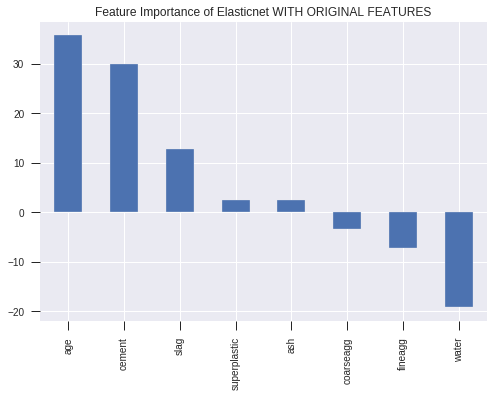

name                mae                 mse                rmse  \
0  Ridge_Basic   5.50514478580613   51.69750719118065   7.190097856857071   
0  Lasso_Basic   5.40141669099927   49.99351155312617   7.070608994501546   
0   Ridge_Poly  4.646336817085489   37.01093654956937  6.0836614427143605   
0   Lasso_Poly  5.659036389184505  52.807299808916426   7.266863134043218   
0   Elasticnet  5.773690880453998   54.74524585270793   7.399003030997347   

   explained_variance                  r2              adj_r2  
0  0.8204203590964072  0.8183853951262887  0.8135423389963231  
0  0.8153982728302221  0.8153059849873698  0.8103808112536997  
0  0.8708775443303565  0.8697635488179183  0.8071498703649944  
0  0.8159030804481799   0.808518954577864  0.8034127933666071  
0  0.7898109147369834  0.7897544525860254  0.7841479046549861

In [368]:
#########################################################################
#### Plotting the Feature importance - ELASTICNET IMPUTED DATA ##########
#########################################################################
coef_df = pd.DataFrame(elastic_regression.best_estimator_[1].coef_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of Elasticnet WITH ORIGINAL FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (elastic_regression.best_estimator_[1].coef_, y_test, y_pred_ridge)
evaluation_regression_df_temp = pd.DataFrame(np.array([["Elasticnet",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

In [512]:
model_list, feature_stack_df = consolidate_models_features(elastic_regression.best_estimator_[1],
                                                           elastic_regression.best_estimator_[1].coef_,
                                                           model_list, feature_stack_df, 
                                                           X_train.columns.values, "elnet_basic")
print("##############################################################################")
print("###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############")
print("##############################################################################")
feature_stack_df

##############################################################################
###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############
##############################################################################


cement       slag       ash      water  superplastic  \
ridge_basic  32.143301  13.961789  2.632147 -14.712805      5.408448   
lasso_basic  31.782499  14.239748  2.538990 -16.471462      4.693180   
elnet_basic  30.040281  12.809990  2.534713 -19.115585      2.543796   

             coarseagg   fineagg        age  
ridge_basic  -0.682517 -4.773558  35.964174  
lasso_basic  -0.301277 -3.722536  35.245700  
elnet_basic  -3.432660 -7.260205  35.799676

#### Elasticnet Regression : POLYFIT Dataset

In [371]:
#################################################################################
#### Hyper Parameter Tuning of ELASTICNET - POLYFIT Dataset #####################
#################################################################################
from sklearn.linear_model import ElasticNet

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_interaction, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , ElasticNet(random_state=42))
])

param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [ElasticNet(random_state=42)],
     'model_gs__alpha' : [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1],   
     'model_gs__l1_ratio' : [0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 1]
    }
]

#choosing njobs as -1 to have parallel processing
grid6 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
elastic_regression_poly = grid6.fit(X_train, y_train)
y_pred = elastic_regression_poly.predict(X_test)
elastic_regression_poly.best_estimator_, elastic_regression_poly.best_score_

(721, 100)
Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 359 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:   24.8s finished


(Pipeline(memory=None,
          steps=[('scaler',
                  QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                      n_quantiles=1000,
                                      output_distribution='uniform',
                                      random_state=None, subsample=100000)),
                 ('model_gs',
                  ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True,
                             l1_ratio=0.4, max_iter=1000, normalize=False,
                             positive=False, precompute=False, random_state=42,
                             selection='cyclic', tol=0.0001,
                             warm_start=False))],
          verbose=False), 0.8585055315720945)

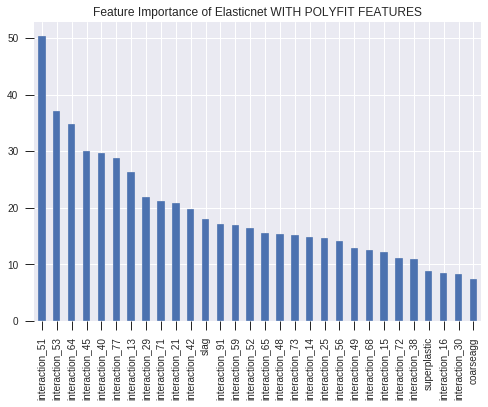

name                mae                 mse                rmse  \
0      Ridge_Basic   5.50514478580613   51.69750719118065   7.190097856857071   
0      Lasso_Basic   5.40141669099927   49.99351155312617   7.070608994501546   
0       Ridge_Poly  4.646336817085489   37.01093654956937  6.0836614427143605   
0       Lasso_Poly  5.659036389184505  52.807299808916426   7.266863134043218   
0  Elasticnet_Poly  4.782379699013563   40.42385223524041   6.357975482434672   
0       Elasticnet  5.773690880453998   54.74524585270793   7.399003030997347   

   explained_variance                  r2              adj_r2  
0  0.8204203590964072  0.8183853951262887  0.8135423389963231  
0  0.8153982728302221  0.8153059849873698  0.8103808112536997  
0  0.8708775443303565  0.8697635488179183  0.8071498703649944  
0  0.8159030804481799   0.808518954577864  0.8034127933666071  
0  0.8576474488346015  0.8575710839195931  0.7890956434963206  
0  0.7898109147369834  0.7897544525860254  0.7841479046549861

In [372]:
#########################################################################
#### Plotting the Feature importance - ELASTICNET POLYFIT DATA ##########
#########################################################################
coef_df = pd.DataFrame(elastic_regression_poly.best_estimator_[1].coef_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of Elasticnet WITH POLYFIT FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (elastic_regression_poly.best_estimator_[1].coef_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["Elasticnet_Poly",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

#### ELASTICNET Regression WITH POLYNOMIAL Features Evaluation in Hyperparameter Tuning :

RMSE is still around 7, and elasticnet algorithm has underperformed compared to Ridge and Lasso

#### Decision Tree Regression : Original Dataset

In [376]:
#################################################################################
#### Hyper Parameter Tuning of Decision Tree - Imputed Dataset ##################
#################################################################################
from sklearn.tree import DecisionTreeRegressor

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , DecisionTreeRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [DecisionTreeRegressor(random_state=42)],
     'model_gs__max_depth' : [2,4,5,10],   
     'model_gs__max_leaf_nodes' : [5,20,15,20,50,100],
     'model_gs__min_samples_split' : [10,20],
     'model_gs__criterion' : ["mse", "mae"]
    }
]

#choosing njobs as -1 to have parallel processing
grid7 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
dt_regression = grid7.fit(X_train, y_train)
y_pred = dt_regression.predict(X_test)
dt_regression.best_estimator_, dt_regression.best_score_

(721, 8)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.4s finished


(Pipeline(memory=None,
          steps=[('scaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('model_gs',
                  DecisionTreeRegressor(criterion='mse', max_depth=10,
                                        max_features=None, max_leaf_nodes=100,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=10,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=42,
                                        splitter='best'))],
          verbose=False), 0.7854993443142141)

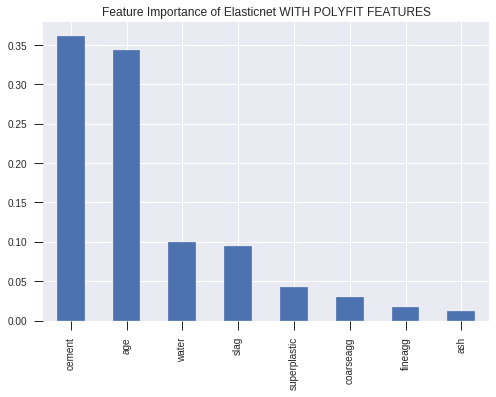

name                mae                 mse                rmse  \
0      Ridge_Basic   5.50514478580613   51.69750719118065   7.190097856857071   
0      Lasso_Basic   5.40141669099927   49.99351155312617   7.070608994501546   
0       Ridge_Poly  4.646336817085489   37.01093654956937  6.0836614427143605   
0     DecisionTree  5.003690514275304   52.71950621308068   7.260819940824912   
0       Lasso_Poly  5.659036389184505  52.807299808916426   7.266863134043218   
0  Elasticnet_Poly  4.782379699013563   40.42385223524041   6.357975482434672   
0       Elasticnet  5.773690880453998   54.74524585270793   7.399003030997347   

   explained_variance                  r2              adj_r2  
0  0.8204203590964072  0.8183853951262887  0.8135423389963231  
0  0.8153982728302221  0.8153059849873698  0.8103808112536997  
0  0.8708775443303565  0.8697635488179183  0.8071498703649944  
0  0.8112724485225176  0.8112220569027322  0.8061879784201385  
0  0.8159030804481799   0.808518954577864  0.8034127933666071  
0  0.8576474488346015  0.8575710839195931  0.7890956434963206  
0  0.7898109147369834  0.7897544525860254  0.7841479046549861

In [379]:
#############################################################################
#### Plotting the Feature importance - Decision Tree Original DATA ##########
#############################################################################
coef_df = pd.DataFrame(dt_regression.best_estimator_[1].feature_importances_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of Decision Tree with Original FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (dt_regression.best_estimator_[1].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["DecisionTree",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

In [513]:
model_list, feature_stack_df = consolidate_models_features(dt_regression.best_estimator_[1],
                                                           dt_regression.best_estimator_[1].feature_importances_,
                                                           model_list, feature_stack_df, 
                                                           X_train.columns.values, "Decision_Tree")
print("##############################################################################")
print("###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############")
print("##############################################################################")
feature_stack_df

##############################################################################
###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############
##############################################################################


cement       slag       ash      water  superplastic  \
ridge_basic    32.143301  13.961789  2.632147 -14.712805      5.408448   
lasso_basic    31.782499  14.239748  2.538990 -16.471462      4.693180   
elnet_basic    30.040281  12.809990  2.534713 -19.115585      2.543796   
Decision_Tree   0.361728   0.094684  0.011498   0.099353      0.042555   

               coarseagg   fineagg        age  
ridge_basic    -0.682517 -4.773558  35.964174  
lasso_basic    -0.301277 -3.722536  35.245700  
elnet_basic    -3.432660 -7.260205  35.799676  
Decision_Tree   0.029407  0.017269   0.343506

(721, 100)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 686 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   17.9s finished


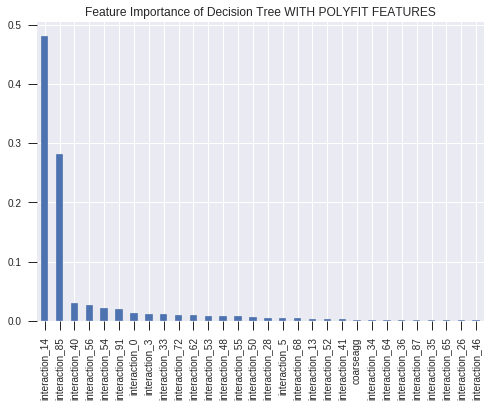

name                mae                 mse  \
0        Ridge_Basic   5.50514478580613   51.69750719118065   
0        Lasso_Basic   5.40141669099927   49.99351155312617   
0         Ridge_Poly  4.646336817085489   37.01093654956937   
0       DecisionTree  5.003690514275304   52.71950621308068   
0         Lasso_Poly  5.659036389184505  52.807299808916426   
0    Elasticnet_Poly  4.782379699013563   40.42385223524041   
0         Elasticnet  5.773690880453998   54.74524585270793   
0  DecisionTree_poly  5.035846679605205   53.15684770159734   

                 rmse  explained_variance                  r2  \
0   7.190097856857071  0.8204203590964072  0.8183853951262887   
0   7.070608994501546  0.8153982728302221  0.8153059849873698   
0  6.0836614427143605  0.8708775443303565  0.8697635488179183   
0   7.260819940824912  0.8112724485225176  0.8112220569027322   
0   7.266863134043218  0.8159030804481799   0.808518954577864   
0   6.357975482434672  0.8576474488346015  0.8575710839195931   
0   7.399003030997347  0.7898109147369834  0.7897544525860254   
0  7.2908742755308396  0.8374842059582293  0.8365297883738826   

               adj_r2  
0  0.8135423389963231  
0  0.8103808112536997  
0  0.8071498703649944  
0  0.8061879784201385  
0  0.8034127933666071  
0  0.7890956434963206  
0  0.7841479046549861  
0  0.7579383404767107

In [380]:
#################################################################################
#### Hyper Parameter Tuning of Decision Tree - Polyfit Dataset ##################
#################################################################################
from sklearn.tree import DecisionTreeRegressor

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_interaction, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , DecisionTreeRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [DecisionTreeRegressor(random_state=42)],
     'model_gs__max_depth' : [2,4,5,10],   
     'model_gs__max_leaf_nodes' : [5,20,15,20,50,100],
     'model_gs__min_samples_split' : [10,20],
     'model_gs__criterion' : ["mse", "mae"]
    }
]

#choosing njobs as -1 to have parallel processing
grid8 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
dt_regression_poly = grid8.fit(X_train, y_train)
y_pred = dt_regression_poly.predict(X_test)

#############################################################################
#### Plotting the Feature importance - Decision Tree Original DATA ##########
#############################################################################
coef_df = pd.DataFrame(dt_regression_poly.best_estimator_[1].feature_importances_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of Decision Tree WITH POLYFIT FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (dt_regression_poly.best_estimator_[1].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["DecisionTree_poly",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

#### Decision Tree WITH POLYNOMIAL Features Evaluation in Hyperparameter Tuning :

Decision Tree without polynomial fit has perfomed on par with 81% of explained variance and 7 RMSE however, Decision tree with polynomial is severely suffering from multicollinearity problem

(721, 8)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   35.5s finished


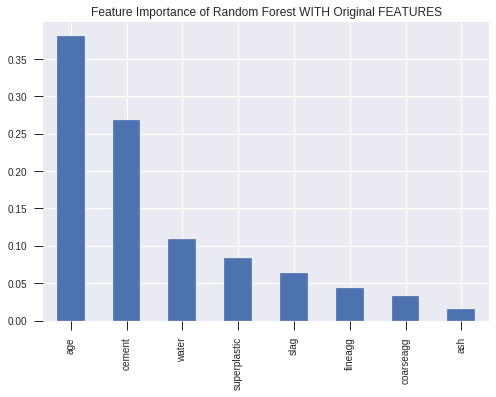

name                 mae                 mse  \
0      Random Forest  3.7665309757979872  30.866611143121855   
0        Ridge_Basic    5.50514478580613   51.69750719118065   
0        Lasso_Basic    5.40141669099927   49.99351155312617   
0         Ridge_Poly   4.646336817085489   37.01093654956937   
0       DecisionTree   5.003690514275304   52.71950621308068   
0         Lasso_Poly   5.659036389184505  52.807299808916426   
0    Elasticnet_Poly   4.782379699013563   40.42385223524041   
0         Elasticnet   5.773690880453998   54.74524585270793   
0  DecisionTree_poly   5.035846679605205   53.15684770159734   

                 rmse  explained_variance                  r2  \
0   5.555772776412104  0.8960759360560531  0.8952184310830881   
0   7.190097856857071  0.8204203590964072  0.8183853951262887   
0   7.070608994501546  0.8153982728302221  0.8153059849873698   
0  6.0836614427143605  0.8708775443303565  0.8697635488179183   
0   7.260819940824912  0.8112724485225176  0.8112220569027322   
0   7.266863134043218  0.8159030804481799   0.808518954577864   
0   6.357975482434672  0.8576474488346015  0.8575710839195931   
0   7.399003030997347  0.7898109147369834  0.7897544525860254   
0  7.2908742755308396  0.8374842059582293  0.8365297883738826   

               adj_r2  
0  0.8924242559119704  
0  0.8135423389963231  
0  0.8103808112536997  
0  0.8071498703649944  
0  0.8061879784201385  
0  0.8034127933666071  
0  0.7890956434963206  
0  0.7841479046549861  
0  0.7579383404767107

In [382]:
#################################################################################
#### Hyper Parameter Tuning of Random Forst - Imputed Dataset ##################
#################################################################################
from sklearn.ensemble import RandomForestRegressor

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , RandomForestRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [RandomForestRegressor(random_state=42)],
     'model_gs__max_depth': [24, 32, 40],     
     'model_gs__min_samples_leaf': [1, 2],
     'model_gs__n_estimators': [16, 32,64,80,128, 256], 
     'model_gs__max_features': ['auto', 'sqrt'],      
     'model_gs__n_jobs':[-1], 
    }
]

#choosing njobs as -1 to have parallel processing
grid9 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
rf_regression = grid9.fit(X_train, y_train)
y_pred = rf_regression.predict(X_test)

#############################################################################
#### Plotting the Feature importance - Decision Tree Original DATA ##########
#############################################################################
coef_df = pd.DataFrame(rf_regression.best_estimator_[1].feature_importances_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of Random Forest WITH Original FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (rf_regression.best_estimator_[1].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["Random_Forest",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

In [514]:
model_list, feature_stack_df = consolidate_models_features(rf_regression.best_estimator_[1],
                                                           rf_regression.best_estimator_[1].feature_importances_,
                                                           model_list, feature_stack_df, 
                                                           X_train.columns.values, "Random_Forest")
print("##############################################################################")
print("###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############")
print("##############################################################################")
feature_stack_df

##############################################################################
###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############
##############################################################################


cement       slag       ash      water  superplastic  \
ridge_basic    32.143301  13.961789  2.632147 -14.712805      5.408448   
lasso_basic    31.782499  14.239748  2.538990 -16.471462      4.693180   
elnet_basic    30.040281  12.809990  2.534713 -19.115585      2.543796   
Decision_Tree   0.361728   0.094684  0.011498   0.099353      0.042555   
Random_Forest   0.268432   0.064267  0.015529   0.109714      0.083828   

               coarseagg   fineagg        age  
ridge_basic    -0.682517 -4.773558  35.964174  
lasso_basic    -0.301277 -3.722536  35.245700  
elnet_basic    -3.432660 -7.260205  35.799676  
Decision_Tree   0.029407  0.017269   0.343506  
Random_Forest   0.033362  0.043977   0.380892

(721, 100)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.9min finished


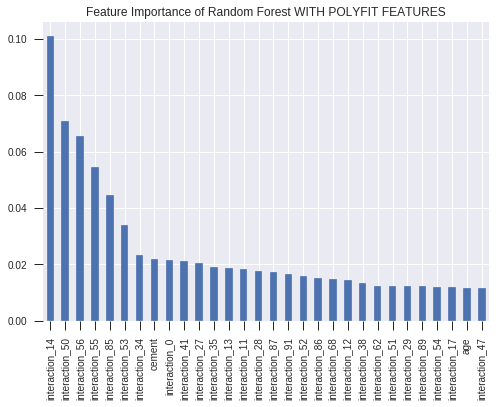

name                 mae                 mse  \
0          Random Forest  3.7665309757979872  30.866611143121855   
0  Random Forest_polyfit    3.41592281439022   29.95832036762471   
0            Ridge_Basic    5.50514478580613   51.69750719118065   
0            Lasso_Basic    5.40141669099927   49.99351155312617   
0             Ridge_Poly   4.646336817085489   37.01093654956937   
0           DecisionTree   5.003690514275304   52.71950621308068   
0             Lasso_Poly   5.659036389184505  52.807299808916426   
0        Elasticnet_Poly   4.782379699013563   40.42385223524041   
0             Elasticnet   5.773690880453998   54.74524585270793   
0      DecisionTree_poly   5.035846679605205   53.15684770159734   

                 rmse  explained_variance                  r2  \
0   5.555772776412104  0.8960759360560531  0.8952184310830881   
0   5.473419440132897  0.8834053420280604   0.883182278455686   
0   7.190097856857071  0.8204203590964072  0.8183853951262887   
0   7.070608994501546  0.8153982728302221  0.8153059849873698   
0  6.0836614427143605  0.8708775443303565  0.8697635488179183   
0   7.260819940824912  0.8112724485225176  0.8112220569027322   
0   7.266863134043218  0.8159030804481799   0.808518954577864   
0   6.357975482434672  0.8576474488346015  0.8575710839195931   
0   7.399003030997347  0.7898109147369834  0.7897544525860254   
0  7.2908742755308396  0.8374842059582293  0.8365297883738826   

               adj_r2  
0  0.8924242559119704  
0  0.8270199123286119  
0  0.8135423389963231  
0  0.8103808112536997  
0  0.8071498703649944  
0  0.8061879784201385  
0  0.8034127933666071  
0  0.7890956434963206  
0  0.7841479046549861  
0  0.7579383404767107

In [383]:
#################################################################################
#### Hyper Parameter Tuning of Random Forst - POLYFIT Dataset ##################
#################################################################################
from sklearn.ensemble import RandomForestRegressor

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_interaction, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , RandomForestRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [RandomForestRegressor(random_state=42)],
     'model_gs__max_depth': [24, 32, 40],     
     'model_gs__min_samples_leaf': [1, 2],
     'model_gs__n_estimators': [16, 32,64,80,128, 256], 
     'model_gs__max_features': ['auto', 'sqrt'],      
     'model_gs__n_jobs':[-1], 
    }
]

#choosing njobs as -1 to have parallel processing
grid10 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
rf_regression_poly = grid10.fit(X_train, y_train)
y_pred = rf_regression_poly.predict(X_test)

#############################################################################
#### Plotting the Feature importance - Decision Tree Original DATA ##########
#############################################################################
coef_df = pd.DataFrame(rf_regression_poly.best_estimator_[1].feature_importances_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of Random Forest WITH POLYFIT FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (rf_regression_poly.best_estimator_[1].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["Random_Forest_polyfit",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

(721, 8)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   31.0s finished


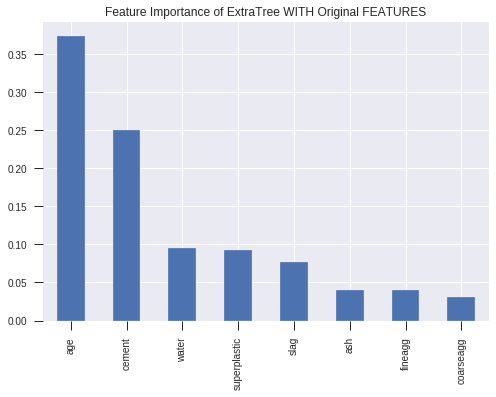

name                 mae                 mse  \
0             Extra_Tree  3.0142242490898097  22.730906761183558   
0          Random Forest  3.7665309757979872  30.866611143121855   
0  Random Forest_polyfit    3.41592281439022   29.95832036762471   
0            Ridge_Basic    5.50514478580613   51.69750719118065   
0            Lasso_Basic    5.40141669099927   49.99351155312617   
0             Ridge_Poly   4.646336817085489   37.01093654956937   
0           DecisionTree   5.003690514275304   52.71950621308068   
0             Lasso_Poly   5.659036389184505  52.807299808916426   
0        Elasticnet_Poly   4.782379699013563   40.42385223524041   
0             Elasticnet   5.773690880453998   54.74524585270793   
0      DecisionTree_poly   5.035846679605205   53.15684770159734   

                 rmse  explained_variance                  r2  \
0   4.767694071685343  0.9096766939836921  0.9096498562312342   
0   5.555772776412104  0.8960759360560531  0.8952184310830881   
0   5.473419440132897  0.8834053420280604   0.883182278455686   
0   7.190097856857071  0.8204203590964072  0.8183853951262887   
0   7.070608994501546  0.8153982728302221  0.8153059849873698   
0  6.0836614427143605  0.8708775443303565  0.8697635488179183   
0   7.260819940824912  0.8112724485225176  0.8112220569027322   
0   7.266863134043218  0.8159030804481799   0.808518954577864   
0   6.357975482434672  0.8576474488346015  0.8575710839195931   
0   7.399003030997347  0.7898109147369834  0.7897544525860254   
0  7.2908742755308396  0.8374842059582293  0.8365297883738826   

               adj_r2  
0  0.9072405190640671  
0  0.8924242559119704  
0  0.8270199123286119  
0  0.8135423389963231  
0  0.8103808112536997  
0  0.8071498703649944  
0  0.8061879784201385  
0  0.8034127933666071  
0  0.7890956434963206  
0  0.7841479046549861  
0  0.7579383404767107

In [384]:
#########################################################################################
#### Hyper Parameter Tuning of Extra Tree Regressor - ORIGINAL Dataset ##################
#########################################################################################
from sklearn.ensemble import ExtraTreesRegressor

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , ExtraTreesRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [ExtraTreesRegressor(random_state=42)],
     'model_gs__max_depth': [24, 32, 40],     
     'model_gs__min_samples_leaf': [1, 2],
     'model_gs__n_estimators': [16, 32,64,80,128, 256], 
     'model_gs__max_features': ['auto', 'sqrt'],      
     'model_gs__n_jobs':[-1], 
    }
]

#choosing njobs as -1 to have parallel processing
grid11 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
extra_tree_reg = grid11.fit(X_train, y_train)
y_pred = extra_tree_reg.predict(X_test)

#############################################################################
#### Plotting the Feature importance - Decision Tree Original DATA ##########
#############################################################################
coef_df = pd.DataFrame(extra_tree_reg.best_estimator_[1].feature_importances_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of ExtraTree WITH Original FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (extra_tree_reg.best_estimator_[1].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["Extra_Tree",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

In [515]:
model_list, feature_stack_df = consolidate_models_features(extra_tree_reg.best_estimator_[1],
                                                           extra_tree_reg.best_estimator_[1].feature_importances_,
                                                           model_list, feature_stack_df, 
                                                           X_train.columns.values, "Xtra_Tree")
print("##############################################################################")
print("###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############")
print("##############################################################################")
feature_stack_df

##############################################################################
###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############
##############################################################################


cement       slag       ash      water  superplastic  \
ridge_basic    32.143301  13.961789  2.632147 -14.712805      5.408448   
lasso_basic    31.782499  14.239748  2.538990 -16.471462      4.693180   
elnet_basic    30.040281  12.809990  2.534713 -19.115585      2.543796   
Decision_Tree   0.361728   0.094684  0.011498   0.099353      0.042555   
Random_Forest   0.268432   0.064267  0.015529   0.109714      0.083828   
Xtra_Tree       0.250614   0.077224  0.040118   0.095693      0.092336   

               coarseagg   fineagg        age  
ridge_basic    -0.682517 -4.773558  35.964174  
lasso_basic    -0.301277 -3.722536  35.245700  
elnet_basic    -3.432660 -7.260205  35.799676  
Decision_Tree   0.029407  0.017269   0.343506  
Random_Forest   0.033362  0.043977   0.380892  
Xtra_Tree       0.030323  0.039840   0.373852

(721, 100)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.1min finished


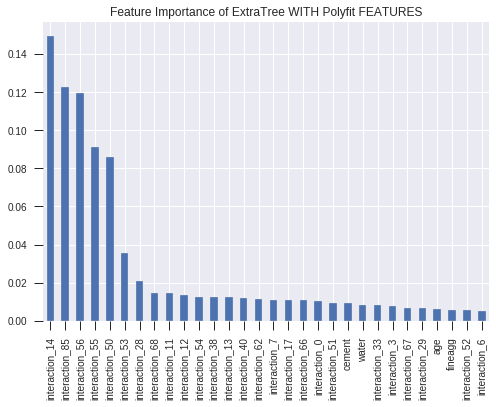

name                 mae                 mse  \
0             Extra_Tree  3.0142242490898097  22.730906761183558   
0          Random Forest  3.7665309757979872  30.866611143121855   
0        Extra_Tree_poly  3.2116474514563134  21.862041533538125   
0  Random Forest_polyfit    3.41592281439022   29.95832036762471   
0            Ridge_Basic    5.50514478580613   51.69750719118065   
0            Lasso_Basic    5.40141669099927   49.99351155312617   
0             Ridge_Poly   4.646336817085489   37.01093654956937   
0           DecisionTree   5.003690514275304   52.71950621308068   
0             Lasso_Poly   5.659036389184505  52.807299808916426   
0        Elasticnet_Poly   4.782379699013563   40.42385223524041   
0             Elasticnet   5.773690880453998   54.74524585270793   
0      DecisionTree_poly   5.035846679605205   53.15684770159734   

                 rmse  explained_variance                  r2  \
0   4.767694071685343  0.9096766939836921  0.9096498562312342   
0   5.555772776412104  0.8960759360560531  0.8952184310830881   
0   4.675686209909528  0.9178743991056949  0.9175249289344898   
0   5.473419440132897  0.8834053420280604   0.883182278455686   
0   7.190097856857071  0.8204203590964072  0.8183853951262887   
0   7.070608994501546  0.8153982728302221  0.8153059849873698   
0  6.0836614427143605  0.8708775443303565  0.8697635488179183   
0   7.260819940824912  0.8112724485225176  0.8112220569027322   
0   7.266863134043218  0.8159030804481799   0.808518954577864   
0   6.357975482434672  0.8576474488346015  0.8575710839195931   
0   7.399003030997347  0.7898109147369834  0.7897544525860254   
0  7.2908742755308396  0.8374842059582293  0.8365297883738826   

               adj_r2  
0  0.9072405190640671  
0  0.8924242559119704  
0  0.8778734524606868  
0  0.8270199123286119  
0  0.8135423389963231  
0  0.8103808112536997  
0  0.8071498703649944  
0  0.8061879784201385  
0  0.8034127933666071  
0  0.7890956434963206  
0  0.7841479046549861  
0  0.7579383404767107

In [385]:
#########################################################################################
#### Hyper Parameter Tuning of Extra Tree Regressor - POLYFIT Dataset ##################
#########################################################################################
from sklearn.ensemble import ExtraTreesRegressor

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_interaction, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , ExtraTreesRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [ExtraTreesRegressor(random_state=42)],
     'model_gs__max_depth': [24, 32, 40],     
     'model_gs__min_samples_leaf': [1, 2],
     'model_gs__n_estimators': [16, 32,64,80,128, 256], 
     'model_gs__max_features': ['auto', 'sqrt'],      
     'model_gs__n_jobs':[-1], 
    }
]

#choosing njobs as -1 to have parallel processing
grid12 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
extra_tree_reg_poly = grid12.fit(X_train, y_train)
y_pred = extra_tree_reg_poly.predict(X_test)

#############################################################################
#### Plotting the Feature importance - Decision Tree Original DATA ##########
#############################################################################
coef_df = pd.DataFrame(extra_tree_reg_poly.best_estimator_[1].feature_importances_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of ExtraTree WITH Polyfit FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (extra_tree_reg_poly.best_estimator_[1].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["Extra_Tree_poly",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

(721, 8)
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:   14.9s finished


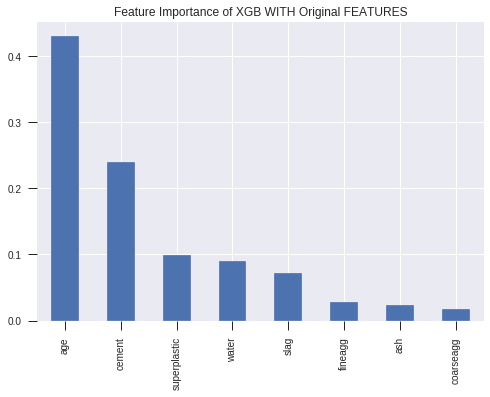

name                 mae                 mse  \
0                    XGB   3.153423845791122  21.241360446831035   
0             Extra_Tree  3.0142242490898097  22.730906761183558   
0          Random Forest  3.7665309757979872  30.866611143121855   
0        Extra_Tree_poly  3.2116474514563134  21.862041533538125   
0  Random Forest_polyfit    3.41592281439022   29.95832036762471   
0            Ridge_Basic    5.50514478580613   51.69750719118065   
0            Lasso_Basic    5.40141669099927   49.99351155312617   
0             Ridge_Poly   4.646336817085489   37.01093654956937   
0           DecisionTree   5.003690514275304   52.71950621308068   
0             Lasso_Poly   5.659036389184505  52.807299808916426   
0        Elasticnet_Poly   4.782379699013563   40.42385223524041   
0             Elasticnet   5.773690880453998   54.74524585270793   
0      DecisionTree_poly   5.035846679605205   53.15684770159734   

                 rmse  explained_variance                  r2  \
0   4.608835042267301   0.928494003751853  0.9283769465607461   
0   4.767694071685343  0.9096766939836921  0.9096498562312342   
0   5.555772776412104  0.8960759360560531  0.8952184310830881   
0   4.675686209909528  0.9178743991056949  0.9175249289344898   
0   5.473419440132897  0.8834053420280604   0.883182278455686   
0   7.190097856857071  0.8204203590964072  0.8183853951262887   
0   7.070608994501546  0.8153982728302221  0.8153059849873698   
0  6.0836614427143605  0.8708775443303565  0.8697635488179183   
0   7.260819940824912  0.8112724485225176  0.8112220569027322   
0   7.266863134043218  0.8159030804481799   0.808518954577864   
0   6.357975482434672  0.8576474488346015  0.8575710839195931   
0   7.399003030997347  0.7898109147369834  0.7897544525860254   
0  7.2908742755308396  0.8374842059582293  0.8365297883738826   

               adj_r2  
0  0.9264669984690327  
0  0.9072405190640671  
0  0.8924242559119704  
0  0.8778734524606868  
0  0.8270199123286119  
0  0.8135423389963231  
0  0.8103808112536997  
0  0.8071498703649944  
0  0.8061879784201385  
0  0.8034127933666071  
0  0.7890956434963206  
0  0.7841479046549861  
0  0.7579383404767107

In [388]:
#########################################################################################
#### Hyper Parameter Tuning of XGB - IMPUTED/ORIGINAL Dataset ###########################
#########################################################################################
from xgboost.sklearn import XGBRegressor

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , XGBRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [XGBRegressor(random_state=42)],
     'model_gs__reg_alpha': [0, 0.001, 0.01, 0.05], 
     'model_gs__min_child_weight':[6,10,12],
     'model_gs__max_depth':[3,5,6],
     'model_gs__n_estimators':[32,64,96,128],  
     'model_gs__n_jobs':[-1], 
    }
]

#choosing njobs as -1 to have parallel processing
grid13 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
xgb_reg = grid13.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

#############################################################################
#### Plotting the Feature importance - Decision Tree Original DATA ##########
#############################################################################
coef_df = pd.DataFrame(xgb_reg.best_estimator_[1].feature_importances_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of XGB WITH Original FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (xgb_reg.best_estimator_[1].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["XGB",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

In [516]:
model_list, feature_stack_df = consolidate_models_features(xgb_reg.best_estimator_[1],
                                                           xgb_reg.best_estimator_[1].feature_importances_,
                                                           model_list, feature_stack_df, 
                                                           X_train.columns.values, "XGB")
print("##############################################################################")
print("###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############")
print("##############################################################################")
feature_stack_df

##############################################################################
###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############
##############################################################################


cement       slag       ash      water  superplastic  \
ridge_basic    32.143301  13.961789  2.632147 -14.712805      5.408448   
lasso_basic    31.782499  14.239748  2.538990 -16.471462      4.693180   
elnet_basic    30.040281  12.809990  2.534713 -19.115585      2.543796   
Decision_Tree   0.361728   0.094684  0.011498   0.099353      0.042555   
Random_Forest   0.268432   0.064267  0.015529   0.109714      0.083828   
Xtra_Tree       0.250614   0.077224  0.040118   0.095693      0.092336   
XGB             0.239438   0.071291  0.023032   0.090426      0.099629   

               coarseagg   fineagg        age  
ridge_basic    -0.682517 -4.773558  35.964174  
lasso_basic    -0.301277 -3.722536  35.245700  
elnet_basic    -3.432660 -7.260205  35.799676  
Decision_Tree   0.029407  0.017269   0.343506  
Random_Forest   0.033362  0.043977   0.380892  
Xtra_Tree       0.030323  0.039840   0.373852  
XGB             0.017371  0.027803   0.431010

(721, 100)
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 295 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 895 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 1345 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 1895 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.7min finished


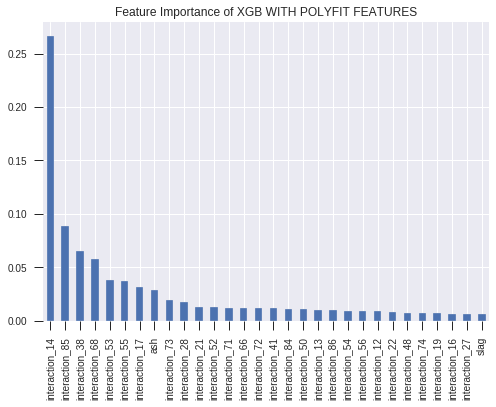

name                 mae                 mse  \
0                    XGB   3.153423845791122  21.241360446831035   
0             Extra_Tree  3.0142242490898097  22.730906761183558   
0               XGB_poly  2.9026327886859193  19.571180185122294   
0          Random Forest  3.7665309757979872  30.866611143121855   
0        Extra_Tree_poly  3.2116474514563134  21.862041533538125   
0  Random Forest_polyfit    3.41592281439022   29.95832036762471   
0            Ridge_Basic    5.50514478580613   51.69750719118065   
0            Lasso_Basic    5.40141669099927   49.99351155312617   
0             Ridge_Poly   4.646336817085489   37.01093654956937   
0           DecisionTree   5.003690514275304   52.71950621308068   
0             Lasso_Poly   5.659036389184505  52.807299808916426   
0        Elasticnet_Poly   4.782379699013563   40.42385223524041   
0             Elasticnet   5.773690880453998   54.74524585270793   
0      DecisionTree_poly   5.035846679605205   53.15684770159734   

                 rmse  explained_variance                  r2  \
0   4.608835042267301   0.928494003751853  0.9283769465607461   
0   4.767694071685343  0.9096766939836921  0.9096498562312342   
0   4.423932660554667   0.929151557542076  0.9288862942408521   
0   5.555772776412104  0.8960759360560531  0.8952184310830881   
0   4.675686209909528  0.9178743991056949  0.9175249289344898   
0   5.473419440132897  0.8834053420280604   0.883182278455686   
0   7.190097856857071  0.8204203590964072  0.8183853951262887   
0   7.070608994501546  0.8153982728302221  0.8153059849873698   
0  6.0836614427143605  0.8708775443303565  0.8697635488179183   
0   7.260819940824912  0.8112724485225176  0.8112220569027322   
0   7.266863134043218  0.8159030804481799   0.808518954577864   
0   6.357975482434672  0.8576474488346015  0.8575710839195931   
0   7.399003030997347  0.7898109147369834  0.7897544525860254   
0  7.2908742755308396  0.8374842059582293  0.8365297883738826   

               adj_r2  
0  0.9264669984690327  
0  0.9072405190640671  
0  0.8946970126258772  
0  0.8924242559119704  
0  0.8778734524606868  
0  0.8270199123286119  
0  0.8135423389963231  
0  0.8103808112536997  
0  0.8071498703649944  
0  0.8061879784201385  
0  0.8034127933666071  
0  0.7890956434963206  
0  0.7841479046549861  
0  0.7579383404767107

In [389]:
#########################################################################################
#### Hyper Parameter Tuning of XGB - POLYNOMIAL FEATURES Dataset ########################
#########################################################################################
from xgboost.sklearn import XGBRegressor

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_interaction, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model_gs' , XGBRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'model_gs' : [XGBRegressor(random_state=42)],
     'model_gs__reg_alpha': [0, 0.001, 0.01, 0.05], 
     'model_gs__min_child_weight':[6,10,12],
     'model_gs__max_depth':[3,5,6],
     'model_gs__n_estimators':[32,64,96,128],  
     'model_gs__n_jobs':[-1], 
    }
]

#choosing njobs as -1 to have parallel processing
grid14 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
xgb_reg_poly = grid14.fit(X_train, y_train)
y_pred = xgb_reg_poly.predict(X_test)

#############################################################################
#### Plotting the Feature importance - Decision Tree Original DATA ##########
#############################################################################
coef_df = pd.DataFrame(xgb_reg_poly.best_estimator_[1].feature_importances_,X_train.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of XGB WITH POLYFIT FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (xgb_reg_poly.best_estimator_[1].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["XGB_poly",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

In [391]:
##################################################################################################
#### Hyper Parameter Tuning of XGB, Extra Tree, RandomForest Dataset WITH PCA ####################
##################################################################################################
from xgboost.sklearn import XGBRegressor
from sklearn.decomposition import PCA

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3)
no_of_PCA_features = np.arange(1, 7)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca_reduction', PCA() ),
    ('model_gs' , XGBRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'pca_reduction': [PCA()],
     'pca_reduction__n_components': no_of_PCA_features,
     'pca_reduction__svd_solver': ['full', 'arpack', 'randomized'],
     'model_gs' : [XGBRegressor(random_state=42)],
     'model_gs__reg_alpha': [0, 0.001, 0.01, 0.05], 
     'model_gs__min_child_weight':[6,10,12],
     'model_gs__max_depth':[3,5,6],
     'model_gs__n_estimators':[32,64,96,128],  
     'model_gs__n_jobs':[-1], 
    },
    {'scaler': scaling_options,
     'pca_reduction': [PCA()],
     'pca_reduction__n_components': no_of_PCA_features,
     'pca_reduction__svd_solver': ['full', 'arpack', 'randomized'],
     'model_gs' : [RandomForestRegressor(random_state=42)],
     'model_gs__max_depth': [24, 32, 40],     
     'model_gs__min_samples_leaf': [1, 2],
     'model_gs__n_estimators': [16, 32,64,80,128, 256], 
     'model_gs__max_features': ['auto', 'sqrt'],      
     'model_gs__n_jobs':[-1], 
    },
    {'scaler': scaling_options,
     'pca_reduction': [PCA()],
     'pca_reduction__n_components': no_of_PCA_features,
     'pca_reduction__svd_solver': ['full', 'arpack', 'randomized'],
     'model_gs' : [ExtraTreesRegressor(random_state=42)],
     'model_gs__max_depth': [24, 32, 40],     
     'model_gs__min_samples_leaf': [1, 2],
     'model_gs__n_estimators': [16, 32,64,80,128, 256], 
     'model_gs__max_features': ['auto', 'sqrt'],      
     'model_gs__n_jobs':[-1], 
    }
]

#choosing njobs as -1 to have parallel processing
grid15 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
pca_reg = grid15.fit(X_train, y_train)
y_pred = pca_reg.predict(X_test)


(721, 8)
Fitting 5 folds for each of 15552 candidates, totalling 77760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 2876 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 5676 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 9276 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 13676 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 18876 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 24876 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 30644 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 34444 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 38644 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 40643 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 41893 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 43243 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 44693 

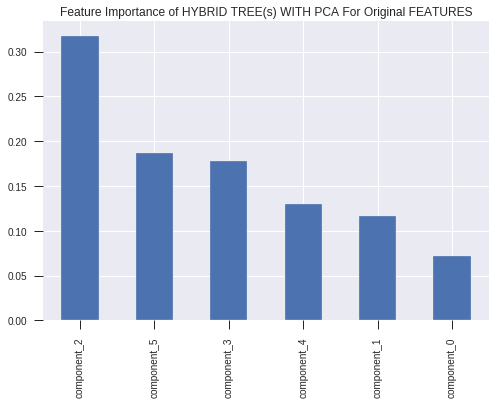

name                 mae                 mse  \
0                    XGB   3.153423845791122  21.241360446831035   
0             Extra_Tree  3.0142242490898097  22.730906761183558   
0               XGB_poly  2.9026327886859193  19.571180185122294   
0          Random Forest  3.7665309757979872  30.866611143121855   
0        Extra_Tree_poly  3.2116474514563134  21.862041533538125   
0    PCA_XGB_RF_XTRATREE   3.913593391821744   34.08864348151596   
0  Random Forest_polyfit    3.41592281439022   29.95832036762471   
0            Ridge_Basic    5.50514478580613   51.69750719118065   
0            Lasso_Basic    5.40141669099927   49.99351155312617   
0             Ridge_Poly   4.646336817085489   37.01093654956937   
0           DecisionTree   5.003690514275304   52.71950621308068   
0             Lasso_Poly   5.659036389184505  52.807299808916426   
0        Elasticnet_Poly   4.782379699013563   40.42385223524041   
0             Elasticnet   5.773690880453998   54.74524585270793   
0      DecisionTree_poly   5.035846679605205   53.15684770159734   

                 rmse  explained_variance                  r2  \
0   4.608835042267301   0.928494003751853  0.9283769465607461   
0   4.767694071685343  0.9096766939836921  0.9096498562312342   
0   4.423932660554667   0.929151557542076  0.9288862942408521   
0   5.555772776412104  0.8960759360560531  0.8952184310830881   
0   4.675686209909528  0.9178743991056949  0.9175249289344898   
0   5.838548062790608  0.8731898760128392  0.8731547029464621   
0   5.473419440132897  0.8834053420280604   0.883182278455686   
0   7.190097856857071  0.8204203590964072  0.8183853951262887   
0   7.070608994501546  0.8153982728302221  0.8153059849873698   
0  6.0836614427143605  0.8708775443303565  0.8697635488179183   
0   7.260819940824912  0.8112724485225176  0.8112220569027322   
0   7.266863134043218  0.8159030804481799   0.808518954577864   
0   6.357975482434672  0.8576474488346015  0.8575710839195931   
0   7.399003030997347  0.7898109147369834  0.7897544525860254   
0  7.2908742755308396  0.8374842059582293  0.8365297883738826   

               adj_r2  
0  0.9264669984690327  
0  0.9072405190640671  
0  0.8946970126258772  
0  0.8924242559119704  
0  0.8778734524606868  
0  0.8706345977069878  
0  0.8270199123286119  
0  0.8135423389963231  
0  0.8103808112536997  
0  0.8071498703649944  
0  0.8061879784201385  
0  0.8034127933666071  
0  0.7890956434963206  
0  0.7841479046549861  
0  0.7579383404767107

In [403]:
################################################################################################
#### Plotting the Feature importance - XGB, Extra Tree, RandomForest Dataset WITH PCA ##########
################################################################################################
x_train_pca = pca_reg.best_estimator_[1].fit_transform(X_train)
dim_df = pd.DataFrame(x_train_pca)
dim_df=dim_df.add_prefix('component_')
x_train_pca = pca_reg.best_estimator_[1].fit_transform(X_train)

coef_df = pd.DataFrame(pca_reg.best_estimator_[2].feature_importances_,dim_df.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of HYBRID TREE(s) WITH PCA For Original FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (pca_reg.best_estimator_[2].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["PCA_XGB_RF_XTRATREE",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

In [404]:
##################################################################################################
#### Hyper Parameter Tuning of XGB, Extra Tree, RandomForest Dataset WITH PCA ####################
########################## POLYFIT DATA - 100 Features############################################
##################################################################################################
from xgboost.sklearn import XGBRegressor
from sklearn.decomposition import PCA

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_interaction, y, test_size=0.3)
no_of_PCA_features = np.arange(1, 20)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler(), RobustScaler(), QuantileTransformer()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca_reduction', PCA() ),
    ('model_gs' , XGBRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'pca_reduction': [PCA()],
     'pca_reduction__n_components': no_of_PCA_features,
     'pca_reduction__svd_solver': ['full', 'arpack', 'randomized'],
     'model_gs' : [XGBRegressor(random_state=42)],
     'model_gs__reg_alpha': [0, 0.001, 0.01, 0.05], 
     'model_gs__min_child_weight':[6,10,12],
     'model_gs__max_depth':[3,5,6],
     'model_gs__n_estimators':[32,64,96,128],  
     'model_gs__n_jobs':[-1], 
    },
    {'scaler': scaling_options,
     'pca_reduction': [PCA()],
     'pca_reduction__n_components': no_of_PCA_features,
     'pca_reduction__svd_solver': ['full', 'arpack', 'randomized'],
     'model_gs' : [RandomForestRegressor(random_state=42)],
     'model_gs__max_depth': [24, 32, 40],     
     'model_gs__min_samples_leaf': [1, 2],
     'model_gs__n_estimators': [16, 32,64,80,128, 256], 
     'model_gs__max_features': ['auto', 'sqrt'],      
     'model_gs__n_jobs':[-1], 
    },
    {'scaler': scaling_options,
     'pca_reduction': [PCA()],
     'pca_reduction__n_components': no_of_PCA_features,
     'pca_reduction__svd_solver': ['full', 'arpack', 'randomized'],
     'model_gs' : [ExtraTreesRegressor(random_state=42)],
     'model_gs__max_depth': [24, 32, 40],     
     'model_gs__min_samples_leaf': [1, 2],
     'model_gs__n_estimators': [16, 32,64,80,128, 256], 
     'model_gs__max_features': ['auto', 'sqrt'],      
     'model_gs__n_jobs':[-1], 
    }
]

#choosing njobs as -1 to have parallel processing
grid16 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
pca_reg_poly = grid16.fit(X_train, y_train)
y_pred = pca_reg_poly.predict(X_test)


(721, 100)
Fitting 5 folds for each of 49248 candidates, totalling 246240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 11226 tasks      

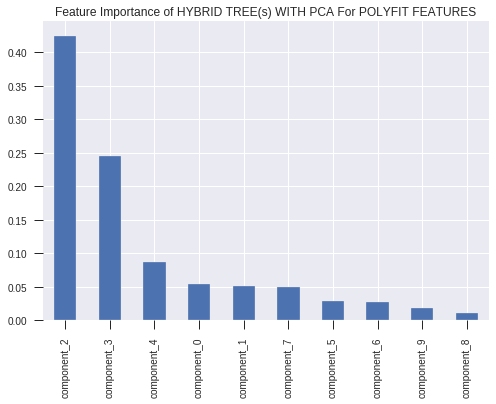

name                 mae                 mse  \
0                       XGB   3.153423845791122  21.241360446831035   
0                Extra_Tree  3.0142242490898097  22.730906761183558   
0                  XGB_poly  2.9026327886859193  19.571180185122294   
0             Random Forest  3.7665309757979872  30.866611143121855   
0  PCA_XGB_RF_XTRATREE_Poly   3.838817666803749   31.13053072757169   
0           Extra_Tree_poly  3.2116474514563134  21.862041533538125   
0       PCA_XGB_RF_XTRATREE   3.913593391821744   34.08864348151596   
0     Random Forest_polyfit    3.41592281439022   29.95832036762471   
0               Ridge_Basic    5.50514478580613   51.69750719118065   
0               Lasso_Basic    5.40141669099927   49.99351155312617   
0                Ridge_Poly   4.646336817085489   37.01093654956937   
0              DecisionTree   5.003690514275304   52.71950621308068   
0                Lasso_Poly   5.659036389184505  52.807299808916426   
0           Elasticnet_Poly   4.782379699013563   40.42385223524041   
0                Elasticnet   5.773690880453998   54.74524585270793   
0         DecisionTree_poly   5.035846679605205   53.15684770159734   

                 rmse  explained_variance                  r2  \
0   4.608835042267301   0.928494003751853  0.9283769465607461   
0   4.767694071685343  0.9096766939836921  0.9096498562312342   
0   4.423932660554667   0.929151557542076  0.9288862942408521   
0   5.555772776412104  0.8960759360560531  0.8952184310830881   
0   5.579474054744917  0.8856812775921568  0.8855385120453512   
0   4.675686209909528  0.9178743991056949  0.9175249289344898   
0   5.838548062790608  0.8731898760128392  0.8731547029464621   
0   5.473419440132897  0.8834053420280604   0.883182278455686   
0   7.190097856857071  0.8204203590964072  0.8183853951262887   
0   7.070608994501546  0.8153982728302221  0.8153059849873698   
0  6.0836614427143605  0.8708775443303565  0.8697635488179183   
0   7.260819940824912  0.8112724485225176  0.8112220569027322   
0   7.266863134043218  0.8159030804481799   0.808518954577864   
0   6.357975482434672  0.8576474488346015  0.8575710839195931   
0   7.399003030997347  0.7898109147369834  0.7897544525860254   
0  7.2908742755308396  0.8374842059582293  0.8365297883738826   

               adj_r2  
0  0.9264669984690327  
0  0.9072405190640671  
0  0.8946970126258772  
0  0.8924242559119704  
0  0.8816975225166717  
0  0.8778734524606868  
0  0.8706345977069878  
0  0.8270199123286119  
0  0.8135423389963231  
0  0.8103808112536997  
0  0.8071498703649944  
0  0.8061879784201385  
0  0.8034127933666071  
0  0.7890956434963206  
0  0.7841479046549861  
0  0.7579383404767107

In [405]:
################################################################################################
#### Plotting the Feature importance - XGB, Extra Tree, RandomForest Dataset WITH PCA ##########
################################################################################################
########################## POLYFIT DATA - 100 Features##########################################
################################################################################################
x_train_dim = pca_reg_poly.best_estimator_[1].fit_transform(X_train)
dim_df = pd.DataFrame(x_train_dim)
dim_df=dim_df.add_prefix('component_')
x_train_pca = pca_reg_poly.best_estimator_[1].fit_transform(X_train)
 
coef_df = pd.DataFrame(pca_reg_poly.best_estimator_[2].feature_importances_,dim_df.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of HYBRID TREE(s) WITH PCA For POLYFIT FEATURES")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (pca_reg_poly.best_estimator_[2].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["PCA_XGB_RF_XTRATREE_Poly",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

In [649]:
#########################################################################################
#### Hyper Parameter Tuning of XGB - IMPUTED/ORIGINAL Dataset ###########################
#################### Feature Selection using Select Kbest ###############################
#########################################################################################
from xgboost.sklearn import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler()]
no_of_features = [2,4,6,8]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_regression)),
    ('model_gs' , XGBRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'feature_selection': [SelectKBest(f_regression), SelectKBest(mutual_info_regression)],
     'feature_selection__k': no_of_features,
     'model_gs' : [XGBRegressor(random_state=42)],
     'model_gs__reg_alpha': [0, 0.001, 0.01, 0.05], 
     'model_gs__min_child_weight':[6,10,12],
     'model_gs__max_depth':[3,5,6],
     'model_gs__n_estimators':[32,64,96,128],  
     'model_gs__n_jobs':[-1], 
    }
]

#choosing njobs as -1 to have parallel processing
grid17 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
xgb_reg_kbestfeatures = grid17.fit(X_train, y_train)
y_pred = xgb_reg_kbestfeatures.predict(X_test)


(721, 8)
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 635 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2135 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 4235 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:   47.9s finished


In [650]:
##########################################################################################
#### It selected all 8 featrues as outcome USING F-REGRESSION ############################
############ Univariate linear regression tests ##########################################
######### Linear model for testing the individual effect of each of many regressors ######
##########################################################################################

xgb_reg_kbestfeatures.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('feature_selection',
                 SelectKBest(k=8,
                             score_func=<function f_regression at 0x7f596f1bfc80>)),
                ('model_gs',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=5,
                              min_child_weight=12, missing=None,
                              n_estimators=128, n_jobs=-1, nthread=None,
                              objective='reg:linear', random_state=42,
                              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=True, subsample=1))],
         verbose=False)

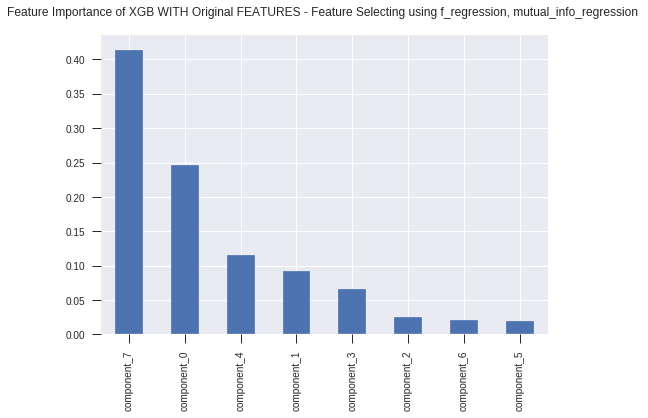

name                 mae                 mse  \
0                  XGB_kbest   2.829673795977843  15.653067709740844   
0                  XGB_kbest  2.9225602426498067  15.710750944051169   
14                       XGB   3.153423845791122  21.241360446831035   
12                Extra_Tree  3.0142242490898097  22.730906761183558   
15                  XGB_poly  2.9026327886859193  19.571180185122294   
11             Random Forest  3.7665309757979872  30.866611143121855   
10  PCA_XGB_RF_XTRATREE_Poly   3.838817666803749   31.13053072757169   
13           Extra_Tree_poly  3.2116474514563134  21.862041533538125   
8        PCA_XGB_RF_XTRATREE   3.913593391821744   34.08864348151596   
9      Random Forest_polyfit    3.41592281439022   29.95832036762471   
4                Ridge_Basic    5.50514478580613   51.69750719118065   
2                Lasso_Basic    5.40141669099927   49.99351155312617   
7                 Ridge_Poly   4.646336817085489   37.01093654956937   
1               DecisionTree   5.003690514275304   52.71950621308068   
3                 Lasso_Poly   5.659036389184505  52.807299808916426   
6            Elasticnet_Poly   4.782379699013563   40.42385223524041   
0                 Elasticnet   5.773690880453998   54.74524585270793   
5          DecisionTree_poly   5.035846679605205   53.15684770159734   
0    XGB_feature_from_models   6.918531769564237   79.37265360396684   
0                  XGB_kbest   6.480046753559298   72.50665340953327   
0                  XGB_kbest   6.480046753559298   72.50665340953327   

                  rmse  explained_variance                  r2  \
0   3.9563957979126463  0.9454815894147303  0.9454719579792764   
0   3.9636789658158706   0.941153941427263  0.9403935405923598   
14   4.608835042267301   0.928494003751853  0.9283769465607461   
12   4.767694071685343  0.9096766939836921  0.9096498562312342   
15   4.423932660554667   0.929151557542076  0.9288862942408521   
11   5.555772776412104  0.8960759360560531  0.8952184310830881   
10   5.579474054744917  0.8856812775921568  0.8855385120453512   
13   4.675686209909528  0.9178743991056949  0.9175249289344898   
8    5.838548062790608  0.8731898760128392  0.8731547029464621   
9    5.473419440132897  0.8834053420280604   0.883182278455686   
4    7.190097856857071  0.8204203590964072  0.8183853951262887   
2    7.070608994501546  0.8153982728302221  0.8153059849873698   
7   6.0836614427143605  0.8708775443303565  0.8697635488179183   
1    7.260819940824912  0.8112724485225176  0.8112220569027322   
3    7.266863134043218  0.8159030804481799   0.808518954577864   
6    6.357975482434672  0.8576474488346015  0.8575710839195931   
0    7.399003030997347  0.7898109147369834  0.7897544525860254   
5   7.2908742755308396  0.8374842059582293  0.8365297883738826   
0    8.909133156708728  0.7180589004662319  0.7162468860286482   
0     8.51508387566049  0.7172085026608447  0.7161203843910797   
0     8.51508387566049  0.7172085026608447  0.7161203843910797   

                adj_r2  
0   0.9440178768587237  
0    0.938804035008156  
14  0.9264669984690327  
12  0.9072405190640671  
15  0.8946970126258772  
11  0.8924242559119704  
10  0.8816975225166717  
13  0.8778734524606868  
8   0.8706345977069878  
9   0.8270199123286119  
4   0.8135423389963231  
2   0.8103808112536997  
7   0.8071498703649944  
1   0.8061879784201385  
3   0.8034127933666071  
6   0.7890956434963206  
0   0.7841479046549861  
5   0.7579383404767107  
0   0.7143922905124955  
0   0.7085502613081752  
0   0.7085502613081752

In [651]:
#############################################################################
#### Plotting the Feature Selection using Select Kbest XGB ##################
#############################################################################
x_train_dim = xgb_reg_kbestfeatures.best_estimator_[1].fit_transform(X_train,y_train)
dim_df = pd.DataFrame(x_train_dim)
dim_df=dim_df.add_prefix('component_')
x_train_kbest = xgb_reg_kbestfeatures.best_estimator_[1].fit_transform(X_train, y_train)

x_test_dim = xgb_reg_kbestfeatures.best_estimator_[1].transform(X_test)

coef_df = pd.DataFrame(xgb_reg_kbestfeatures.best_estimator_[2].feature_importances_,dim_df.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of XGB WITH Original FEATURES - Feature Selecting using f_regression, mutual_info_regression \n")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (xgb_reg_kbestfeatures.best_estimator_[2].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["XGB_kbest",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

## voila - looks like we have found our best parameters - Feature selection through F_Regression Model has squeezed in 2% performance boost over XGB, Extra Tree and XGB with Poly regressors

In [563]:
model_list, feature_stack_df = consolidate_models_features(xgb_reg_kbestfeatures.best_estimator_[2],
                                                           xgb_reg_kbestfeatures.best_estimator_[2].feature_importances_,
                                                           model_list, feature_stack_df, 
                                                           X_train.columns.values, "XGB_selectKBest_f_regression")
print("##############################################################################")
print("###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############")
print("##############################################################################")
feature_stack_df

##############################################################################
###### Stacked Feature Weights for NON POLY/ORIGINAL FEATURE SET##############
##############################################################################


cement       slag       ash      water  \
ridge_basic                   32.143301  13.961789  2.632147 -14.712805   
lasso_basic                   31.782499  14.239748  2.538990 -16.471462   
elnet_basic                   30.040281  12.809990  2.534713 -19.115585   
Decision_Tree                  0.361728   0.094684  0.011498   0.099353   
Random_Forest                  0.268432   0.064267  0.015529   0.109714   
Xtra_Tree                      0.250614   0.077224  0.040118   0.095693   
XGB                            0.239438   0.071291  0.023032   0.090426   
XGB_selectKBest_f_regression   0.256095   0.085528  0.040768   0.084606   

                              superplastic  coarseagg   fineagg        age  
ridge_basic                       5.408448  -0.682517 -4.773558  35.964174  
lasso_basic                       4.693180  -0.301277 -3.722536  35.245700  
elnet_basic                       2.543796  -3.432660 -7.260205  35.799676  
Decision_Tree                     0.042555   0.029407  0.017269   0.343506  
Random_Forest                     0.083828   0.033362  0.043977   0.380892  
Xtra_Tree                         0.092336   0.030323  0.039840   0.373852  
XGB                               0.099629   0.017371  0.027803   0.431010  
XGB_selectKBest_f_regression      0.102612   0.013744  0.027611   0.389035

In [627]:
#########################################################################################
#### Hyper Parameter Tuning of XGB - IMPUTED/ORIGINAL Dataset ###########################
#################### Feature Selection using Select FROM MODEL ##########################
#########################################################################################
from xgboost.sklearn import XGBRegressor
from sklearn.feature_selection import SelectFromModel

X_imputed = imputed_df[numerical_features]
X_interaction = interaction_feat_df[numerical_features_interaction]
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3)

print(X_train.shape)
n_folds = 5
scaling_options = [StandardScaler()]
feature_from_models = [SelectFromModel(RandomForestRegressor(n_estimators = 128, n_jobs=-1)),
                       SelectFromModel(ExtraTreesRegressor(n_estimators=250,random_state=0)),
                       SelectFromModel(DecisionTreeRegressor())]


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_regression)),
    ('model_gs' , XGBRegressor(random_state=42))
])


param_grid_models = [
    {'scaler': scaling_options,
     'feature_selection': feature_from_models,
     'model_gs' : [XGBRegressor(random_state=42)],
     'model_gs__reg_alpha': [0, 0.001, 0.01, 0.05], 
     'model_gs__min_child_weight':[6,10,12],
     'model_gs__max_depth':[3,5,6],
     'model_gs__n_estimators':[32,64,96,128],  
     'model_gs__n_jobs':[-1], 
    }
]

#choosing njobs as -1 to have parallel processing
grid18 = GridSearchCV(pipe, param_grid = param_grid_models,cv = n_folds, verbose=True, n_jobs=-1)

#### Fitting ridge #########################
xgb_reg_model_feature_selection = grid18.fit(X_train, y_train)
y_pred = xgb_reg_model_feature_selection.predict(X_test)


(721, 8)
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.3min finished


In [567]:
##########################################################################################
#### Feature Selection USING MODELs - Random Forest, Xtra Trees, DT ######################
######################## Hyper parameter tuning ##########################################
##########################################################################################

xgb_reg_model_feature_selection.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                 criterion='mse',
                                                                 max_depth=None,
                                                                 max_features='auto',
                                                                 max_leaf_nodes=None,
                                                                 min_impurity_decrease=0.0,
                                                                 min_impurity_split=None,
                                                                 min_samples_leaf=1,
                                                                 min_samples_split=2,
                                                                 min

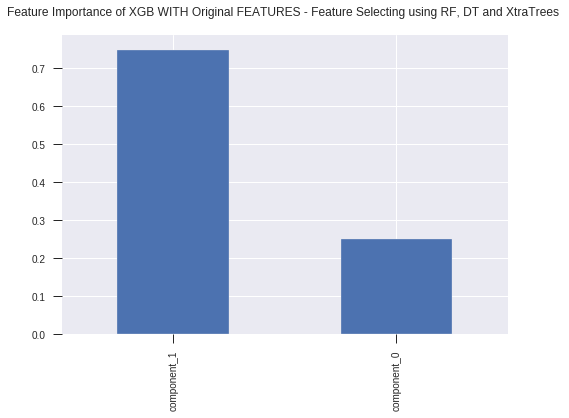

name                 mae                 mse  \
0                  XGB_kbest   2.829673795977843  15.653067709740844   
14                       XGB   3.153423845791122  21.241360446831035   
12                Extra_Tree  3.0142242490898097  22.730906761183558   
15                  XGB_poly  2.9026327886859193  19.571180185122294   
11             Random Forest  3.7665309757979872  30.866611143121855   
10  PCA_XGB_RF_XTRATREE_Poly   3.838817666803749   31.13053072757169   
13           Extra_Tree_poly  3.2116474514563134  21.862041533538125   
8        PCA_XGB_RF_XTRATREE   3.913593391821744   34.08864348151596   
9      Random Forest_polyfit    3.41592281439022   29.95832036762471   
4                Ridge_Basic    5.50514478580613   51.69750719118065   
2                Lasso_Basic    5.40141669099927   49.99351155312617   
7                 Ridge_Poly   4.646336817085489   37.01093654956937   
1               DecisionTree   5.003690514275304   52.71950621308068   
3                 Lasso_Poly   5.659036389184505  52.807299808916426   
6            Elasticnet_Poly   4.782379699013563   40.42385223524041   
0                 Elasticnet   5.773690880453998   54.74524585270793   
5          DecisionTree_poly   5.035846679605205   53.15684770159734   
0    XGB_feature_from_models   6.918531769564237   79.37265360396684   

                  rmse  explained_variance                  r2  \
0   3.9563957979126463  0.9454815894147303  0.9454719579792764   
14   4.608835042267301   0.928494003751853  0.9283769465607461   
12   4.767694071685343  0.9096766939836921  0.9096498562312342   
15   4.423932660554667   0.929151557542076  0.9288862942408521   
11   5.555772776412104  0.8960759360560531  0.8952184310830881   
10   5.579474054744917  0.8856812775921568  0.8855385120453512   
13   4.675686209909528  0.9178743991056949  0.9175249289344898   
8    5.838548062790608  0.8731898760128392  0.8731547029464621   
9    5.473419440132897  0.8834053420280604   0.883182278455686   
4    7.190097856857071  0.8204203590964072  0.8183853951262887   
2    7.070608994501546  0.8153982728302221  0.8153059849873698   
7   6.0836614427143605  0.8708775443303565  0.8697635488179183   
1    7.260819940824912  0.8112724485225176  0.8112220569027322   
3    7.266863134043218  0.8159030804481799   0.808518954577864   
6    6.357975482434672  0.8576474488346015  0.8575710839195931   
0    7.399003030997347  0.7898109147369834  0.7897544525860254   
5   7.2908742755308396  0.8374842059582293  0.8365297883738826   
0    8.909133156708728  0.7180589004662319  0.7162468860286482   

                adj_r2  
0   0.9440178768587237  
14  0.9264669984690327  
12  0.9072405190640671  
15  0.8946970126258772  
11  0.8924242559119704  
10  0.8816975225166717  
13  0.8778734524606868  
8   0.8706345977069878  
9   0.8270199123286119  
4   0.8135423389963231  
2   0.8103808112536997  
7   0.8071498703649944  
1   0.8061879784201385  
3   0.8034127933666071  
6   0.7890956434963206  
0   0.7841479046549861  
5   0.7579383404767107  
0   0.7143922905124955

In [568]:
#############################################################################
#### Plotting the Feature Selection using Select Kbest XGB ##################
#############################################################################
x_train_dim = xgb_reg_model_feature_selection.best_estimator_[1].fit_transform(X_train,y_train)
dim_df = pd.DataFrame(x_train_dim)
dim_df=dim_df.add_prefix('component_')
x_train_kbest = xgb_reg_model_feature_selection.best_estimator_[1].fit_transform(X_train, y_train)


coef_df = pd.DataFrame(xgb_reg_model_feature_selection.best_estimator_[2].feature_importances_,dim_df.columns, columns=['coefficent'])
coef_df['coefficent'].nlargest(30).plot(kind='bar')
plt.title("Feature Importance of XGB WITH Original FEATURES - Feature Selecting using RF, DT and XtraTrees \n")
plt.show()
######## Evaluating Lasso Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (xgb_reg_model_feature_selection.best_estimator_[2].feature_importances_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["XGB_feature_from_models",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

In [569]:
stacked_df = evaluation_regression_df.set_index('name')
for column in stacked_df.columns:
    stacked_df[column] = stacked_df[column].astype('float64')

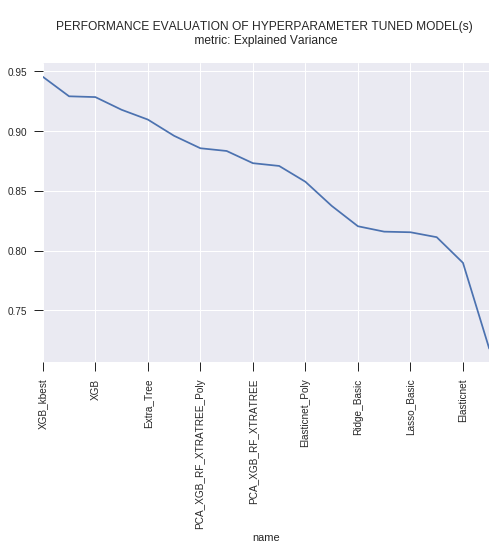

mae        mse      rmse  explained_variance        r2  \
name                                                                           
XGB_kbest        2.829674  15.653068  3.956396            0.945482  0.945472   
XGB_poly         2.902633  19.571180  4.423933            0.929152  0.928886   
XGB              3.153424  21.241360  4.608835            0.928494  0.928377   
Extra_Tree_poly  3.211647  21.862042  4.675686            0.917874  0.917525   
Extra_Tree       3.014224  22.730907  4.767694            0.909677  0.909650   

                   adj_r2  
name                       
XGB_kbest        0.944018  
XGB_poly         0.894697  
XGB              0.926467  
Extra_Tree_poly  0.877873  
Extra_Tree       0.907241

In [570]:
##########################################################
### VISUALIZATION OF MODEL PERFORMANCE POST TUNING #######
##########################################################
stacked_df['explained_variance'].nlargest(20).plot(kind='line')
plt.xticks(rotation=90)
plt.title("\nPERFORMANCE EVALUATION OF HYPERPARAMETER TUNED MODEL(s) \n metric: Explained Variance \n")

plt.show()
stacked_df.sort_values(by='explained_variance', ascending=False)[:5]

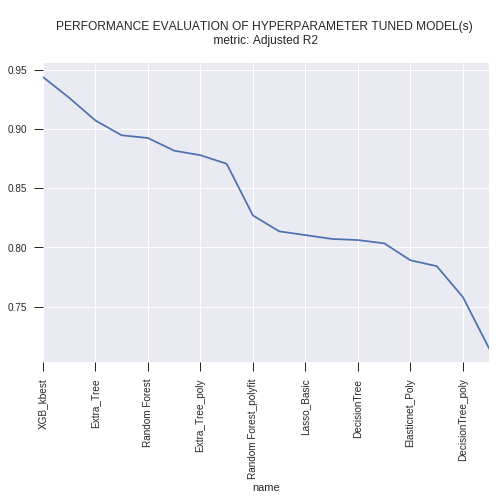

mae        mse      rmse  explained_variance        r2  \
name                                                                         
XGB_kbest      2.829674  15.653068  3.956396            0.945482  0.945472   
XGB            3.153424  21.241360  4.608835            0.928494  0.928377   
Extra_Tree     3.014224  22.730907  4.767694            0.909677  0.909650   
XGB_poly       2.902633  19.571180  4.423933            0.929152  0.928886   
Random Forest  3.766531  30.866611  5.555773            0.896076  0.895218   

                 adj_r2  
name                     
XGB_kbest      0.944018  
XGB            0.926467  
Extra_Tree     0.907241  
XGB_poly       0.894697  
Random Forest  0.892424

In [571]:
##########################################################
### VISUALIZATION OF MODEL PERFORMANCE POST TUNING #######
##########################################################
stacked_df['adj_r2'].nlargest(20).plot(kind='line')
plt.xticks(rotation=90)
plt.title("\nPERFORMANCE EVALUATION OF HYPERPARAMETER TUNED MODEL(s) \n metric: Adjusted R2 \n")

plt.show()
stacked_df.sort_values(by='adj_r2', ascending=False)[:5]

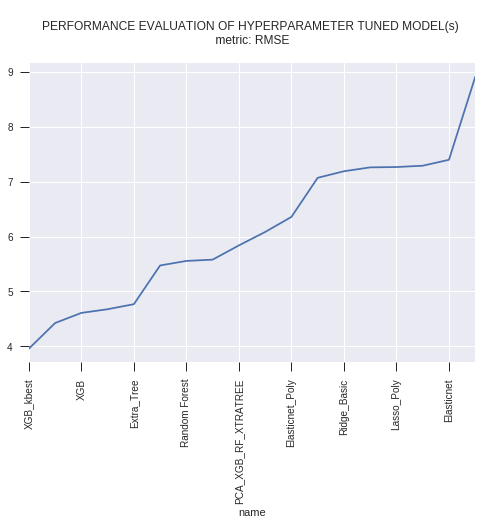

mae        mse      rmse  explained_variance        r2  \
name                                                                           
XGB_kbest        2.829674  15.653068  3.956396            0.945482  0.945472   
XGB_poly         2.902633  19.571180  4.423933            0.929152  0.928886   
XGB              3.153424  21.241360  4.608835            0.928494  0.928377   
Extra_Tree_poly  3.211647  21.862042  4.675686            0.917874  0.917525   
Extra_Tree       3.014224  22.730907  4.767694            0.909677  0.909650   

                   adj_r2  
name                       
XGB_kbest        0.944018  
XGB_poly         0.894697  
XGB              0.926467  
Extra_Tree_poly  0.877873  
Extra_Tree       0.907241

In [572]:
##########################################################
### VISUALIZATION OF MODEL PERFORMANCE POST TUNING #######
##########################################################
stacked_df['rmse'].nsmallest(20).plot(kind='line')
plt.xticks(rotation=90)
plt.title("\nPERFORMANCE EVALUATION OF HYPERPARAMETER TUNED MODEL(s) \n metric: RMSE \n")

plt.show()
stacked_df.sort_values(by='rmse', ascending=True)[:5]

In [573]:
#########################################################################################
#### So for consolidated best models that we could use for stacking/blending#############
########## Also, I have consolidated feature weights in dataframe #######################
################# Feature ranking can be done for creating another ensemble #############
#########################################################################################


print("#################### CONSOLIDATED BEST HYPERPARAMETER REGRESSION MODELS #################")
print(model_list)
print("\n")
print("#########################################################################################")
print("#################### CONSOLIDATED FEATURE WEIGHTS FOR REGRESSION MODELS #################")
print("#########################################################################################")

feature_stack_df

#################### CONSOLIDATED BEST HYPERPARAMETER REGRESSION MODELS #################
[Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001), Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False), ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.6,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False), DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=100, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best'),

cement       slag       ash      water  \
ridge_basic                   32.143301  13.961789  2.632147 -14.712805   
lasso_basic                   31.782499  14.239748  2.538990 -16.471462   
elnet_basic                   30.040281  12.809990  2.534713 -19.115585   
Decision_Tree                  0.361728   0.094684  0.011498   0.099353   
Random_Forest                  0.268432   0.064267  0.015529   0.109714   
Xtra_Tree                      0.250614   0.077224  0.040118   0.095693   
XGB                            0.239438   0.071291  0.023032   0.090426   
XGB_selectKBest_f_regression   0.256095   0.085528  0.040768   0.084606   

                              superplastic  coarseagg   fineagg        age  
ridge_basic                       5.408448  -0.682517 -4.773558  35.964174  
lasso_basic                       4.693180  -0.301277 -3.722536  35.245700  
elnet_basic                       2.543796  -3.432660 -7.260205  35.799676  
Decision_Tree                     0.042555   0.029407  0.017269   0.343506  
Random_Forest                     0.083828   0.033362  0.043977   0.380892  
Xtra_Tree                         0.092336   0.030323  0.039840   0.373852  
XGB                               0.099629   0.017371  0.027803   0.431010  
XGB_selectKBest_f_regression      0.102612   0.013744  0.027611   0.389035

In [644]:
#### Removing Duplicate from the list of models obtained in hyper parameter tuning #####
hyper_parameter_tuned_models = list(set(model_list))
len(model_list), len(hyper_parameter_tuned_models)

(8, 8)

In [645]:
#### EIGHT Unique Models - This will form inputs to Stacking ######
hyper_parameter_tuned_models

[ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.6,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=42, selection='cyclic', tol=0.0001, warm_start=False),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, importance_type='gain',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=6, missing=None, n_estimators=128, n_jobs=-1,
              nthread=None, objective='reg:linear', random_state=42,
              reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1),
 DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                       max_leaf_nodes=100, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                      

## STACKING - Consolidating all the hyperparameter tuned models for stacking

In [652]:
### STACKING STEPS ##############################################################################################
## Step 1 - We have 8 transformed/reduced features in X train and X test belonging to best estimator ###########
## Step 2 - We have 8 UNIQUE FINE TUNED models #################################################################
## Step 3 - For each of the model, we will train with X_train and validate with X_test and predict Y ############
## Step 4 - Combined prediction of all 12 will be STACKED TOGETHER for second level prediction ##################
## Step 5 - We will use one more SECOND level model to learn first level prediction and make final prediction ###
## TO BE NOTED - We can use multiple levels stacking, for simplicity we are sticking with 2 levels for now! #####
#################################################################################################################
x_train_dim.shape, x_test_dim.shape

((721, 8), (309, 8))

In [653]:
### Performing Stacking using vecstack package in python #######
from vecstack import stacking
from sklearn.metrics import explained_variance_score

S_train, S_test = stacking(hyper_parameter_tuned_models, 
                           x_train_dim, y_train, x_test_dim, 
                           regression=True,
                           mode='oof_pred_bag', 
                           needs_proba=False, save_dir=None,
                           metric=explained_variance_score, n_folds=4, stratified=True,
                           shuffle=True,
                           random_state=0, verbose=2)

/home/suren/anaconda3/envs/tfgpu/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


task:         [regression]
metric:       [explained_variance_score]
mode:         [oof_pred_bag]
n_models:     [8]

model  0:     [ElasticNet]
    fold  0:  [0.68325073]
    fold  1:  [0.66156221]
    fold  2:  [0.74350976]
    fold  3:  [0.65768119]
    ----
    MEAN:     [0.68650097] + [0.03432596]
    FULL:     [0.68596915]

model  1:     [XGBRegressor]
    fold  0:  [0.91533914]
    fold  1:  [0.87880808]
    fold  2:  [0.93291735]
    fold  3:  [0.92529564]
    ----
    MEAN:     [0.91309006] + [0.02075096]
    FULL:     [0.91341138]

model  2:     [DecisionTreeRegressor]
    fold  0:  [0.76571484]
    fold  1:  [0.76359243]
    fold  2:  [0.77818303]
    fold  3:  [0.84671226]
    ----
    MEAN:     [0.78855064] + [0.03403912]
    FULL:     [0.78668491]

model  3:     [ExtraTreesRegressor]
    fold  0:  [0.89735527]
    fold  1:  [0.86545857]
    fold  2:  [0.92130241]
    fold  3:  [0.91157782]
    ----
    MEAN:     [0.89892352] + [0.02111462]
    FULL:     [0.89860809]

model 

In [654]:
S_train.shape, S_test.shape, np.unique(S_train), np.unique(S_test)

((721, 8),
 (309, 8),
 array([ 4.24066687,  5.30726562,  5.45773438, ..., 86.52607737,
        86.52618784, 86.52734251]),
 array([ 3.9048264 ,  4.94483846,  5.03871094, ..., 81.48132359,
        81.48203755, 81.48206932]))

### Second Level of Stacking :- Passing Level 0 Stacked model prediction to Level 1 model 

In [657]:
stack_level2_model = LinearRegression()
stack_level2_model = stack_level2_model.fit(S_train, y_train)

In [665]:
stack_level2_pred = stack_level2_model.predict(S_test)
stack_level2_pred.shape

(309,)

In [659]:
stack_level2_model.coef_

array([ 2.32282642e+04,  5.48877257e-01,  5.73395054e-02,  3.05108961e-01,
        3.36955654e-01, -1.56123556e+03, -2.79991465e-01, -2.16669751e+04])

In [660]:
######## Evaluating STACKING Model #############
mae, mse, rmse, \
ev_score, r2, adj_r2 = evaluate_regression_model (stack_level2_model.coef_, y_test, y_pred)
evaluation_regression_df_temp = pd.DataFrame(np.array([["STACKING-Level1",mae, mse, rmse,ev_score, r2, adj_r2]]),
                                       columns=['name','mae', 'mse', 'rmse', 'explained_variance', 'r2', 'adj_r2'])

evaluation_regression_df = pd.concat([evaluation_regression_df, evaluation_regression_df_temp])
evaluation_regression_df.sort_values(by='adj_r2', ascending=False)

############################################################################################################
############## Like you can see below, performance was getting improved step by step in every phase ########
############################################################################################################

name                 mae                 mse  \
0                  XGB_kbest   2.829673795977843  15.653067709740844   
0            STACKING-Level1  2.9225602426498067  15.710750944051169   
0                  XGB_kbest  2.9225602426498067  15.710750944051169   
14                       XGB   3.153423845791122  21.241360446831035   
12                Extra_Tree  3.0142242490898097  22.730906761183558   
15                  XGB_poly  2.9026327886859193  19.571180185122294   
11             Random Forest  3.7665309757979872  30.866611143121855   
10  PCA_XGB_RF_XTRATREE_Poly   3.838817666803749   31.13053072757169   
13           Extra_Tree_poly  3.2116474514563134  21.862041533538125   
8        PCA_XGB_RF_XTRATREE   3.913593391821744   34.08864348151596   
9      Random Forest_polyfit    3.41592281439022   29.95832036762471   
4                Ridge_Basic    5.50514478580613   51.69750719118065   
2                Lasso_Basic    5.40141669099927   49.99351155312617   
7                 Ridge_Poly   4.646336817085489   37.01093654956937   
1               DecisionTree   5.003690514275304   52.71950621308068   
3                 Lasso_Poly   5.659036389184505  52.807299808916426   
6            Elasticnet_Poly   4.782379699013563   40.42385223524041   
0                 Elasticnet   5.773690880453998   54.74524585270793   
5          DecisionTree_poly   5.035846679605205   53.15684770159734   
0    XGB_feature_from_models   6.918531769564237   79.37265360396684   
0                  XGB_kbest   6.480046753559298   72.50665340953327   
0                  XGB_kbest   6.480046753559298   72.50665340953327   

                  rmse  explained_variance                  r2  \
0   3.9563957979126463  0.9454815894147303  0.9454719579792764   
0   3.9636789658158706   0.941153941427263  0.9403935405923598   
0   3.9636789658158706   0.941153941427263  0.9403935405923598   
14   4.608835042267301   0.928494003751853  0.9283769465607461   
12   4.767694071685343  0.9096766939836921  0.9096498562312342   
15   4.423932660554667   0.929151557542076  0.9288862942408521   
11   5.555772776412104  0.8960759360560531  0.8952184310830881   
10   5.579474054744917  0.8856812775921568  0.8855385120453512   
13   4.675686209909528  0.9178743991056949  0.9175249289344898   
8    5.838548062790608  0.8731898760128392  0.8731547029464621   
9    5.473419440132897  0.8834053420280604   0.883182278455686   
4    7.190097856857071  0.8204203590964072  0.8183853951262887   
2    7.070608994501546  0.8153982728302221  0.8153059849873698   
7   6.0836614427143605  0.8708775443303565  0.8697635488179183   
1    7.260819940824912  0.8112724485225176  0.8112220569027322   
3    7.266863134043218  0.8159030804481799   0.808518954577864   
6    6.357975482434672  0.8576474488346015  0.8575710839195931   
0    7.399003030997347  0.7898109147369834  0.7897544525860254   
5   7.2908742755308396  0.8374842059582293  0.8365297883738826   
0    8.909133156708728  0.7180589004662319  0.7162468860286482   
0     8.51508387566049  0.7172085026608447  0.7161203843910797   
0     8.51508387566049  0.7172085026608447  0.7161203843910797   

                adj_r2  
0   0.9440178768587237  
0    0.938804035008156  
0    0.938804035008156  
14  0.9264669984690327  
12  0.9072405190640671  
15  0.8946970126258772  
11  0.8924242559119704  
10  0.8816975225166717  
13  0.8778734524606868  
8   0.8706345977069878  
9   0.8270199123286119  
4   0.8135423389963231  
2   0.8103808112536997  
7   0.8071498703649944  
1   0.8061879784201385  
3   0.8034127933666071  
6   0.7890956434963206  
0   0.7841479046549861  
5   0.7579383404767107  
0   0.7143922905124955  
0   0.7085502613081752  
0   0.7085502613081752

In [667]:
X_test_df = pd.DataFrame(S_test)
X_test_df = X_test_df.add_prefix("Stacked_Feature_")

y_test_df = pd.DataFrame(y_test, columns=['Actual'])
prediction_df = pd.DataFrame(stack_level2_pred, columns=['Prediction'])

stacked_df = pd.concat([X_test_df, y_test_df, prediction_df], axis=1)
stacked_df.head()

Stacked_Feature_0  Stacked_Feature_1  Stacked_Feature_2  Stacked_Feature_3  \
0          24.781542          31.115080          32.985312          31.811396   
1          33.650845          38.633083          30.927500          37.169702   
2          17.690341          27.576724          31.289488          28.086826   
3          32.817037          32.861904          37.809231          37.451348   
4          28.905308          33.232978          35.745238          32.371934   

   Stacked_Feature_4  Stacked_Feature_5  Stacked_Feature_6  Stacked_Feature_7  \
0          29.929328          24.782146          31.356348          24.781496   
1          39.069317          33.651621          37.562305          33.650791   
2          27.200813          17.691756          30.162070          17.690242   
3          34.494968          32.815412          37.183848          32.817157   
4          32.961947          28.906994          32.947617          28.905187   

   Actual  Prediction  
0   32.72   30.635101  
1   33.80   38.008484  
2   24.05   26.386072  
3   33.36   33.825376  
4   33.70   32.849898

## FINAL REGRESSION FIT - GRAPH PLOT 

### We have squeezed the performance to additonal extent from hyper paramter tuning in TWO WAYS : 
1. Feature selection using F_Regression - Perforamce boosted FROM 92% explained varaince, 0.92 Adjusted R2 score, 4.6 RMSE TO SIGNIFICANT BOOST OF 95% EXPLAINED VARIANCE, 0.94 ADJUSTED R2 AND 3.9 RMSE

2. STACKING also helped in performance boosting FROM 92% explained varaince, 0.92 Adjusted R2 score, 4.6 RMSE TO SIGNIFICANT BOOST OF 94% EXPLAINED VARIANCE, 0.94 ADJUSTED R2 AND 3.9 RMSE

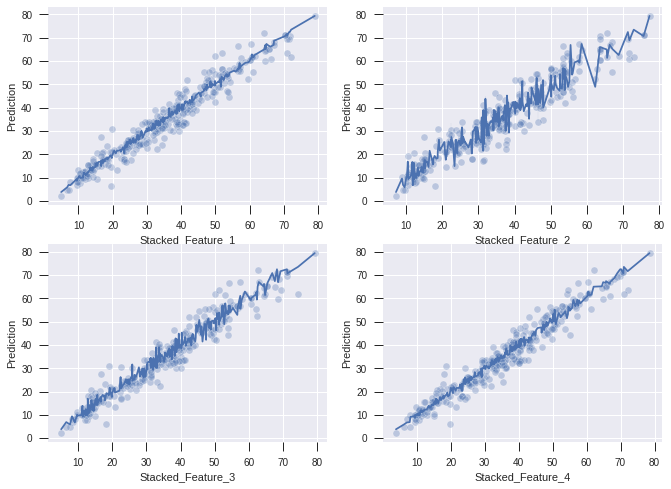

In [687]:
f, axes = plt.subplots(2, 2, figsize=(11, 8), sharex=False)
sns.scatterplot(x="Stacked_Feature_1", y="Actual",  palette="red", alpha = 0.3, data=stacked_df, ax=axes[0,0])
sns.lineplot(x="Stacked_Feature_1", y="Prediction", dashes=True, data=stacked_df, ax=axes[0,0])

sns.scatterplot(x="Stacked_Feature_2", y="Actual",  palette="red", alpha = 0.3, data=stacked_df, ax=axes[0,1])
sns.lineplot(x="Stacked_Feature_2", y="Prediction", dashes=True, data=stacked_df, ax=axes[0,1])

sns.scatterplot(x="Stacked_Feature_3", y="Actual",  palette="red", alpha = 0.3, data=stacked_df, ax=axes[1,0])
sns.lineplot(x="Stacked_Feature_3", y="Prediction", dashes=True, data=stacked_df, ax=axes[1,0])

sns.scatterplot(x="Stacked_Feature_4", y="Actual",  palette="red", alpha = 0.3, data=stacked_df, ax=axes[1,1])
sns.lineplot(x="Stacked_Feature_4", y="Prediction", dashes=True, data=stacked_df, ax=axes[1,1])

## FINAL SUMMARY OF MODEL EVALUATION - REGRESSION

#### Polynomial Feature Extraction Vs Hyperparameter Tuning Vs Feature Selection Vs Stacking

In [689]:
evaluation_regression_df.sort_values(by='adj_r2', ascending=False).head(10)

name                 mae                 mse  \
0                  XGB_kbest   2.829673795977843  15.653067709740844   
0            STACKING-Level1  2.9225602426498067  15.710750944051169   
0                  XGB_kbest  2.9225602426498067  15.710750944051169   
14                       XGB   3.153423845791122  21.241360446831035   
12                Extra_Tree  3.0142242490898097  22.730906761183558   
15                  XGB_poly  2.9026327886859193  19.571180185122294   
11             Random Forest  3.7665309757979872  30.866611143121855   
10  PCA_XGB_RF_XTRATREE_Poly   3.838817666803749   31.13053072757169   
13           Extra_Tree_poly  3.2116474514563134  21.862041533538125   
8        PCA_XGB_RF_XTRATREE   3.913593391821744   34.08864348151596   

                  rmse  explained_variance                  r2  \
0   3.9563957979126463  0.9454815894147303  0.9454719579792764   
0   3.9636789658158706   0.941153941427263  0.9403935405923598   
0   3.9636789658158706   0.941153941427263  0.9403935405923598   
14   4.608835042267301   0.928494003751853  0.9283769465607461   
12   4.767694071685343  0.9096766939836921  0.9096498562312342   
15   4.423932660554667   0.929151557542076  0.9288862942408521   
11   5.555772776412104  0.8960759360560531  0.8952184310830881   
10   5.579474054744917  0.8856812775921568  0.8855385120453512   
13   4.675686209909528  0.9178743991056949  0.9175249289344898   
8    5.838548062790608  0.8731898760128392  0.8731547029464621   

                adj_r2  
0   0.9440178768587237  
0    0.938804035008156  
0    0.938804035008156  
14  0.9264669984690327  
12  0.9072405190640671  
15  0.8946970126258772  
11  0.8924242559119704  
10  0.8816975225166717  
13  0.8778734524606868  
8   0.8706345977069878

## TECHNICAL SUMMARY : 

1. IN Depth study of every feature in dataset with deep dive in EDA was done. This includes Outlier detection and imputation using different models with evaluation.
2. Feature importance, feature weight, collinearity scores were recorded for each of the feature in dataset. 
3. New features were constructed using different interactions of existing features
4. Individual models - NON TREE based(Ridge, Linear, Lasso etc.) and ENSEMBLED/TREE based (like Decision Tree, Extra Tree, Random Forest, XGB) were experimented with wide range of hyper parameters separately plus, with interaction features through polynomial fits. Interactions were studied in depth to assess on collinearity problem in dataset.
5. Different Feature selection techniques were studied - selecting K best from F_Regression & selecting from various model based feature selections. We observed, F_Regression did a phenomenal job of having a generalized model
6. 
### Around 22 different combinations of Grid Search Hyperparameter tuning was conducted, OVER 400,000 models were fitted - Top 10 best were chosent & top 3 models having close to 95% confidence was designed
7. Final step included STACKING of all the models that gave a slight edge in the end for model's overall performance as well.
8. Regression plot in the end clearly reflects the outcome of our 95% confidence for the model to predict the strength of concrete

## FUNCTIONAL SUMMARY/FINAL VERDICT : 

#### Our generalized regression model would be able to predict strength of concrete with atleast 95% of confidence that predicted strength would match definitely in real time within range of (+/-)3.  